In [2]:
import numerox as nx
import pandas as pd
import numpy as np

import scipy
import scipy.cluster.hierarchy as sch
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
import xgboost as xgboost

In [7]:
data = nx.load_zip('numerai_datasets.zip')

In [8]:
#save it into .hdf format for faster load
data.save('numerai_datasets.hdf')


In [3]:
#then load from .hdf format instead of laoding the zip file
data = nx.load_data('numerai_datasets.hdf')

In [10]:
#data shows the various regions and the number of eras 
#eraX is the live dataset
data

region    train, validation, test, live
rows      2134719
era       443, [era1, eraX]
x         310, min 0.0000, mean 0.5000, max 1.0000
y         mean 0.499980, fraction missing 0.0894

In [11]:
data.region_isin(['train'])

region    train
rows      501808
era       120, [era1, era120]
x         310, min 0.0000, mean 0.5000, max 1.0000
y         mean 0.499980, fraction missing 0.0000

In [13]:
data.region_isin(['validation'])

region    validation
rows      106895
era       22, [era121, era206]
x         310, min 0.0000, mean 0.5000, max 1.0000
y         mean 0.499975, fraction missing 0.0000

In [14]:
data.region_isin(['test'])

region    test
rows      1520846
era       300, [era575, era922]
x         310, min 0.0000, mean 0.5000, max 1.0000
y         mean 0.499981, fraction missing 0.1250

In [21]:
data.region_isin(['live'])

region    live
rows      5170
era       1, [eraX, eraX]
x         310, min 0.0000, mean 0.5000, max 1.0000
y         mean 0.500000, fraction missing 0.1250

In [22]:
#The whole dataset or each region or each era can be viewed as a dataframe
data.df

,era,region,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,kazutsugi
id,,,,,,,,,,,,,,,,,,,,,
n000315175b67977,1.0,0.0,0.00,0.50,0.25,0.00,0.50,0.25,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
n0014af834a96cdd,1.0,0.0,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.25,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
n001c93979ac41d4,1.0,0.0,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.25,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
n0034e4143f22a13,1.0,0.0,1.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
n00679d1a636062f,1.0,0.0,0.25,0.25,0.25,0.25,0.00,0.25,0.50,0.25,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcfca10775a8a0,999.0,3.0,0.75,0.00,0.00,1.00,0.50,0.50,0.75,1.00,...,0.25,0.50,0.50,0.75,0.25,0.00,0.50,1.00,0.50,NaN
nffd2f4327ea6b6c,999.0,3.0,0.75,0.25,0.25,1.00,0.75,0.75,0.75,0.75,...,0.25,0.00,0.00,0.25,0.00,0.75,0.00,0.50,0.00,NaN
nffd6071d9622a7e,999.0,3.0,0.75,0.25,0.50,0.50,0.00,1.00,1.00,0.25,...,0.75,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,NaN


## Information about the dataset
id is the stock id.
There are 310 features beginning from feature_intelligence1 till feature_wisdon46.

kazutsugi column is the target column.
The values of all the features and the target column are discrete values in the range [0.0, 0.25, 0.50, 0.75, 1.00]

In [23]:
#Regionwise data can also be viewed
data.region_isin(['validation']).df

,era,region,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,kazutsugi
id,,,,,,,,,,,,,,,,,,,,,
n0003aa52cab36c2,121.0,1.0,0.25,0.75,0.50,0.50,0.00,0.75,0.50,0.25,...,0.75,0.75,1.00,0.75,0.50,0.50,1.0,0.00,0.00,0.00
n000920ed083903f,121.0,1.0,0.75,0.50,0.75,1.00,0.50,0.00,0.00,0.75,...,0.50,0.50,0.75,1.00,0.75,0.50,0.5,0.50,0.50,0.25
n0038e640522c4a6,121.0,1.0,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.50,0.25,0.00,0.00,0.5,0.50,0.00,1.00
n004ac94a87dc54b,121.0,1.0,0.75,1.00,1.00,0.50,0.00,0.00,0.00,0.50,...,0.00,0.00,0.00,0.25,0.00,0.00,0.0,0.25,0.25,0.75
n0052fe97ea0c05f,121.0,1.0,0.25,0.50,0.50,0.25,1.00,0.50,0.50,0.25,...,0.50,0.75,0.00,0.00,0.75,1.00,0.0,0.25,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffd5480fb9f2db3,206.0,1.0,0.00,0.50,0.50,0.00,0.50,0.25,0.25,0.00,...,0.25,0.25,0.50,0.50,0.25,0.75,0.5,1.00,0.25,0.25
nffd7dd1dc32bd48,206.0,1.0,0.75,0.25,0.50,0.75,1.00,1.00,1.00,0.25,...,0.50,0.50,0.00,0.00,0.50,0.75,0.0,0.75,0.75,0.50
nffdf49f7c43edd0,206.0,1.0,0.00,0.75,0.75,0.00,0.75,0.50,0.50,0.00,...,0.75,0.25,0.75,0.75,0.25,0.25,0.5,0.50,0.25,0.00


In [25]:
#Similarly erawise data can also be viewed
data.era_isin(['era100']).df

,era,region,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,kazutsugi
id,,,,,,,,,,,,,,,,,,,,,
n00143fa1c136546,100.0,0.0,0.25,0.25,0.25,0.75,1.00,0.50,0.50,0.50,...,1.00,1.00,0.75,1.00,1.00,1.00,0.75,0.75,1.00,0.25
n001ab6d168e004b,100.0,0.0,0.25,0.00,0.00,0.00,0.75,0.75,0.75,0.25,...,0.00,0.00,0.75,0.50,0.00,0.00,0.75,0.25,0.25,0.75
n002c4d10042a460,100.0,0.0,0.75,1.00,0.75,0.25,1.00,0.50,0.75,0.25,...,0.50,0.50,0.25,0.50,0.50,0.00,0.75,0.50,0.75,0.75
n00391d6aeeb5263,100.0,0.0,0.25,0.25,0.50,0.00,0.75,1.00,0.75,0.00,...,0.50,0.75,0.00,0.00,1.00,0.75,0.00,0.00,1.00,0.50
n004681fb877cd46,100.0,0.0,0.25,1.00,1.00,0.00,1.00,0.25,0.00,0.00,...,0.25,0.25,0.00,0.00,0.25,0.50,0.00,0.50,0.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcb85c78d596ac,100.0,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.75,0.00,...,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.50,0.50
nffe0d065f204a63,100.0,0.0,0.25,0.50,0.25,0.25,0.25,0.00,0.00,0.00,...,1.00,0.75,0.75,1.00,0.75,0.75,0.75,0.75,0.75,0.50
nffe2cb1f8ffa55e,100.0,0.0,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00,...,0.50,0.50,1.00,1.00,1.00,0.50,1.00,0.50,0.00,0.50


## Function to plot the correlation between the features 

In [27]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
     # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

### Plot feature correlation matrix for the live era/region. Remove region, era and target columns from the dataframe 

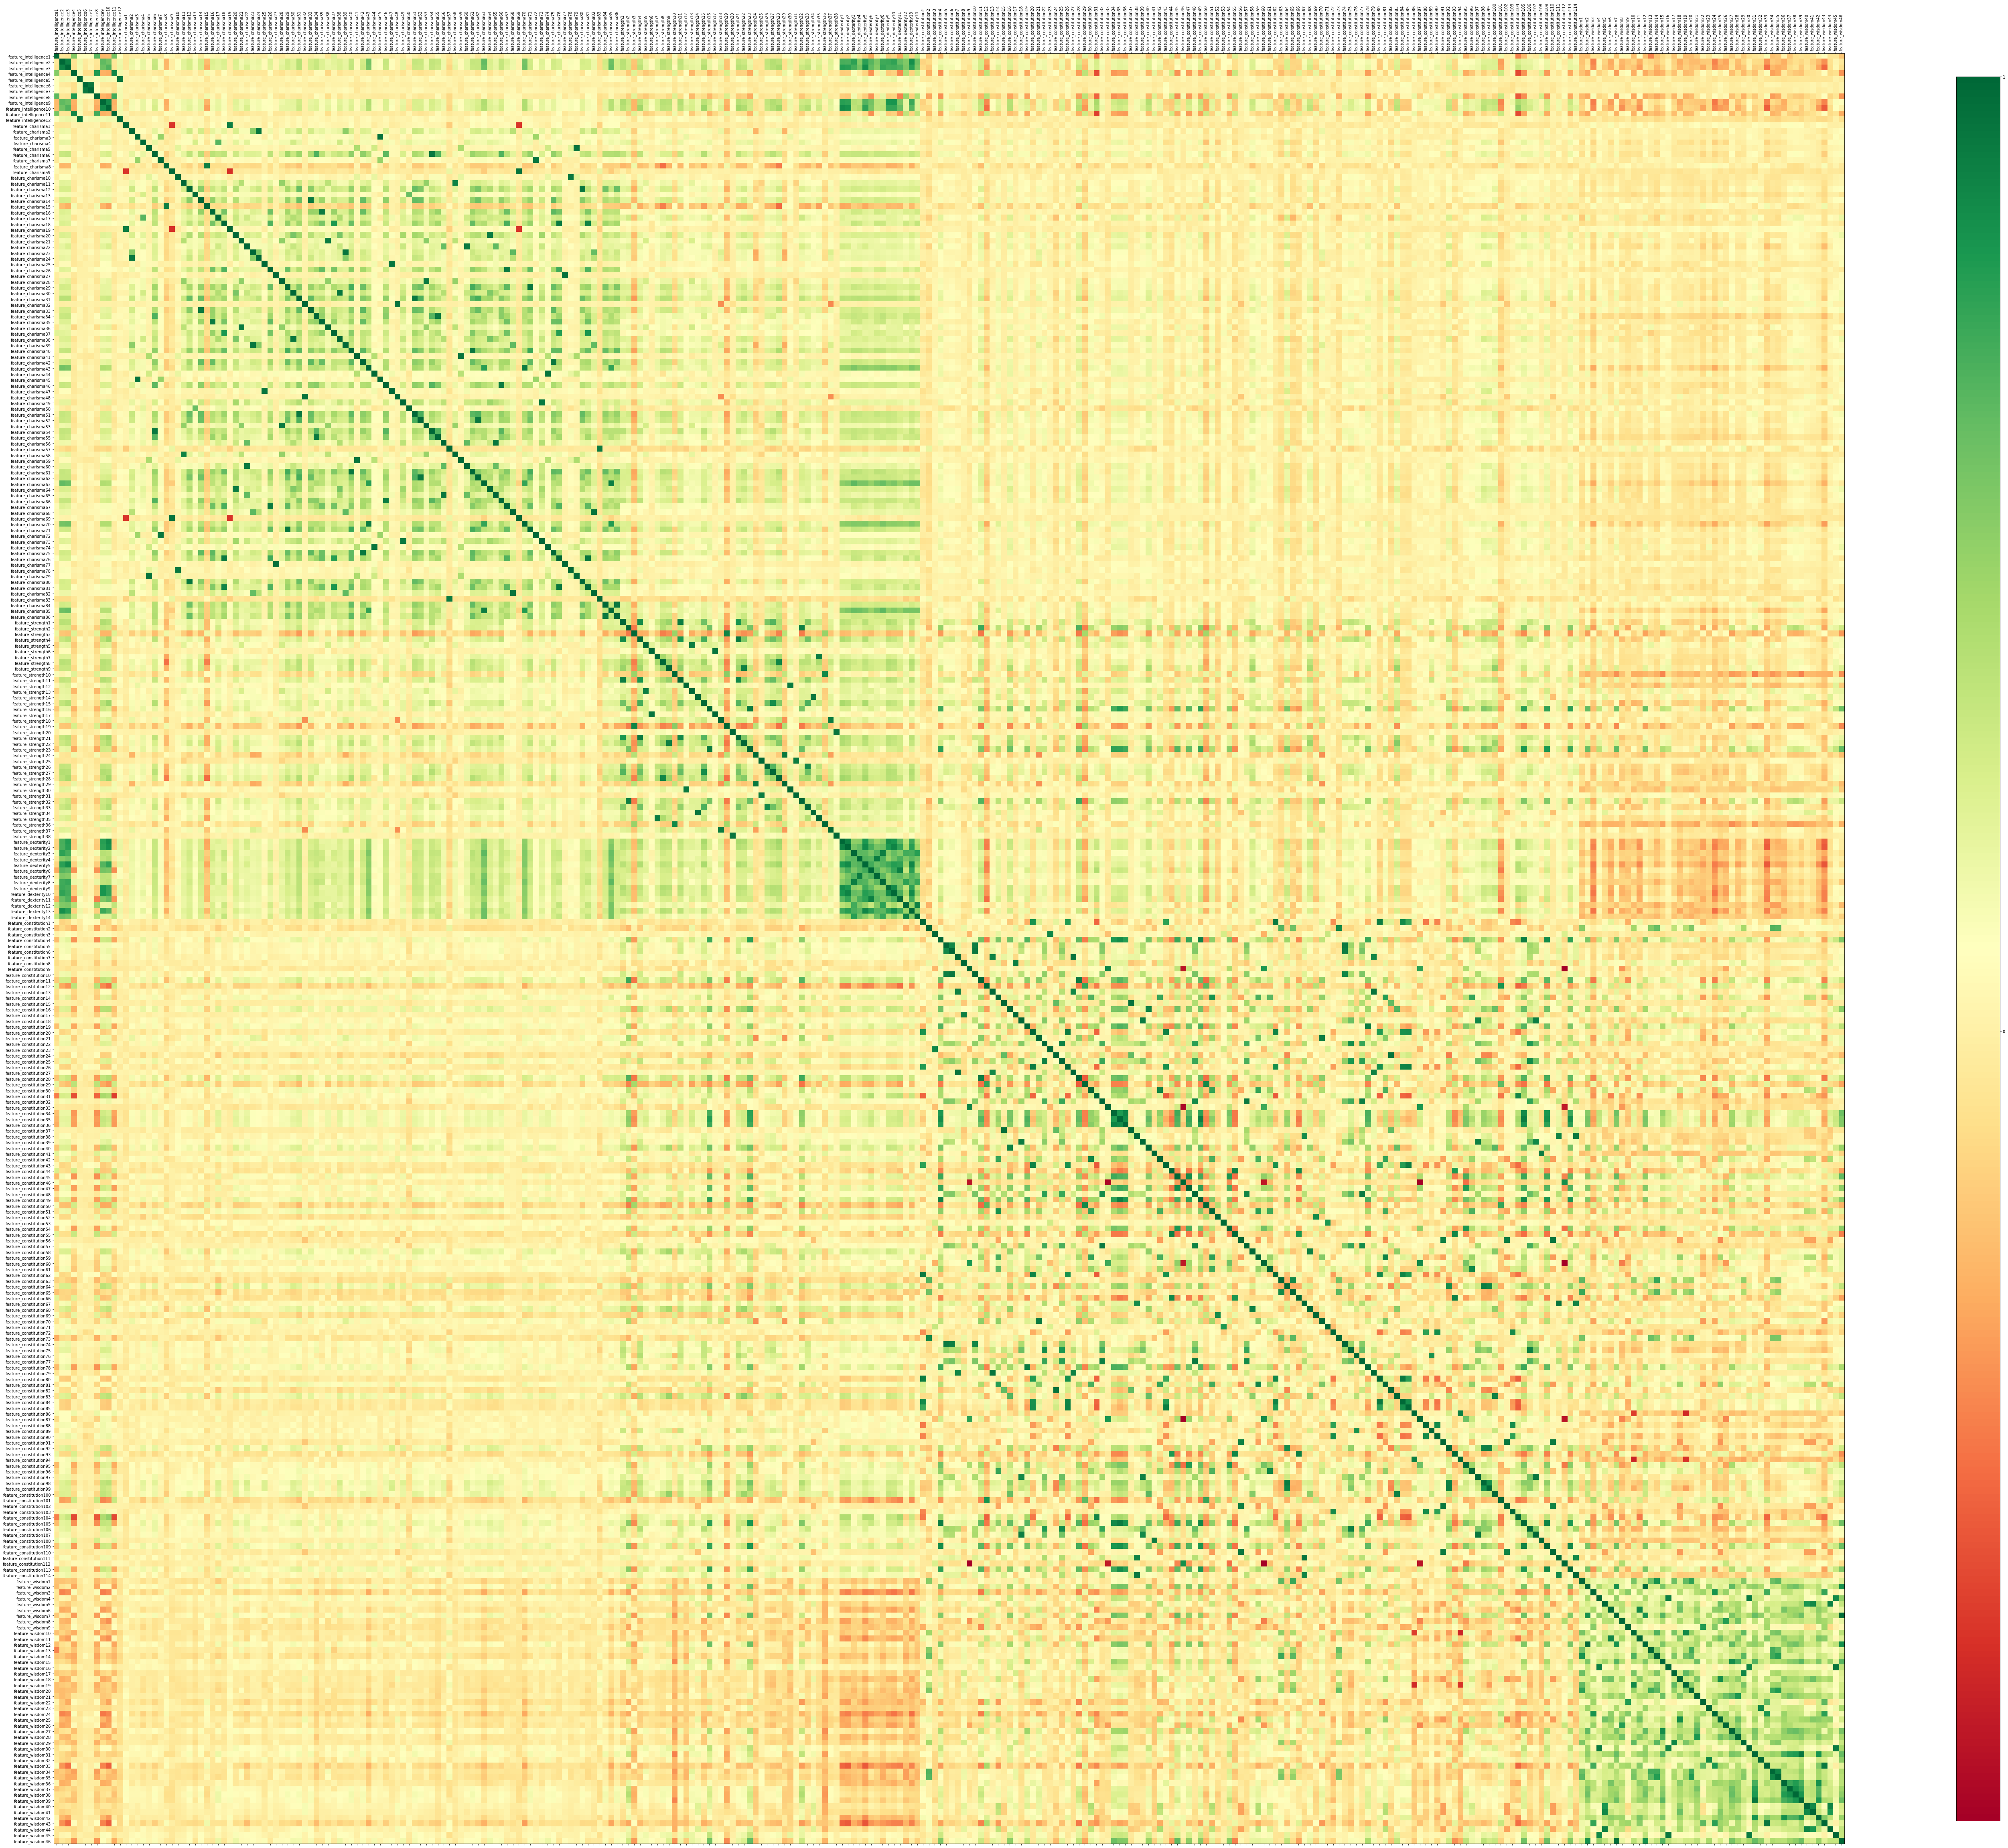

In [28]:
validdf = data.era_isin(['eraX']).df.copy()
validdf.drop(['era', 'region', 'kazutsugi'], axis=1, inplace=True)
plot_corr(validdf, 100)

## Create correlation cluster for an era 

In [11]:
def createCorrClusters(col_start, col_end, era_strs, verbose=0 ):
    """
    create correlation clusters for each era in era_strs. It works on the global data
    
    Input: 
        col_start: start column id for creating the correlation cluster
        col_end: end column id for creating the correlation cluster
        era_strs: array of era names for which correlation clusters need to be computed one-by-one
    
    Output:
        newdf: A new dataframe where era_strs correspond to rows while the features of 
                    original data sorted on cluster id serve as the columns. The values  are the cluster ids
        eraDfs: A simple dictionary holding eraName -> original data with columns sorted by cluster id
        
    """
    
    eraDfs = {}
    created = False
    #for i in range(num_eras):
    for eraStr in era_strs:
        
        #Get the dataframe for the era from col_start to col_end
        validdf = data.era_isin([eraStr]).df.iloc[:, col_start:col_end]
        if verbose:
            print("Generating clusters for era %s" % eraStr)
            
        #Compute the correlation among the features using spearman method
        #as it can measure non-linear relationship between the features
        X = validdf.corr(method='spearman').values

        d = sch.distance.pdist(X)   # vector of ('50' choose 2) pairwise distances
        
        #Perform hierarchical clustering based on the distance between correlation values
        L = sch.linkage(d, method='complete')
        #flatten the hierarchical clustering to generate cluster id for each feature
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        
        #sort the columns of the original dataframe based on the cluster ids
        columns = [validdf.columns.tolist()[i] for i in list((np.argsort(ind)))]
        validdf = validdf.reindex(columns, axis=1)
        if created == False:
            newdf = pd.DataFrame([ind], index=[eraStr])
            created = True
        else:
            tmpdf = pd.DataFrame([ind], index=[eraStr])
            newdf = newdf.append(tmpdf)
        eraDfs[eraStr] = validdf
        
    return newdf, eraDfs

### We can create the correlation clusters for non-live eras as that dataset rarely changes
#### The computed clusters can be saved and reused each week with new live data

In [51]:
non_live_eras = np.unique(data.region_isin(['train', 'validation', 'test']).era)
non_live_era_strs = data.eras_int2str(non_live_eras)
print(non_live_era_strs)

['era1', 'era10', 'era100', 'era101', 'era102', 'era103', 'era104', 'era105', 'era106', 'era107', 'era108', 'era109', 'era11', 'era110', 'era111', 'era112', 'era113', 'era114', 'era115', 'era116', 'era117', 'era118', 'era119', 'era12', 'era120', 'era121', 'era122', 'era123', 'era124', 'era125', 'era126', 'era127', 'era128', 'era129', 'era13', 'era130', 'era131', 'era132', 'era14', 'era15', 'era16', 'era17', 'era18', 'era19', 'era197', 'era198', 'era199', 'era2', 'era20', 'era200', 'era201', 'era202', 'era203', 'era204', 'era205', 'era206', 'era21', 'era22', 'era23', 'era24', 'era25', 'era26', 'era27', 'era28', 'era29', 'era3', 'era30', 'era31', 'era32', 'era33', 'era34', 'era35', 'era36', 'era37', 'era38', 'era39', 'era4', 'era40', 'era41', 'era42', 'era43', 'era44', 'era45', 'era46', 'era47', 'era48', 'era49', 'era5', 'era50', 'era51', 'era52', 'era53', 'era54', 'era55', 'era56', 'era57', 'era575', 'era576', 'era577', 'era578', 'era579', 'era58', 'era580', 'era581', 'era582', 'era583'

In [52]:
#Generate correlation clusters for all non-live eras
fset_corrcluster, fset_corr = createCorrClusters(2,312, non_live_era_strs, verbose=1)

Generating clusters for era era1
Generating clusters for era era10
Generating clusters for era era100
Generating clusters for era era101
Generating clusters for era era102
Generating clusters for era era103
Generating clusters for era era104
Generating clusters for era era105
Generating clusters for era era106
Generating clusters for era era107
Generating clusters for era era108
Generating clusters for era era109
Generating clusters for era era11
Generating clusters for era era110
Generating clusters for era era111
Generating clusters for era era112
Generating clusters for era era113
Generating clusters for era era114
Generating clusters for era era115
Generating clusters for era era116
Generating clusters for era era117
Generating clusters for era era118
Generating clusters for era era119
Generating clusters for era era12
Generating clusters for era era120
Generating clusters for era era121
Generating clusters for era era122
Generating clusters for era era123
Generating clusters for e

Generating clusters for era era701
Generating clusters for era era702
Generating clusters for era era703
Generating clusters for era era704
Generating clusters for era era705
Generating clusters for era era706
Generating clusters for era era707
Generating clusters for era era708
Generating clusters for era era709
Generating clusters for era era71
Generating clusters for era era710
Generating clusters for era era711
Generating clusters for era era712
Generating clusters for era era713
Generating clusters for era era714
Generating clusters for era era715
Generating clusters for era era716
Generating clusters for era era717
Generating clusters for era era718
Generating clusters for era era719
Generating clusters for era era72
Generating clusters for era era720
Generating clusters for era era721
Generating clusters for era era722
Generating clusters for era era723
Generating clusters for era era724
Generating clusters for era era725
Generating clusters for era era726
Generating clusters fo

In [53]:
#These clusters can be saved on disk as the data remains the same each week. For new data the above process can be repeated but it will be 
#very quick as only a couple of eras need to be processed ( 1 new test era + live era)
fset_corrcluster.to_hdf("corr_cluster_test_922.hdf", key='df')


### For each validation and test era find the eras whose correlation clusters match with the given era 
An average of 2 metrics - adjusted_rand_score and adjusted_mutual_info_score is taken

In [4]:
#Read from hdf
fset_corrcluster = pd.read_hdf("corr_cluster_test_922.hdf", key='df')

In [5]:
train_era_arr = np.unique(data.region_isin(['train', 'validation']).era)
train_era_strs = data.eras_int2str(train_era_arr)

eras_dict = {}
score_dict = {}
valid_eras = np.unique(data.region_isin(['validation', 'test']).era)
valid_era_strs = data.eras_int2str(valid_eras)

for base_era in valid_era_strs:
    era_lst = []
    score_lst = []
    base_fset =  fset_corrcluster.loc[[base_era]].values[0]
    for test_era in train_era_strs:
        if base_era == test_era:
            continue
        test_fset = fset_corrcluster.loc[[test_era]].values[0]
        score1 = metrics.adjusted_rand_score(base_fset, test_fset)
        score2 = metrics.adjusted_mutual_info_score(base_fset, test_fset, average_method='geometric' )
        if (score2) > 0.7:
            era_lst.append(test_era)
            score_lst.append((score1+score2)/2)
    eras_dict[base_era] = era_lst
    score_dict[base_era] = score_lst

### A basic cross-validation based model fitting function for XGBoost algorithm

In [6]:
def modelfit(alg, xtrain, ytrain, era_list, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(xtrain, ytrain)
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(xtrain)
    dpreSeries = pd.Series(dtrain_predictions, index=data.era_isin(era_list).df.index)
    
    rankedPred = dpreSeries.rank(pct=True, method='first')
    
    #Print model report:
    print("\nModel Report")
    print("Correlation is : %.4g" % np.corrcoef(ytrain, rankedPred)[0,1])
                        
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [7]:
#A simple XGBoost model with 100 estimators
def fit_xgb_model( eraStr, estimators=100):
    trainX = data.era_isin(eras_dict[eraStr]).x
    trainY = data.era_isin(eras_dict[eraStr]).y['kazutsugi']
    
    xgb = XGBRegressor(
             learning_rate =0.01,
             n_estimators= estimators,
             booster='gbtree',
             base_score=0.5,
             max_depth=7,
             min_child_weight=2,
             gamma=0,
             subsample=0.7,
             colsample_bytree=0.7,
             objective= 'reg:squarederror',
             nthread=8,
             scale_pos_weight=1,
             random_state=1)

    modelfit(xgb, trainX, trainY, eras_dict[eraStr])
    return xgb


	Generating predictions for era121



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353039+0.000140756	test-rmse:0.353056+0.000562785
[1]	train-rmse:0.353015+0.000140639	test-rmse:0.353051+0.000563679
[2]	train-rmse:0.352992+0.000140619	test-rmse:0.353045+0.000564602
[3]	train-rmse:0.35297+0.000139969	test-rmse:0.353042+0.000564243
[4]	train-rmse:0.352948+0.000140225	test-rmse:0.353037+0.00056412
[5]	train-rmse:0.352925+0.000140625	test-rmse:0.353031+0.000565422
[6]	train-rmse:0.352903+0.000139579	test-rmse:0.353027+0.000564789
[7]	train-rmse:0.35288+0.000139845	test-rmse:0.353023+0.000564402
[8]	train-rmse:0.352858+0.000139593	test-rmse:0.353018+0.000564319
[9]	train-rmse:0.352835+0.000139355	test-rmse:0.353014+0.000564859

Model Report
Correlation is is : 0.143
------------------------------------

	Generating predictions for era122

[0]	train-rmse:0.352972+7.4545e-05	test-rmse:0.352993+0.00029872
[1]	train-rmse:0.352946+7.37113e-05	test-rmse:0.352988+0.000299961
[2]	train-rmse:0.352921+7.34248e-05	test-rmse:0.352983+0.000300215
[3]	train-rmse:0.352

/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353+9.22445e-05	test-rmse:0.353017+0.000369938
[1]	train-rmse:0.352978+9.22011e-05	test-rmse:0.353015+0.000369319
[2]	train-rmse:0.352956+9.20986e-05	test-rmse:0.353011+0.000370913
[3]	train-rmse:0.352934+9.22553e-05	test-rmse:0.353007+0.000371941
[4]	train-rmse:0.352912+9.18137e-05	test-rmse:0.353004+0.000373004
[5]	train-rmse:0.35289+9.16397e-05	test-rmse:0.353+0.000373084
[6]	train-rmse:0.352868+9.2e-05	test-rmse:0.352997+0.000372262
[7]	train-rmse:0.352846+9.16157e-05	test-rmse:0.352993+0.000372972
[8]	train-rmse:0.352824+9.17701e-05	test-rmse:0.35299+0.000372381
[9]	train-rmse:0.352802+9.18203e-05	test-rmse:0.352986+0.000372018

Model Report
Correlation is is : 0.1387
------------------------------------

	Generating predictions for era124



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352916+0.000226193	test-rmse:0.352948+0.000905301
[1]	train-rmse:0.35288+0.000225598	test-rmse:0.352944+0.000904647
[2]	train-rmse:0.352842+0.000226006	test-rmse:0.352938+0.000906715
[3]	train-rmse:0.352805+0.000226388	test-rmse:0.352934+0.000906528
[4]	train-rmse:0.352768+0.000227075	test-rmse:0.352929+0.000907382
[5]	train-rmse:0.352731+0.000226871	test-rmse:0.352925+0.000908496
[6]	train-rmse:0.352694+0.00022692	test-rmse:0.352919+0.000909064
[7]	train-rmse:0.352656+0.000226498	test-rmse:0.352914+0.000907556
[8]	train-rmse:0.35262+0.000226551	test-rmse:0.352911+0.000908196
[9]	train-rmse:0.352583+0.000226508	test-rmse:0.352908+0.000908876

Model Report
Correlation is is : 0.194
------------------------------------

	Generating predictions for era125



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352993+7.78845e-05	test-rmse:0.353012+0.000315218
[1]	train-rmse:0.352968+7.93408e-05	test-rmse:0.353009+0.000315498
[2]	train-rmse:0.352943+7.85814e-05	test-rmse:0.353003+0.000315025
[3]	train-rmse:0.352917+7.84051e-05	test-rmse:0.352998+0.000315686
[4]	train-rmse:0.352892+7.83546e-05	test-rmse:0.352993+0.000315071
[5]	train-rmse:0.352868+7.85173e-05	test-rmse:0.352988+0.000314995
[6]	train-rmse:0.352843+7.75283e-05	test-rmse:0.352985+0.000315025
[7]	train-rmse:0.352819+7.7773e-05	test-rmse:0.35298+0.000315402
[8]	train-rmse:0.352794+7.76618e-05	test-rmse:0.352976+0.000315062
[9]	train-rmse:0.352769+7.7288e-05	test-rmse:0.352972+0.000315603

Model Report
Correlation is is : 0.1405
------------------------------------

	Generating predictions for era126



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352986+0.000121887	test-rmse:0.353004+0.000486564
[1]	train-rmse:0.352965+0.000121309	test-rmse:0.353+0.000486765
[2]	train-rmse:0.352943+0.000121845	test-rmse:0.352995+0.000487287
[3]	train-rmse:0.352922+0.000121612	test-rmse:0.352992+0.000487138
[4]	train-rmse:0.352901+0.000121201	test-rmse:0.352988+0.000486989
[5]	train-rmse:0.35288+0.000121499	test-rmse:0.352983+0.000487119
[6]	train-rmse:0.352859+0.000121981	test-rmse:0.352979+0.000487087
[7]	train-rmse:0.352838+0.00012203	test-rmse:0.352975+0.000487815
[8]	train-rmse:0.352816+0.000121828	test-rmse:0.352972+0.000488527
[9]	train-rmse:0.352796+0.00012239	test-rmse:0.352968+0.000487805

Model Report
Correlation is is : 0.1378
------------------------------------

	Generating predictions for era127



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35303+0.000153341	test-rmse:0.353049+0.000612056
[1]	train-rmse:0.353005+0.000153805	test-rmse:0.353045+0.000611915
[2]	train-rmse:0.352981+0.000153474	test-rmse:0.353041+0.000612637
[3]	train-rmse:0.352957+0.000153016	test-rmse:0.353036+0.000613283
[4]	train-rmse:0.352933+0.000153374	test-rmse:0.353032+0.000613157
[5]	train-rmse:0.352908+0.000153374	test-rmse:0.353026+0.000613387
[6]	train-rmse:0.352884+0.000153501	test-rmse:0.353022+0.000613495
[7]	train-rmse:0.352859+0.000153396	test-rmse:0.353016+0.000613713
[8]	train-rmse:0.352835+0.000153573	test-rmse:0.353012+0.000613809
[9]	train-rmse:0.352811+0.000154328	test-rmse:0.353007+0.000612818

Model Report
Correlation is is : 0.1475
------------------------------------

	Generating predictions for era128



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353044+0.000145804	test-rmse:0.353061+0.000581319
[1]	train-rmse:0.353023+0.000146464	test-rmse:0.353057+0.000580882
[2]	train-rmse:0.353002+0.000146079	test-rmse:0.353053+0.000580981
[3]	train-rmse:0.352981+0.00014631	test-rmse:0.353049+0.000581242
[4]	train-rmse:0.352961+0.000146778	test-rmse:0.353044+0.000581143
[5]	train-rmse:0.35294+0.000146985	test-rmse:0.35304+0.000582163
[6]	train-rmse:0.35292+0.000146941	test-rmse:0.353036+0.000581722
[7]	train-rmse:0.352899+0.000147388	test-rmse:0.353033+0.000581758
[8]	train-rmse:0.352878+0.000147729	test-rmse:0.353029+0.000581804
[9]	train-rmse:0.352857+0.000148191	test-rmse:0.353025+0.000582117

Model Report
Correlation is is : 0.134
------------------------------------

	Generating predictions for era129



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353099+0.000172973	test-rmse:0.353129+0.000689667
[1]	train-rmse:0.353062+0.000173175	test-rmse:0.353125+0.000688236
[2]	train-rmse:0.353025+0.000173223	test-rmse:0.35312+0.000687409
[3]	train-rmse:0.352989+0.000172581	test-rmse:0.353115+0.000686844
[4]	train-rmse:0.352952+0.00017279	test-rmse:0.353111+0.000688051
[5]	train-rmse:0.352915+0.000174107	test-rmse:0.353106+0.000687771
[6]	train-rmse:0.352878+0.000173593	test-rmse:0.353102+0.00068722
[7]	train-rmse:0.352841+0.000173369	test-rmse:0.353096+0.000688399
[8]	train-rmse:0.352804+0.000173893	test-rmse:0.353093+0.000689113
[9]	train-rmse:0.352768+0.000173957	test-rmse:0.353089+0.00068951

Model Report
Correlation is is : 0.1972
------------------------------------

	Generating predictions for era130



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353028+0.000167839	test-rmse:0.353043+0.000671218
[1]	train-rmse:0.353008+0.00016756	test-rmse:0.35304+0.000669841
[2]	train-rmse:0.352989+0.000167605	test-rmse:0.353037+0.000670655
[3]	train-rmse:0.352969+0.000167432	test-rmse:0.353034+0.000670291
[4]	train-rmse:0.35295+0.00016694	test-rmse:0.353032+0.00066969
[5]	train-rmse:0.352931+0.000167053	test-rmse:0.353028+0.000669657
[6]	train-rmse:0.352911+0.000166881	test-rmse:0.353024+0.000669306
[7]	train-rmse:0.352892+0.000167037	test-rmse:0.353021+0.000668423
[8]	train-rmse:0.352872+0.000166405	test-rmse:0.353016+0.000668183
[9]	train-rmse:0.352852+0.00016692	test-rmse:0.353013+0.000668104

Model Report
Correlation is is : 0.1312
------------------------------------

	Generating predictions for era131



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+7.2411e-05	test-rmse:0.353013+0.000289769
[1]	train-rmse:0.352983+7.21792e-05	test-rmse:0.35301+0.00028868
[2]	train-rmse:0.352967+7.13285e-05	test-rmse:0.353006+0.000288194
[3]	train-rmse:0.352951+7.12534e-05	test-rmse:0.353001+0.000287832
[4]	train-rmse:0.352935+7.12618e-05	test-rmse:0.352998+0.000287375
[5]	train-rmse:0.352918+7.08926e-05	test-rmse:0.352995+0.000287966
[6]	train-rmse:0.352902+7.04568e-05	test-rmse:0.352991+0.000288099
[7]	train-rmse:0.352886+7.0321e-05	test-rmse:0.352987+0.000287735
[8]	train-rmse:0.35287+7.0321e-05	test-rmse:0.352984+0.000287378
[9]	train-rmse:0.352854+7.04716e-05	test-rmse:0.352979+0.000287003

Model Report
Correlation is is : 0.1194
------------------------------------

	Generating predictions for era132



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353003+7.31464e-05	test-rmse:0.353019+0.000289548
[1]	train-rmse:0.352982+7.30873e-05	test-rmse:0.353015+0.000288872
[2]	train-rmse:0.352961+7.26405e-05	test-rmse:0.353012+0.000288772
[3]	train-rmse:0.352941+7.30698e-05	test-rmse:0.353006+0.000289296
[4]	train-rmse:0.35292+7.30797e-05	test-rmse:0.353003+0.000289776
[5]	train-rmse:0.3529+7.33283e-05	test-rmse:0.352999+0.000289758
[6]	train-rmse:0.35288+7.38068e-05	test-rmse:0.352994+0.000289119
[7]	train-rmse:0.352859+7.41873e-05	test-rmse:0.35299+0.000289367
[8]	train-rmse:0.352838+7.41334e-05	test-rmse:0.352986+0.000288632
[9]	train-rmse:0.352818+7.46067e-05	test-rmse:0.352982+0.000287705

Model Report
Correlation is is : 0.1334
------------------------------------

	Generating predictions for era197



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353105+0.000154375	test-rmse:0.353157+0.000609569
[1]	train-rmse:0.353047+0.000153803	test-rmse:0.353154+0.000608185
[2]	train-rmse:0.352995+0.000155468	test-rmse:0.353149+0.000609443
[3]	train-rmse:0.35294+0.000155718	test-rmse:0.353147+0.000609537
[4]	train-rmse:0.352888+0.000155291	test-rmse:0.353145+0.000608078
[5]	train-rmse:0.352832+0.000154546	test-rmse:0.35314+0.000609295
[6]	train-rmse:0.352778+0.000154887	test-rmse:0.353137+0.000607329
[7]	train-rmse:0.352724+0.000152953	test-rmse:0.353134+0.000607195
[8]	train-rmse:0.352671+0.000152154	test-rmse:0.35313+0.000609149
[9]	train-rmse:0.352617+0.000151115	test-rmse:0.353129+0.00060885

Model Report
Correlation is is : 0.2467
------------------------------------

	Generating predictions for era198



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352986+0.000232467	test-rmse:0.353002+0.000931371
[1]	train-rmse:0.352965+0.000232626	test-rmse:0.352998+0.000930771
[2]	train-rmse:0.352944+0.000232354	test-rmse:0.352994+0.000932645
[3]	train-rmse:0.352923+0.000232292	test-rmse:0.352989+0.00093171
[4]	train-rmse:0.352903+0.000232463	test-rmse:0.352985+0.000932191
[5]	train-rmse:0.352882+0.000232794	test-rmse:0.352981+0.000933565
[6]	train-rmse:0.352861+0.000233405	test-rmse:0.352978+0.000933345
[7]	train-rmse:0.35284+0.000234047	test-rmse:0.352973+0.000934411
[8]	train-rmse:0.35282+0.000234837	test-rmse:0.35297+0.000933492
[9]	train-rmse:0.3528+0.000235002	test-rmse:0.352967+0.00093355

Model Report
Correlation is is : 0.1296
------------------------------------

	Generating predictions for era199



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353025+8.71082e-05	test-rmse:0.353054+0.000347246
[1]	train-rmse:0.352995+8.72821e-05	test-rmse:0.353049+0.000349346
[2]	train-rmse:0.352964+8.79864e-05	test-rmse:0.353045+0.000351364
[3]	train-rmse:0.352933+8.80023e-05	test-rmse:0.353042+0.000349836
[4]	train-rmse:0.352902+8.76301e-05	test-rmse:0.353039+0.00034922
[5]	train-rmse:0.352872+8.77118e-05	test-rmse:0.353037+0.00034945
[6]	train-rmse:0.352842+8.72775e-05	test-rmse:0.353035+0.000350268
[7]	train-rmse:0.352812+8.76666e-05	test-rmse:0.353032+0.000350722
[8]	train-rmse:0.35278+8.8509e-05	test-rmse:0.35303+0.00035214
[9]	train-rmse:0.35275+8.83909e-05	test-rmse:0.353025+0.00035276

Model Report
Correlation is is : 0.1744
------------------------------------

	Generating predictions for era200



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35318+0.000325492	test-rmse:0.353236+0.00130763
[1]	train-rmse:0.35312+0.000327356	test-rmse:0.353233+0.00130536
[2]	train-rmse:0.353061+0.000328141	test-rmse:0.35323+0.00130887
[3]	train-rmse:0.352999+0.000325965	test-rmse:0.353224+0.0013067
[4]	train-rmse:0.352937+0.000325716	test-rmse:0.353221+0.00130822
[5]	train-rmse:0.352876+0.000323551	test-rmse:0.353217+0.0013056
[6]	train-rmse:0.352816+0.000323535	test-rmse:0.35321+0.0013045
[7]	train-rmse:0.352755+0.000322746	test-rmse:0.353206+0.00130247
[8]	train-rmse:0.352694+0.000321308	test-rmse:0.353199+0.00130073
[9]	train-rmse:0.352634+0.000319935	test-rmse:0.353195+0.00129817

Model Report
Correlation is is : 0.2603
------------------------------------

	Generating predictions for era201



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353065+0.000153221	test-rmse:0.353095+0.00061373
[1]	train-rmse:0.35303+0.000153016	test-rmse:0.353091+0.000615453
[2]	train-rmse:0.352995+0.000153556	test-rmse:0.353087+0.000615752
[3]	train-rmse:0.352961+0.000153309	test-rmse:0.35308+0.000616015
[4]	train-rmse:0.352927+0.000153484	test-rmse:0.353075+0.000617136
[5]	train-rmse:0.352894+0.000153639	test-rmse:0.353072+0.000615971
[6]	train-rmse:0.35286+0.00015399	test-rmse:0.353068+0.000616777
[7]	train-rmse:0.352826+0.000154526	test-rmse:0.353064+0.000618153
[8]	train-rmse:0.352793+0.000155702	test-rmse:0.35306+0.000618317
[9]	train-rmse:0.352759+0.000155235	test-rmse:0.353057+0.000619105

Model Report
Correlation is is : 0.1798
------------------------------------

	Generating predictions for era202



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352997+0.000119709	test-rmse:0.353014+0.000480828
[1]	train-rmse:0.352975+0.00012031	test-rmse:0.353011+0.000481937
[2]	train-rmse:0.352952+0.000120377	test-rmse:0.353008+0.000482076
[3]	train-rmse:0.35293+0.000120598	test-rmse:0.353004+0.000482464
[4]	train-rmse:0.352907+0.000120763	test-rmse:0.353002+0.000481089
[5]	train-rmse:0.352885+0.000120835	test-rmse:0.352998+0.000481196
[6]	train-rmse:0.352863+0.000120677	test-rmse:0.352996+0.000480842
[7]	train-rmse:0.352841+0.000120457	test-rmse:0.352993+0.000480625
[8]	train-rmse:0.352819+0.00012139	test-rmse:0.352989+0.000480688
[9]	train-rmse:0.352798+0.00012138	test-rmse:0.352986+0.000481078

Model Report
Correlation is is : 0.1429
------------------------------------

	Generating predictions for era203



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353109+0.000195074	test-rmse:0.35315+0.000782589
[1]	train-rmse:0.353061+0.000194665	test-rmse:0.353143+0.000779692
[2]	train-rmse:0.353012+0.000195224	test-rmse:0.353137+0.000780144
[3]	train-rmse:0.352966+0.000195798	test-rmse:0.35313+0.000778741
[4]	train-rmse:0.35292+0.000196842	test-rmse:0.353127+0.000779993
[5]	train-rmse:0.352872+0.000196073	test-rmse:0.353122+0.000780727
[6]	train-rmse:0.352825+0.000196794	test-rmse:0.353118+0.000780248
[7]	train-rmse:0.352779+0.000195636	test-rmse:0.353112+0.000780247
[8]	train-rmse:0.352732+0.00019614	test-rmse:0.353107+0.000778988
[9]	train-rmse:0.352685+0.000194895	test-rmse:0.353101+0.000778072

Model Report
Correlation is is : 0.2169
------------------------------------

	Generating predictions for era204



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352969+0.000116085	test-rmse:0.353001+0.000463624
[1]	train-rmse:0.35293+0.000115975	test-rmse:0.352996+0.000462992
[2]	train-rmse:0.352891+0.000116309	test-rmse:0.352993+0.000461388
[3]	train-rmse:0.352851+0.000116527	test-rmse:0.352987+0.000459866
[4]	train-rmse:0.352812+0.000116036	test-rmse:0.352983+0.000460413
[5]	train-rmse:0.352772+0.000116416	test-rmse:0.35298+0.000459015
[6]	train-rmse:0.352734+0.000117408	test-rmse:0.352975+0.000457538
[7]	train-rmse:0.352695+0.000116313	test-rmse:0.352974+0.000456268
[8]	train-rmse:0.352656+0.000116006	test-rmse:0.352971+0.000456693
[9]	train-rmse:0.352618+0.00011639	test-rmse:0.352967+0.000456454

Model Report
Correlation is is : 0.1937
------------------------------------

	Generating predictions for era205



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353033+7.41064e-05	test-rmse:0.353059+0.000295652
[1]	train-rmse:0.353003+7.40173e-05	test-rmse:0.353056+0.000295716
[2]	train-rmse:0.352975+7.43441e-05	test-rmse:0.353052+0.000297131
[3]	train-rmse:0.352947+7.33239e-05	test-rmse:0.353049+0.000298512
[4]	train-rmse:0.352918+7.30627e-05	test-rmse:0.353046+0.000299026
[5]	train-rmse:0.35289+7.29893e-05	test-rmse:0.353043+0.000299708
[6]	train-rmse:0.352862+7.27445e-05	test-rmse:0.353039+0.000299192
[7]	train-rmse:0.352834+7.22617e-05	test-rmse:0.353035+0.000300259
[8]	train-rmse:0.352807+7.30764e-05	test-rmse:0.353031+0.000300423
[9]	train-rmse:0.352778+7.26482e-05	test-rmse:0.353028+0.000301535

Model Report
Correlation is is : 0.1646
------------------------------------

	Generating predictions for era206



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353044+7.9371e-05	test-rmse:0.353072+0.000321602
[1]	train-rmse:0.353012+7.92025e-05	test-rmse:0.353067+0.000322472
[2]	train-rmse:0.352978+7.87487e-05	test-rmse:0.353063+0.000324888
[3]	train-rmse:0.352945+7.79117e-05	test-rmse:0.353057+0.000325123
[4]	train-rmse:0.352913+7.76469e-05	test-rmse:0.353052+0.000327642
[5]	train-rmse:0.352881+7.71207e-05	test-rmse:0.353046+0.000326203
[6]	train-rmse:0.352849+7.6433e-05	test-rmse:0.35304+0.000325042
[7]	train-rmse:0.352816+7.6112e-05	test-rmse:0.353035+0.000325545
[8]	train-rmse:0.352785+7.57929e-05	test-rmse:0.353031+0.000326257
[9]	train-rmse:0.352753+7.55899e-05	test-rmse:0.353026+0.000325775

Model Report
Correlation is is : 0.1749
------------------------------------

	Generating predictions for era575



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353029+4.15192e-05	test-rmse:0.353043+0.000166956
[1]	train-rmse:0.353009+4.1524e-05	test-rmse:0.353039+0.000167108
[2]	train-rmse:0.352991+4.18473e-05	test-rmse:0.353035+0.000166862
[3]	train-rmse:0.352972+4.21493e-05	test-rmse:0.353032+0.000167259
[4]	train-rmse:0.352954+4.21872e-05	test-rmse:0.353028+0.000167412
[5]	train-rmse:0.352935+4.20447e-05	test-rmse:0.353024+0.000167753
[6]	train-rmse:0.352917+4.21872e-05	test-rmse:0.35302+0.000167744
[7]	train-rmse:0.352898+4.27102e-05	test-rmse:0.353017+0.000166767
[8]	train-rmse:0.35288+4.25704e-05	test-rmse:0.353013+0.000166176
[9]	train-rmse:0.352861+4.22166e-05	test-rmse:0.35301+0.000166934

Model Report
Correlation is is : 0.1223
------------------------------------

	Generating predictions for era576



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353011+0.000134827	test-rmse:0.353027+0.000539385
[1]	train-rmse:0.352991+0.000134639	test-rmse:0.353022+0.000539874
[2]	train-rmse:0.35297+0.000134639	test-rmse:0.353018+0.000540604
[3]	train-rmse:0.35295+0.000134451	test-rmse:0.353013+0.000540727
[4]	train-rmse:0.352929+0.000134639	test-rmse:0.353008+0.000540996
[5]	train-rmse:0.352909+0.000134723	test-rmse:0.353004+0.000540649
[6]	train-rmse:0.352889+0.000135098	test-rmse:0.353+0.000540397
[7]	train-rmse:0.352868+0.000134933	test-rmse:0.352995+0.000540504
[8]	train-rmse:0.352847+0.000134832	test-rmse:0.352991+0.000540466
[9]	train-rmse:0.352827+0.00013556	test-rmse:0.352987+0.00054063

Model Report
Correlation is is : 0.1342
------------------------------------

	Generating predictions for era577



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+0.00012417	test-rmse:0.353017+0.000496829
[1]	train-rmse:0.352985+0.000124495	test-rmse:0.353012+0.000496505
[2]	train-rmse:0.352967+0.000124828	test-rmse:0.353008+0.000496195
[3]	train-rmse:0.352949+0.000125408	test-rmse:0.353004+0.00049617
[4]	train-rmse:0.35293+0.000125403	test-rmse:0.353001+0.000495831
[5]	train-rmse:0.352912+0.000125368	test-rmse:0.352997+0.000496107
[6]	train-rmse:0.352895+0.000125051	test-rmse:0.352993+0.000495501
[7]	train-rmse:0.352877+0.000125356	test-rmse:0.352989+0.000495457
[8]	train-rmse:0.35286+0.000125333	test-rmse:0.352986+0.000495746
[9]	train-rmse:0.352842+0.000125635	test-rmse:0.352982+0.000494745

Model Report
Correlation is is : 0.1238
------------------------------------

	Generating predictions for era578



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353009+0.000113383	test-rmse:0.353023+0.000452774
[1]	train-rmse:0.35299+0.00011258	test-rmse:0.353018+0.000453284
[2]	train-rmse:0.352971+0.000112658	test-rmse:0.353014+0.000453095
[3]	train-rmse:0.352952+0.000113331	test-rmse:0.35301+0.000452789
[4]	train-rmse:0.352934+0.00011378	test-rmse:0.353005+0.000452702
[5]	train-rmse:0.352915+0.000114424	test-rmse:0.353001+0.000452038
[6]	train-rmse:0.352897+0.00011419	test-rmse:0.352997+0.000451781
[7]	train-rmse:0.352878+0.00011412	test-rmse:0.352993+0.000451756
[8]	train-rmse:0.352859+0.000113915	test-rmse:0.35299+0.000452203
[9]	train-rmse:0.352841+0.00011409	test-rmse:0.352986+0.000451204

Model Report
Correlation is is : 0.1262
------------------------------------

	Generating predictions for era579



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353014+0.000123248	test-rmse:0.353027+0.000493903
[1]	train-rmse:0.352996+0.000123399	test-rmse:0.353023+0.000494111
[2]	train-rmse:0.352977+0.000123517	test-rmse:0.353019+0.000494471
[3]	train-rmse:0.352959+0.000124241	test-rmse:0.353015+0.00049504
[4]	train-rmse:0.352941+0.000124357	test-rmse:0.353011+0.000494623
[5]	train-rmse:0.352923+0.00012412	test-rmse:0.353008+0.000494565
[6]	train-rmse:0.352905+0.000124423	test-rmse:0.353005+0.000494833
[7]	train-rmse:0.352887+0.000125114	test-rmse:0.353001+0.000494112
[8]	train-rmse:0.352869+0.000124664	test-rmse:0.352998+0.000494086
[9]	train-rmse:0.352852+0.000124821	test-rmse:0.352993+0.000494207

Model Report
Correlation is is : 0.1278
------------------------------------

	Generating predictions for era580



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353024+0.000158073	test-rmse:0.353048+0.000633632
[1]	train-rmse:0.352993+0.000157409	test-rmse:0.353043+0.000634337
[2]	train-rmse:0.352962+0.000157139	test-rmse:0.353037+0.000633713
[3]	train-rmse:0.35293+0.000157201	test-rmse:0.353031+0.000632989
[4]	train-rmse:0.352898+0.000156987	test-rmse:0.353026+0.000632317
[5]	train-rmse:0.352867+0.000157802	test-rmse:0.353021+0.000633676
[6]	train-rmse:0.352835+0.000157652	test-rmse:0.353016+0.00063267
[7]	train-rmse:0.352803+0.000157597	test-rmse:0.35301+0.000632684
[8]	train-rmse:0.352772+0.000157451	test-rmse:0.353006+0.000632259
[9]	train-rmse:0.352741+0.0001576	test-rmse:0.352999+0.000632831

Model Report
Correlation is is : 0.1626
------------------------------------

	Generating predictions for era581



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353012+8.56257e-05	test-rmse:0.353029+0.000343137
[1]	train-rmse:0.35299+8.60823e-05	test-rmse:0.353025+0.00034285
[2]	train-rmse:0.352968+8.53824e-05	test-rmse:0.35302+0.000343347
[3]	train-rmse:0.352947+8.52863e-05	test-rmse:0.353016+0.000342836
[4]	train-rmse:0.352925+8.48245e-05	test-rmse:0.353012+0.000341922
[5]	train-rmse:0.352903+8.44999e-05	test-rmse:0.353008+0.000341965
[6]	train-rmse:0.352882+8.4372e-05	test-rmse:0.353004+0.00034238
[7]	train-rmse:0.352861+8.40224e-05	test-rmse:0.353001+0.000341743
[8]	train-rmse:0.352839+8.32908e-05	test-rmse:0.352996+0.000341896
[9]	train-rmse:0.352818+8.33465e-05	test-rmse:0.352992+0.000341646

Model Report
Correlation is is : 0.1388
------------------------------------

	Generating predictions for era582



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352986+6.45526e-05	test-rmse:0.353004+0.000255202
[1]	train-rmse:0.352965+6.37087e-05	test-rmse:0.353+0.00025477
[2]	train-rmse:0.352943+6.43602e-05	test-rmse:0.352996+0.000254542
[3]	train-rmse:0.352919+6.37232e-05	test-rmse:0.352992+0.000255121
[4]	train-rmse:0.352897+6.35264e-05	test-rmse:0.352987+0.000255794
[5]	train-rmse:0.352874+6.29876e-05	test-rmse:0.352983+0.000256537
[6]	train-rmse:0.352852+6.25185e-05	test-rmse:0.352979+0.000256158
[7]	train-rmse:0.35283+6.23185e-05	test-rmse:0.352974+0.00025653
[8]	train-rmse:0.352808+6.1613e-05	test-rmse:0.352971+0.000256239
[9]	train-rmse:0.352786+6.19238e-05	test-rmse:0.352966+0.000256085

Model Report
Correlation is is : 0.1376
------------------------------------

	Generating predictions for era583



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352997+0.000170096	test-rmse:0.353015+0.000680302
[1]	train-rmse:0.352973+0.000169842	test-rmse:0.35301+0.000680239
[2]	train-rmse:0.352949+0.000170394	test-rmse:0.353005+0.000680523
[3]	train-rmse:0.352926+0.000169653	test-rmse:0.353001+0.00068098
[4]	train-rmse:0.352903+0.000169876	test-rmse:0.352996+0.000681357
[5]	train-rmse:0.35288+0.000170347	test-rmse:0.352992+0.00068142
[6]	train-rmse:0.352857+0.00017027	test-rmse:0.352988+0.00068074
[7]	train-rmse:0.352835+0.000170792	test-rmse:0.352983+0.000681453
[8]	train-rmse:0.352811+0.000170758	test-rmse:0.352978+0.00068174
[9]	train-rmse:0.352788+0.000171391	test-rmse:0.352973+0.000682614

Model Report
Correlation is is : 0.1371
------------------------------------

	Generating predictions for era584



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353014+9.64519e-05	test-rmse:0.353027+0.000385333
[1]	train-rmse:0.352995+9.61054e-05	test-rmse:0.353024+0.000385199
[2]	train-rmse:0.352977+9.628e-05	test-rmse:0.35302+0.000384707
[3]	train-rmse:0.352959+9.58445e-05	test-rmse:0.353016+0.00038442
[4]	train-rmse:0.352942+9.55887e-05	test-rmse:0.353013+0.000384438
[5]	train-rmse:0.352925+9.56021e-05	test-rmse:0.35301+0.000383833
[6]	train-rmse:0.352907+9.54036e-05	test-rmse:0.353006+0.000383512
[7]	train-rmse:0.35289+9.56736e-05	test-rmse:0.353004+0.000382726
[8]	train-rmse:0.352872+9.54807e-05	test-rmse:0.353001+0.000383053
[9]	train-rmse:0.352854+9.53218e-05	test-rmse:0.352997+0.000382566

Model Report
Correlation is is : 0.1241
------------------------------------

	Generating predictions for era585



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353035+0.000107507	test-rmse:0.353056+0.000429884
[1]	train-rmse:0.35301+0.000107762	test-rmse:0.353052+0.000429511
[2]	train-rmse:0.352985+0.000108273	test-rmse:0.353048+0.000429358
[3]	train-rmse:0.352959+0.000108588	test-rmse:0.353046+0.000430442
[4]	train-rmse:0.352934+0.000108892	test-rmse:0.353042+0.000430046
[5]	train-rmse:0.35291+0.000109412	test-rmse:0.353039+0.000430113
[6]	train-rmse:0.352885+0.000109371	test-rmse:0.353035+0.000430854
[7]	train-rmse:0.35286+0.000108927	test-rmse:0.353031+0.000431449
[8]	train-rmse:0.352835+0.000109795	test-rmse:0.353028+0.0004312
[9]	train-rmse:0.352811+0.000110127	test-rmse:0.353024+0.000430811

Model Report
Correlation is is : 0.1538
------------------------------------

	Generating predictions for era586



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353025+0.000103326	test-rmse:0.353051+0.000417991
[1]	train-rmse:0.352994+0.000104471	test-rmse:0.353047+0.000417598
[2]	train-rmse:0.352963+0.00010375	test-rmse:0.353042+0.000418722
[3]	train-rmse:0.352933+0.000103642	test-rmse:0.35304+0.000418968
[4]	train-rmse:0.352903+0.000103128	test-rmse:0.353037+0.000420778
[5]	train-rmse:0.352873+0.000104003	test-rmse:0.353033+0.000420611
[6]	train-rmse:0.352843+0.000102681	test-rmse:0.353029+0.0004209
[7]	train-rmse:0.352812+0.00010233	test-rmse:0.353025+0.000420136
[8]	train-rmse:0.352782+0.000102805	test-rmse:0.35302+0.00042025
[9]	train-rmse:0.352752+0.000102928	test-rmse:0.353017+0.000420675

Model Report
Correlation is is : 0.1771
------------------------------------

	Generating predictions for era587



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353011+0.000272442	test-rmse:0.353044+0.00109502
[1]	train-rmse:0.352973+0.000272003	test-rmse:0.353039+0.00109731
[2]	train-rmse:0.352937+0.000271479	test-rmse:0.353036+0.00109716
[3]	train-rmse:0.352898+0.000271577	test-rmse:0.353033+0.00109778
[4]	train-rmse:0.352861+0.000270409	test-rmse:0.35303+0.00109721
[5]	train-rmse:0.352824+0.000270281	test-rmse:0.353027+0.00109519
[6]	train-rmse:0.352787+0.00026947	test-rmse:0.353025+0.00109573
[7]	train-rmse:0.352749+0.000269745	test-rmse:0.35302+0.00109487
[8]	train-rmse:0.352711+0.00026988	test-rmse:0.353016+0.00109453
[9]	train-rmse:0.352673+0.000269794	test-rmse:0.353013+0.00109423

Model Report
Correlation is is : 0.1964
------------------------------------

	Generating predictions for era588



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353015+0.000148828	test-rmse:0.35306+0.000590407
[1]	train-rmse:0.352966+0.00014943	test-rmse:0.353056+0.000592214
[2]	train-rmse:0.352915+0.000150355	test-rmse:0.353052+0.000593078
[3]	train-rmse:0.352866+0.000151819	test-rmse:0.353045+0.00059609
[4]	train-rmse:0.352816+0.000152946	test-rmse:0.353042+0.000595069
[5]	train-rmse:0.352767+0.000153019	test-rmse:0.35304+0.000598235
[6]	train-rmse:0.352719+0.000152868	test-rmse:0.353036+0.000598995
[7]	train-rmse:0.35267+0.000153586	test-rmse:0.353031+0.000597686
[8]	train-rmse:0.352621+0.000152114	test-rmse:0.353027+0.00059664
[9]	train-rmse:0.352572+0.00015267	test-rmse:0.353021+0.000596169

Model Report
Correlation is is : 0.2278
------------------------------------

	Generating predictions for era589



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352963+0.00014756	test-rmse:0.352993+0.000589734
[1]	train-rmse:0.352929+0.000148505	test-rmse:0.352988+0.000589608
[2]	train-rmse:0.352894+0.000147513	test-rmse:0.352984+0.000589348
[3]	train-rmse:0.352861+0.00014746	test-rmse:0.35298+0.00059002
[4]	train-rmse:0.352828+0.000147698	test-rmse:0.352976+0.000591837
[5]	train-rmse:0.352794+0.000147895	test-rmse:0.352971+0.000592428
[6]	train-rmse:0.352761+0.000148033	test-rmse:0.352967+0.000592937
[7]	train-rmse:0.352727+0.000147714	test-rmse:0.352964+0.000591885
[8]	train-rmse:0.352694+0.00014672	test-rmse:0.352958+0.000591978
[9]	train-rmse:0.35266+0.000146725	test-rmse:0.352955+0.00059299

Model Report
Correlation is is : 0.176
------------------------------------

	Generating predictions for era590



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352974+0.000159994	test-rmse:0.353001+0.000641297
[1]	train-rmse:0.352942+0.000160116	test-rmse:0.352997+0.000640245
[2]	train-rmse:0.352909+0.000159592	test-rmse:0.352992+0.000640609
[3]	train-rmse:0.352877+0.000159299	test-rmse:0.352988+0.000641383
[4]	train-rmse:0.352843+0.000159407	test-rmse:0.352982+0.000641106
[5]	train-rmse:0.352811+0.000159488	test-rmse:0.352977+0.000642285
[6]	train-rmse:0.352779+0.000159283	test-rmse:0.352975+0.000643337
[7]	train-rmse:0.352746+0.000159385	test-rmse:0.352972+0.000643048
[8]	train-rmse:0.352714+0.000160687	test-rmse:0.352968+0.000643278
[9]	train-rmse:0.352681+0.000160886	test-rmse:0.352964+0.00064321

Model Report
Correlation is is : 0.1791
------------------------------------

	Generating predictions for era591



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352957+0.000119588	test-rmse:0.352985+0.000478566
[1]	train-rmse:0.352925+0.00011924	test-rmse:0.352981+0.000477716
[2]	train-rmse:0.352893+0.000118856	test-rmse:0.352976+0.000476847
[3]	train-rmse:0.352861+0.000119049	test-rmse:0.352971+0.000477634
[4]	train-rmse:0.352827+0.00011835	test-rmse:0.352967+0.000477877
[5]	train-rmse:0.352796+0.00011875	test-rmse:0.352963+0.000476652
[6]	train-rmse:0.352764+0.000117897	test-rmse:0.352958+0.000475665
[7]	train-rmse:0.352732+0.000117892	test-rmse:0.352952+0.00047507
[8]	train-rmse:0.352699+0.000117846	test-rmse:0.352949+0.000475589
[9]	train-rmse:0.352667+0.00011746	test-rmse:0.352945+0.000475053

Model Report
Correlation is is : 0.1756
------------------------------------

	Generating predictions for era592



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352976+0.000150033	test-rmse:0.353001+0.000597986
[1]	train-rmse:0.35295+0.000150788	test-rmse:0.352998+0.000598243
[2]	train-rmse:0.352923+0.000150857	test-rmse:0.352994+0.000598548
[3]	train-rmse:0.352896+0.000150001	test-rmse:0.35299+0.000600101
[4]	train-rmse:0.35287+0.000150439	test-rmse:0.352987+0.000600691
[5]	train-rmse:0.352844+0.000150187	test-rmse:0.352983+0.00060082
[6]	train-rmse:0.352817+0.000149732	test-rmse:0.352981+0.000600269
[7]	train-rmse:0.35279+0.000149426	test-rmse:0.352979+0.000598546
[8]	train-rmse:0.352764+0.000148668	test-rmse:0.352976+0.000598614
[9]	train-rmse:0.352737+0.000148634	test-rmse:0.352972+0.000599857

Model Report
Correlation is is : 0.1689
------------------------------------

	Generating predictions for era593



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352923+9.03203e-05	test-rmse:0.352957+0.000365839
[1]	train-rmse:0.352886+9.05304e-05	test-rmse:0.352953+0.000365621
[2]	train-rmse:0.352849+9.0473e-05	test-rmse:0.352948+0.000365382
[3]	train-rmse:0.352811+9.05574e-05	test-rmse:0.352944+0.00036497
[4]	train-rmse:0.352774+9.10705e-05	test-rmse:0.352941+0.000364177
[5]	train-rmse:0.352737+9.17924e-05	test-rmse:0.352938+0.000365292
[6]	train-rmse:0.352699+9.16288e-05	test-rmse:0.352935+0.000365967
[7]	train-rmse:0.352662+9.14492e-05	test-rmse:0.352934+0.000366589
[8]	train-rmse:0.352625+9.2397e-05	test-rmse:0.352927+0.000369347
[9]	train-rmse:0.352589+9.26728e-05	test-rmse:0.352925+0.000367918

Model Report
Correlation is is : 0.1966
------------------------------------

	Generating predictions for era594



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353026+0.000245508	test-rmse:0.353044+0.000985313
[1]	train-rmse:0.353003+0.000245768	test-rmse:0.353039+0.000985498
[2]	train-rmse:0.352981+0.000245359	test-rmse:0.353036+0.000986219
[3]	train-rmse:0.35296+0.000245557	test-rmse:0.353032+0.000986886
[4]	train-rmse:0.352938+0.000245323	test-rmse:0.35303+0.000987589
[5]	train-rmse:0.352916+0.000245075	test-rmse:0.353027+0.000988896
[6]	train-rmse:0.352895+0.000244841	test-rmse:0.353026+0.000989836
[7]	train-rmse:0.352873+0.000244608	test-rmse:0.353024+0.000990271
[8]	train-rmse:0.352851+0.000244197	test-rmse:0.353021+0.000990288
[9]	train-rmse:0.352829+0.000244162	test-rmse:0.353018+0.000991038

Model Report
Correlation is is : 0.15
------------------------------------

	Generating predictions for era595



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352989+0.0001796	test-rmse:0.353013+0.000718123
[1]	train-rmse:0.35296+0.000180299	test-rmse:0.353011+0.000717362
[2]	train-rmse:0.352931+0.000180733	test-rmse:0.353007+0.000715662
[3]	train-rmse:0.352903+0.000180893	test-rmse:0.353002+0.000715715
[4]	train-rmse:0.352874+0.000180947	test-rmse:0.352998+0.000716251
[5]	train-rmse:0.352846+0.000181619	test-rmse:0.352995+0.000715969
[6]	train-rmse:0.352818+0.000181453	test-rmse:0.35299+0.000716673
[7]	train-rmse:0.352789+0.000180607	test-rmse:0.352985+0.000717546
[8]	train-rmse:0.352761+0.00018151	test-rmse:0.352982+0.00071686
[9]	train-rmse:0.352733+0.000180555	test-rmse:0.352979+0.000716346

Model Report
Correlation is is : 0.1712
------------------------------------

	Generating predictions for era596



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352854+8.98688e-05	test-rmse:0.352896+0.000366108
[1]	train-rmse:0.352807+8.92399e-05	test-rmse:0.35289+0.000368291
[2]	train-rmse:0.35276+9.01119e-05	test-rmse:0.352888+0.00036801
[3]	train-rmse:0.352712+9.02831e-05	test-rmse:0.352886+0.000369998
[4]	train-rmse:0.352666+8.93474e-05	test-rmse:0.352881+0.00036992
[5]	train-rmse:0.352619+9.0396e-05	test-rmse:0.352878+0.000370732
[6]	train-rmse:0.352572+8.95844e-05	test-rmse:0.352876+0.000371366
[7]	train-rmse:0.352526+9.00897e-05	test-rmse:0.352871+0.000369326
[8]	train-rmse:0.352479+9.01585e-05	test-rmse:0.352868+0.000370227
[9]	train-rmse:0.352433+8.80559e-05	test-rmse:0.352865+0.00037008

Model Report
Correlation is is : 0.2242
------------------------------------

	Generating predictions for era597



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353003+5.38628e-05	test-rmse:0.353025+0.000213547
[1]	train-rmse:0.352977+5.3072e-05	test-rmse:0.353021+0.000214301
[2]	train-rmse:0.352951+5.21897e-05	test-rmse:0.353019+0.000213511
[3]	train-rmse:0.352925+5.28863e-05	test-rmse:0.353015+0.0002135
[4]	train-rmse:0.352899+5.24633e-05	test-rmse:0.353012+0.000213972
[5]	train-rmse:0.352873+5.23397e-05	test-rmse:0.353009+0.000213571
[6]	train-rmse:0.352847+5.23733e-05	test-rmse:0.353006+0.000212854
[7]	train-rmse:0.352822+5.23397e-05	test-rmse:0.353004+0.000212897
[8]	train-rmse:0.352795+5.22509e-05	test-rmse:0.353+0.000213815
[9]	train-rmse:0.352768+5.20138e-05	test-rmse:0.352996+0.000213933

Model Report
Correlation is is : 0.1606
------------------------------------

	Generating predictions for era598



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353011+0.000113497	test-rmse:0.353028+0.00045324
[1]	train-rmse:0.352991+0.000113842	test-rmse:0.353025+0.00045356
[2]	train-rmse:0.352971+0.000113844	test-rmse:0.353022+0.000453872
[3]	train-rmse:0.352951+0.000113345	test-rmse:0.353017+0.000453576
[4]	train-rmse:0.35293+0.00011395	test-rmse:0.353014+0.000453087
[5]	train-rmse:0.352911+0.000113774	test-rmse:0.35301+0.000452307
[6]	train-rmse:0.352891+0.000113357	test-rmse:0.353008+0.000453225
[7]	train-rmse:0.352871+0.000113175	test-rmse:0.353004+0.000453958
[8]	train-rmse:0.352852+0.000113605	test-rmse:0.353001+0.000453854
[9]	train-rmse:0.352832+0.000113297	test-rmse:0.352998+0.000453848

Model Report
Correlation is is : 0.1378
------------------------------------

	Generating predictions for era599



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+8.52361e-05	test-rmse:0.353008+0.000341038
[1]	train-rmse:0.352972+8.51479e-05	test-rmse:0.353004+0.000341401
[2]	train-rmse:0.352952+8.53543e-05	test-rmse:0.353001+0.000340834
[3]	train-rmse:0.352933+8.51479e-05	test-rmse:0.352997+0.000341768
[4]	train-rmse:0.352913+8.47882e-05	test-rmse:0.352995+0.000341208
[5]	train-rmse:0.352894+8.47646e-05	test-rmse:0.352992+0.000340023
[6]	train-rmse:0.352874+8.48552e-05	test-rmse:0.352988+0.000340655
[7]	train-rmse:0.352855+8.49127e-05	test-rmse:0.352986+0.000340873
[8]	train-rmse:0.352835+8.51812e-05	test-rmse:0.352983+0.000340638
[9]	train-rmse:0.352816+8.6092e-05	test-rmse:0.352978+0.000340572

Model Report
Correlation is is : 0.1311
------------------------------------

	Generating predictions for era600



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352995+9.81509e-05	test-rmse:0.353008+0.000392674
[1]	train-rmse:0.352977+9.80522e-05	test-rmse:0.353005+0.000393012
[2]	train-rmse:0.35296+9.81823e-05	test-rmse:0.353001+0.000392251
[3]	train-rmse:0.352943+9.90091e-05	test-rmse:0.352998+0.000391682
[4]	train-rmse:0.352926+9.92218e-05	test-rmse:0.352993+0.000391777
[5]	train-rmse:0.352909+9.87287e-05	test-rmse:0.35299+0.000392604
[6]	train-rmse:0.352892+9.8519e-05	test-rmse:0.352987+0.000392753
[7]	train-rmse:0.352875+9.84874e-05	test-rmse:0.352984+0.000393129
[8]	train-rmse:0.352858+9.84874e-05	test-rmse:0.352981+0.000393244
[9]	train-rmse:0.352841+9.82792e-05	test-rmse:0.352978+0.000392199

Model Report
Correlation is is : 0.1234
------------------------------------

	Generating predictions for era601



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352993+0.000107994	test-rmse:0.353008+0.000431022
[1]	train-rmse:0.352975+0.000108286	test-rmse:0.353005+0.000431388
[2]	train-rmse:0.352955+0.000108365	test-rmse:0.353001+0.000431215
[3]	train-rmse:0.352936+0.000108275	test-rmse:0.352997+0.000431562
[4]	train-rmse:0.352917+0.00010781	test-rmse:0.352993+0.00043124
[5]	train-rmse:0.352898+0.000107427	test-rmse:0.35299+0.000431018
[6]	train-rmse:0.35288+0.000107427	test-rmse:0.352986+0.000431446
[7]	train-rmse:0.352861+0.000107264	test-rmse:0.352983+0.000431999
[8]	train-rmse:0.352842+0.000106578	test-rmse:0.352979+0.000432077
[9]	train-rmse:0.352824+0.000106738	test-rmse:0.352976+0.000432535

Model Report
Correlation is is : 0.1315
------------------------------------

	Generating predictions for era602



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35299+6.79782e-05	test-rmse:0.353005+0.000275309
[1]	train-rmse:0.352969+6.90113e-05	test-rmse:0.353002+0.000275137
[2]	train-rmse:0.352948+6.88488e-05	test-rmse:0.352997+0.000274948
[3]	train-rmse:0.352927+6.8104e-05	test-rmse:0.352994+0.000274642
[4]	train-rmse:0.352907+6.828e-05	test-rmse:0.35299+0.000275296
[5]	train-rmse:0.352886+6.7733e-05	test-rmse:0.352987+0.000275922
[6]	train-rmse:0.352866+6.78952e-05	test-rmse:0.352984+0.00027526
[7]	train-rmse:0.352845+6.76243e-05	test-rmse:0.352979+0.000276172
[8]	train-rmse:0.352824+6.7897e-05	test-rmse:0.352976+0.000276497
[9]	train-rmse:0.352804+6.82073e-05	test-rmse:0.352973+0.000276534

Model Report
Correlation is is : 0.1358
------------------------------------

	Generating predictions for era603



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353002+9.17204e-05	test-rmse:0.353017+0.000367435
[1]	train-rmse:0.352981+9.14715e-05	test-rmse:0.353013+0.000367955
[2]	train-rmse:0.352962+9.18978e-05	test-rmse:0.35301+0.000368153
[3]	train-rmse:0.352942+9.20752e-05	test-rmse:0.353005+0.000367578
[4]	train-rmse:0.352922+9.23242e-05	test-rmse:0.353002+0.000367379
[5]	train-rmse:0.352902+9.20448e-05	test-rmse:0.352998+0.000368152
[6]	train-rmse:0.352883+9.25302e-05	test-rmse:0.352994+0.000368078
[7]	train-rmse:0.352863+9.21347e-05	test-rmse:0.352989+0.000368728
[8]	train-rmse:0.352844+9.24736e-05	test-rmse:0.352986+0.0003688
[9]	train-rmse:0.352824+9.24022e-05	test-rmse:0.352983+0.000369576

Model Report
Correlation is is : 0.1327
------------------------------------

	Generating predictions for era604



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352996+0.000128766	test-rmse:0.35301+0.000513117
[1]	train-rmse:0.352977+0.000128833	test-rmse:0.353006+0.000513855
[2]	train-rmse:0.352958+0.000128621	test-rmse:0.353002+0.000513973
[3]	train-rmse:0.35294+0.000128947	test-rmse:0.352997+0.000513855
[4]	train-rmse:0.352921+0.000128752	test-rmse:0.352995+0.000514662
[5]	train-rmse:0.352903+0.000129301	test-rmse:0.352992+0.000514968
[6]	train-rmse:0.352884+0.000129767	test-rmse:0.352989+0.000513718
[7]	train-rmse:0.352866+0.000129722	test-rmse:0.352985+0.00051376
[8]	train-rmse:0.352849+0.000130196	test-rmse:0.352982+0.000513895
[9]	train-rmse:0.35283+0.000130818	test-rmse:0.352979+0.000513792

Model Report
Correlation is is : 0.1272
------------------------------------

	Generating predictions for era605



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353011+5.63915e-05	test-rmse:0.353025+0.000226973
[1]	train-rmse:0.352993+5.66131e-05	test-rmse:0.353021+0.000227531
[2]	train-rmse:0.352976+5.65707e-05	test-rmse:0.353019+0.000226361
[3]	train-rmse:0.352958+5.64751e-05	test-rmse:0.353015+0.000226713
[4]	train-rmse:0.35294+5.73362e-05	test-rmse:0.353011+0.000226373
[5]	train-rmse:0.352922+5.6928e-05	test-rmse:0.353009+0.000227099
[6]	train-rmse:0.352904+5.72524e-05	test-rmse:0.353005+0.000227526
[7]	train-rmse:0.352887+5.79759e-05	test-rmse:0.353002+0.000227539
[8]	train-rmse:0.35287+5.79331e-05	test-rmse:0.352999+0.00022736
[9]	train-rmse:0.352852+5.8029e-05	test-rmse:0.352995+0.000227382

Model Report
Correlation is is : 0.1248
------------------------------------

	Generating predictions for era606



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353017+0.000176307	test-rmse:0.353031+0.000704479
[1]	train-rmse:0.352997+0.000175873	test-rmse:0.353028+0.00070485
[2]	train-rmse:0.352978+0.000176128	test-rmse:0.353025+0.000704107
[3]	train-rmse:0.352958+0.000176052	test-rmse:0.353021+0.000702518
[4]	train-rmse:0.352939+0.00017619	test-rmse:0.353018+0.000702623
[5]	train-rmse:0.352919+0.000175745	test-rmse:0.353014+0.00070304
[6]	train-rmse:0.352899+0.000176233	test-rmse:0.35301+0.000703061
[7]	train-rmse:0.35288+0.000175503	test-rmse:0.353007+0.00070311
[8]	train-rmse:0.352861+0.000175703	test-rmse:0.353004+0.000702749
[9]	train-rmse:0.352841+0.000175525	test-rmse:0.353+0.000703919

Model Report
Correlation is is : 0.1256
------------------------------------

	Generating predictions for era607



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352997+0.000162476	test-rmse:0.353011+0.000650214
[1]	train-rmse:0.352979+0.000162426	test-rmse:0.353007+0.000650215
[2]	train-rmse:0.35296+0.000162196	test-rmse:0.353004+0.000650248
[3]	train-rmse:0.352941+0.000161641	test-rmse:0.353001+0.00065134
[4]	train-rmse:0.352923+0.000161846	test-rmse:0.352997+0.000651145
[5]	train-rmse:0.352905+0.000161341	test-rmse:0.352994+0.00065155
[6]	train-rmse:0.352888+0.000161186	test-rmse:0.35299+0.000651444
[7]	train-rmse:0.352869+0.000161341	test-rmse:0.352988+0.000651192
[8]	train-rmse:0.352851+0.000161237	test-rmse:0.352985+0.00065166
[9]	train-rmse:0.352833+0.000160688	test-rmse:0.352982+0.000652115

Model Report
Correlation is is : 0.1302
------------------------------------

	Generating predictions for era608



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+8.69897e-05	test-rmse:0.353015+0.000346206
[1]	train-rmse:0.352981+8.64893e-05	test-rmse:0.353012+0.000345803
[2]	train-rmse:0.352962+8.65919e-05	test-rmse:0.353007+0.000345407
[3]	train-rmse:0.352942+8.64093e-05	test-rmse:0.353004+0.000346118
[4]	train-rmse:0.352923+8.65147e-05	test-rmse:0.353+0.000345407
[5]	train-rmse:0.352904+8.63472e-05	test-rmse:0.352996+0.000346028
[6]	train-rmse:0.352885+8.62684e-05	test-rmse:0.352992+0.000346175
[7]	train-rmse:0.352865+8.5913e-05	test-rmse:0.352987+0.000346827
[8]	train-rmse:0.352846+8.63305e-05	test-rmse:0.352983+0.000347227
[9]	train-rmse:0.352827+8.61547e-05	test-rmse:0.352979+0.000346927

Model Report
Correlation is is : 0.1261
------------------------------------

	Generating predictions for era609



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35302+9.85604e-05	test-rmse:0.353033+0.000395414
[1]	train-rmse:0.353+9.97786e-05	test-rmse:0.35303+0.000394556
[2]	train-rmse:0.35298+9.98827e-05	test-rmse:0.353026+0.000394816
[3]	train-rmse:0.352961+0.000100572	test-rmse:0.353022+0.000394066
[4]	train-rmse:0.352942+0.000100623	test-rmse:0.353017+0.000394089
[5]	train-rmse:0.352922+0.000100344	test-rmse:0.353012+0.000394742
[6]	train-rmse:0.352902+0.000100976	test-rmse:0.353008+0.000394029
[7]	train-rmse:0.352883+0.000100954	test-rmse:0.353003+0.000394449
[8]	train-rmse:0.352864+0.00010043	test-rmse:0.352999+0.000394876
[9]	train-rmse:0.352844+0.000100726	test-rmse:0.352995+0.000394901

Model Report
Correlation is is : 0.1285
------------------------------------

	Generating predictions for era610



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353005+0.000100885	test-rmse:0.353021+0.000401358
[1]	train-rmse:0.352984+0.000101511	test-rmse:0.353017+0.000402168
[2]	train-rmse:0.352964+0.000101604	test-rmse:0.353013+0.000402646
[3]	train-rmse:0.352943+0.000101669	test-rmse:0.353009+0.000403362
[4]	train-rmse:0.352923+0.000100942	test-rmse:0.353005+0.000403679
[5]	train-rmse:0.352902+0.000102026	test-rmse:0.353+0.000402728
[6]	train-rmse:0.352882+0.000102333	test-rmse:0.352996+0.000402915
[7]	train-rmse:0.352862+0.000101733	test-rmse:0.352992+0.000403328
[8]	train-rmse:0.352842+0.000102208	test-rmse:0.352988+0.000403645
[9]	train-rmse:0.352821+0.000102088	test-rmse:0.352984+0.000403

Model Report
Correlation is is : 0.1335
------------------------------------

	Generating predictions for era611



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353012+0.00010526	test-rmse:0.353029+0.000419704
[1]	train-rmse:0.352988+0.000105566	test-rmse:0.353025+0.000419333
[2]	train-rmse:0.352966+0.000104666	test-rmse:0.353019+0.000420079
[3]	train-rmse:0.352944+0.000105133	test-rmse:0.353016+0.000420231
[4]	train-rmse:0.352921+0.000104285	test-rmse:0.353012+0.000420092
[5]	train-rmse:0.352899+0.000104285	test-rmse:0.353009+0.000420398
[6]	train-rmse:0.352877+0.000104106	test-rmse:0.353005+0.00042153
[7]	train-rmse:0.352855+0.000103304	test-rmse:0.353002+0.000421603
[8]	train-rmse:0.352833+0.000103678	test-rmse:0.352998+0.000420924
[9]	train-rmse:0.352811+0.000103562	test-rmse:0.352994+0.000420722

Model Report
Correlation is is : 0.1385
------------------------------------

	Generating predictions for era612



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35302+0.000119642	test-rmse:0.353034+0.000479876
[1]	train-rmse:0.353001+0.000120102	test-rmse:0.35303+0.000480472
[2]	train-rmse:0.352982+0.000119325	test-rmse:0.353026+0.000480105
[3]	train-rmse:0.352963+0.000119966	test-rmse:0.353022+0.000479879
[4]	train-rmse:0.352944+0.000119966	test-rmse:0.353018+0.000480092
[5]	train-rmse:0.352925+0.000120126	test-rmse:0.353014+0.000480774
[6]	train-rmse:0.352906+0.000120164	test-rmse:0.353009+0.000480796
[7]	train-rmse:0.352887+0.000120102	test-rmse:0.353006+0.000479811
[8]	train-rmse:0.352869+0.000119381	test-rmse:0.353002+0.000480738
[9]	train-rmse:0.35285+0.000119326	test-rmse:0.352999+0.000480775

Model Report
Correlation is is : 0.1255
------------------------------------

	Generating predictions for era613



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353011+0.000167108	test-rmse:0.353022+0.000667965
[1]	train-rmse:0.352993+0.000167662	test-rmse:0.353018+0.000667827
[2]	train-rmse:0.352975+0.000167037	test-rmse:0.353015+0.000668031
[3]	train-rmse:0.352958+0.0001666	test-rmse:0.353011+0.000666817
[4]	train-rmse:0.35294+0.000166102	test-rmse:0.353007+0.000667019
[5]	train-rmse:0.352922+0.000165872	test-rmse:0.353003+0.000667635
[6]	train-rmse:0.352904+0.000165855	test-rmse:0.352999+0.000668187
[7]	train-rmse:0.352887+0.000166164	test-rmse:0.352996+0.000668084
[8]	train-rmse:0.352869+0.000165478	test-rmse:0.352992+0.00066638
[9]	train-rmse:0.352851+0.000165478	test-rmse:0.352989+0.000666899

Model Report
Correlation is is : 0.1239
------------------------------------

	Generating predictions for era614



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352994+0.000147619	test-rmse:0.35301+0.000588543
[1]	train-rmse:0.352973+0.000148159	test-rmse:0.353006+0.000588614
[2]	train-rmse:0.352952+0.000148231	test-rmse:0.353003+0.000588849
[3]	train-rmse:0.352932+0.000148457	test-rmse:0.353+0.000588078
[4]	train-rmse:0.352911+0.000148532	test-rmse:0.352996+0.000588348
[5]	train-rmse:0.35289+0.000148809	test-rmse:0.352992+0.000586979
[6]	train-rmse:0.352869+0.000148604	test-rmse:0.352988+0.000587045
[7]	train-rmse:0.352849+0.000148531	test-rmse:0.352984+0.000587467
[8]	train-rmse:0.352828+0.00014801	test-rmse:0.352981+0.000588442
[9]	train-rmse:0.352807+0.000148515	test-rmse:0.352978+0.000588443

Model Report
Correlation is is : 0.1366
------------------------------------

	Generating predictions for era615



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35293+0.000185303	test-rmse:0.352958+0.000742733
[1]	train-rmse:0.352894+0.000185357	test-rmse:0.352953+0.000743672
[2]	train-rmse:0.352858+0.000184083	test-rmse:0.352945+0.00074336
[3]	train-rmse:0.352822+0.000184032	test-rmse:0.352939+0.000743602
[4]	train-rmse:0.352787+0.000183672	test-rmse:0.352932+0.000741156
[5]	train-rmse:0.35275+0.0001835	test-rmse:0.352925+0.000741045
[6]	train-rmse:0.352716+0.000183959	test-rmse:0.352918+0.000739016
[7]	train-rmse:0.352681+0.000184319	test-rmse:0.352913+0.000740304
[8]	train-rmse:0.352645+0.000184176	test-rmse:0.352908+0.000739215
[9]	train-rmse:0.352609+0.000184749	test-rmse:0.352901+0.000738532

Model Report
Correlation is is : 0.1744
------------------------------------

	Generating predictions for era616



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353006+0.000150892	test-rmse:0.353022+0.000603635
[1]	train-rmse:0.352985+0.000150666	test-rmse:0.353018+0.000603655
[2]	train-rmse:0.352965+0.000150563	test-rmse:0.353014+0.000604466
[3]	train-rmse:0.352945+0.000150852	test-rmse:0.35301+0.00060374
[4]	train-rmse:0.352924+0.000150711	test-rmse:0.353006+0.000603938
[5]	train-rmse:0.352903+0.000150788	test-rmse:0.353002+0.000604093
[6]	train-rmse:0.352883+0.000150081	test-rmse:0.352998+0.000604583
[7]	train-rmse:0.352863+0.000150304	test-rmse:0.352995+0.000604756
[8]	train-rmse:0.352843+0.000150098	test-rmse:0.352992+0.000604412
[9]	train-rmse:0.352824+0.000149902	test-rmse:0.352989+0.000603591

Model Report
Correlation is is : 0.1332
------------------------------------

	Generating predictions for era617



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352935+0.000148525	test-rmse:0.352963+0.000593062
[1]	train-rmse:0.352903+0.000149416	test-rmse:0.352957+0.00059359
[2]	train-rmse:0.352871+0.000149029	test-rmse:0.352953+0.000593984
[3]	train-rmse:0.352839+0.000149304	test-rmse:0.352947+0.000593754
[4]	train-rmse:0.352807+0.000149619	test-rmse:0.352941+0.000595628
[5]	train-rmse:0.352775+0.00015007	test-rmse:0.352936+0.000594852
[6]	train-rmse:0.352743+0.000149982	test-rmse:0.352931+0.000593139
[7]	train-rmse:0.352711+0.000150304	test-rmse:0.352925+0.000592866
[8]	train-rmse:0.352678+0.000149207	test-rmse:0.35292+0.000592426
[9]	train-rmse:0.352646+0.00014915	test-rmse:0.352917+0.000593721

Model Report
Correlation is is : 0.1677
------------------------------------

	Generating predictions for era618



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353035+0.000150133	test-rmse:0.353054+0.0005993
[1]	train-rmse:0.353011+0.00015026	test-rmse:0.35305+0.00059913
[2]	train-rmse:0.352987+0.000150178	test-rmse:0.353044+0.00059813
[3]	train-rmse:0.352962+0.000151045	test-rmse:0.35304+0.000597606
[4]	train-rmse:0.352938+0.000151488	test-rmse:0.353034+0.000597391
[5]	train-rmse:0.352915+0.00015105	test-rmse:0.35303+0.000597342
[6]	train-rmse:0.35289+0.000151092	test-rmse:0.353024+0.000597159
[7]	train-rmse:0.352866+0.000151658	test-rmse:0.35302+0.000596684
[8]	train-rmse:0.352842+0.000151791	test-rmse:0.353014+0.000595683
[9]	train-rmse:0.352818+0.000151585	test-rmse:0.353009+0.000596291

Model Report
Correlation is is : 0.1403
------------------------------------

	Generating predictions for era619



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35294+0.000147807	test-rmse:0.35296+0.00058982
[1]	train-rmse:0.352913+0.000147577	test-rmse:0.352955+0.000590555
[2]	train-rmse:0.352887+0.00014777	test-rmse:0.35295+0.000590746
[3]	train-rmse:0.352861+0.000148531	test-rmse:0.352944+0.000590961
[4]	train-rmse:0.352835+0.000148347	test-rmse:0.352939+0.000591708
[5]	train-rmse:0.352809+0.000148688	test-rmse:0.352933+0.000591479
[6]	train-rmse:0.352783+0.000148885	test-rmse:0.352929+0.000592179
[7]	train-rmse:0.352757+0.000149244	test-rmse:0.352923+0.000591869
[8]	train-rmse:0.352731+0.000150009	test-rmse:0.352917+0.000592829
[9]	train-rmse:0.352706+0.000150276	test-rmse:0.352913+0.00059333

Model Report
Correlation is is : 0.1444
------------------------------------

	Generating predictions for era620



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353003+0.000115851	test-rmse:0.353016+0.000463459
[1]	train-rmse:0.352985+0.000115632	test-rmse:0.353013+0.000462869
[2]	train-rmse:0.352967+0.000115697	test-rmse:0.353009+0.000463177
[3]	train-rmse:0.352948+0.000115498	test-rmse:0.353005+0.000462657
[4]	train-rmse:0.352931+0.000115838	test-rmse:0.353001+0.000463472
[5]	train-rmse:0.352913+0.000116261	test-rmse:0.352997+0.000463183
[6]	train-rmse:0.352895+0.000115942	test-rmse:0.352992+0.000463698
[7]	train-rmse:0.352877+0.00011532	test-rmse:0.352988+0.000462725
[8]	train-rmse:0.352859+0.000115594	test-rmse:0.352984+0.000462701
[9]	train-rmse:0.352841+0.000115791	test-rmse:0.35298+0.000462271

Model Report
Correlation is is : 0.1228
------------------------------------

	Generating predictions for era621



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352994+0.000203599	test-rmse:0.35302+0.000809819
[1]	train-rmse:0.35296+0.000203796	test-rmse:0.353014+0.000810646
[2]	train-rmse:0.352925+0.000204064	test-rmse:0.353007+0.000813636
[3]	train-rmse:0.352891+0.000204481	test-rmse:0.353001+0.000813976
[4]	train-rmse:0.352857+0.000203506	test-rmse:0.352993+0.000814808
[5]	train-rmse:0.352823+0.000203837	test-rmse:0.352988+0.000814717
[6]	train-rmse:0.352789+0.000203709	test-rmse:0.35298+0.000812845
[7]	train-rmse:0.352754+0.000203341	test-rmse:0.352973+0.00081265
[8]	train-rmse:0.35272+0.00020401	test-rmse:0.352967+0.000813399
[9]	train-rmse:0.352687+0.000204027	test-rmse:0.35296+0.000813633

Model Report
Correlation is is : 0.1689
------------------------------------

	Generating predictions for era622



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352988+4.05561e-05	test-rmse:0.353004+0.000159362
[1]	train-rmse:0.352967+4.08656e-05	test-rmse:0.353001+0.000159839
[2]	train-rmse:0.352945+4.15615e-05	test-rmse:0.352998+0.000159796
[3]	train-rmse:0.352923+4.07853e-05	test-rmse:0.352994+0.000160452
[4]	train-rmse:0.352902+4.13599e-05	test-rmse:0.35299+0.000162062
[5]	train-rmse:0.352881+4.10346e-05	test-rmse:0.352987+0.000163741
[6]	train-rmse:0.35286+4.14459e-05	test-rmse:0.352983+0.000164366
[7]	train-rmse:0.352839+4.14565e-05	test-rmse:0.35298+0.000165321
[8]	train-rmse:0.352819+4.0981e-05	test-rmse:0.352976+0.000165855
[9]	train-rmse:0.352798+4.17823e-05	test-rmse:0.352973+0.000165704

Model Report
Correlation is is : 0.1385
------------------------------------

	Generating predictions for era623



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353015+8.43279e-05	test-rmse:0.353028+0.00033703
[1]	train-rmse:0.352997+8.39824e-05	test-rmse:0.353024+0.000337375
[2]	train-rmse:0.352981+8.41033e-05	test-rmse:0.353021+0.000337693
[3]	train-rmse:0.352963+8.35335e-05	test-rmse:0.353018+0.000337842
[4]	train-rmse:0.352947+8.38871e-05	test-rmse:0.353014+0.000337607
[5]	train-rmse:0.35293+8.41722e-05	test-rmse:0.353011+0.000337101
[6]	train-rmse:0.352913+8.45775e-05	test-rmse:0.353007+0.000337043
[7]	train-rmse:0.352896+8.41983e-05	test-rmse:0.353004+0.000337401
[8]	train-rmse:0.352879+8.45189e-05	test-rmse:0.353001+0.000337901
[9]	train-rmse:0.352862+8.45189e-05	test-rmse:0.352998+0.000339331

Model Report
Correlation is is : 0.121
------------------------------------

	Generating predictions for era624



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+0.000177766	test-rmse:0.353004+0.000712328
[1]	train-rmse:0.352973+0.000177278	test-rmse:0.353001+0.000712327
[2]	train-rmse:0.352955+0.000177583	test-rmse:0.352998+0.000712411
[3]	train-rmse:0.352938+0.000178023	test-rmse:0.352995+0.000712202
[4]	train-rmse:0.35292+0.000177583	test-rmse:0.352991+0.000711348
[5]	train-rmse:0.352902+0.000177841	test-rmse:0.352988+0.000711694
[6]	train-rmse:0.352885+0.000177951	test-rmse:0.352985+0.000710322
[7]	train-rmse:0.352868+0.000177766	test-rmse:0.352981+0.000710248
[8]	train-rmse:0.35285+0.000177645	test-rmse:0.352977+0.000709945
[9]	train-rmse:0.352832+0.000178444	test-rmse:0.352974+0.000710631

Model Report
Correlation is is : 0.125
------------------------------------

	Generating predictions for era625



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35301+0.000105267	test-rmse:0.353023+0.000418486
[1]	train-rmse:0.352991+0.000105239	test-rmse:0.35302+0.000419262
[2]	train-rmse:0.352973+0.000105806	test-rmse:0.353016+0.000418783
[3]	train-rmse:0.352955+0.000105581	test-rmse:0.353012+0.000418346
[4]	train-rmse:0.352937+0.000105897	test-rmse:0.353009+0.000419114
[5]	train-rmse:0.352918+0.000106016	test-rmse:0.353005+0.000419287
[6]	train-rmse:0.3529+0.000105824	test-rmse:0.353001+0.000419537
[7]	train-rmse:0.352882+0.000105358	test-rmse:0.352998+0.000419436
[8]	train-rmse:0.352863+0.000105806	test-rmse:0.352994+0.00042029
[9]	train-rmse:0.352845+0.000105689	test-rmse:0.35299+0.000420004

Model Report
Correlation is is : 0.1216
------------------------------------

	Generating predictions for era626



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353002+0.000105152	test-rmse:0.353018+0.000419738
[1]	train-rmse:0.352982+0.000105602	test-rmse:0.353014+0.00041916
[2]	train-rmse:0.352961+0.000105909	test-rmse:0.353012+0.000420016
[3]	train-rmse:0.352941+0.00010598	test-rmse:0.353009+0.000420318
[4]	train-rmse:0.352921+0.000105521	test-rmse:0.353005+0.00042123
[5]	train-rmse:0.352902+0.000105521	test-rmse:0.353001+0.000420206
[6]	train-rmse:0.352882+0.000106129	test-rmse:0.352997+0.000419144
[7]	train-rmse:0.352862+0.000105874	test-rmse:0.352993+0.000419782
[8]	train-rmse:0.352842+0.000105924	test-rmse:0.35299+0.000420646
[9]	train-rmse:0.352822+0.00010628	test-rmse:0.352987+0.000420975

Model Report
Correlation is is : 0.128
------------------------------------

	Generating predictions for era627



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352973+0.000150613	test-rmse:0.352994+0.000603185
[1]	train-rmse:0.352945+0.0001498	test-rmse:0.352989+0.000603139
[2]	train-rmse:0.352918+0.000149268	test-rmse:0.352984+0.000602323
[3]	train-rmse:0.352891+0.000149974	test-rmse:0.352978+0.000602046
[4]	train-rmse:0.352865+0.000150124	test-rmse:0.352973+0.000602706
[5]	train-rmse:0.352839+0.000150897	test-rmse:0.352968+0.000602114
[6]	train-rmse:0.352812+0.000150677	test-rmse:0.352964+0.000602341
[7]	train-rmse:0.352786+0.00015049	test-rmse:0.352958+0.000601556
[8]	train-rmse:0.352759+0.000150799	test-rmse:0.352952+0.000600682
[9]	train-rmse:0.352733+0.000151144	test-rmse:0.352948+0.000600422

Model Report
Correlation is is : 0.1498
------------------------------------

	Generating predictions for era628



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353003+0.000116101	test-rmse:0.353017+0.000463503
[1]	train-rmse:0.352983+0.000116263	test-rmse:0.353013+0.000464026
[2]	train-rmse:0.352964+0.000117007	test-rmse:0.353009+0.000463486
[3]	train-rmse:0.352944+0.000117119	test-rmse:0.353005+0.000463526
[4]	train-rmse:0.352925+0.000117314	test-rmse:0.353001+0.000463841
[5]	train-rmse:0.352906+0.000117401	test-rmse:0.352997+0.000464267
[6]	train-rmse:0.352886+0.000117785	test-rmse:0.352992+0.000464594
[7]	train-rmse:0.352866+0.000117532	test-rmse:0.352988+0.000465151
[8]	train-rmse:0.352848+0.000117728	test-rmse:0.352985+0.000465568
[9]	train-rmse:0.352828+0.000117493	test-rmse:0.35298+0.000464816

Model Report
Correlation is is : 0.1235
------------------------------------

	Generating predictions for era629



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352996+0.000131878	test-rmse:0.353009+0.000526746
[1]	train-rmse:0.352978+0.000132274	test-rmse:0.353005+0.000526341
[2]	train-rmse:0.35296+0.000132555	test-rmse:0.353001+0.00052594
[3]	train-rmse:0.352942+0.000132225	test-rmse:0.352996+0.000525841
[4]	train-rmse:0.352924+0.000131886	test-rmse:0.352993+0.000526449
[5]	train-rmse:0.352906+0.000131649	test-rmse:0.352989+0.000525556
[6]	train-rmse:0.352889+0.000132064	test-rmse:0.352985+0.000525993
[7]	train-rmse:0.352872+0.000132102	test-rmse:0.352981+0.000525822
[8]	train-rmse:0.352854+0.000131998	test-rmse:0.352977+0.000525086
[9]	train-rmse:0.352837+0.000131612	test-rmse:0.352973+0.000525268

Model Report
Correlation is is : 0.121
------------------------------------

	Generating predictions for era630



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353003+5.02609e-05	test-rmse:0.353021+0.000200882
[1]	train-rmse:0.35298+5.02331e-05	test-rmse:0.353015+0.000201932
[2]	train-rmse:0.352957+5.03365e-05	test-rmse:0.35301+0.000202005
[3]	train-rmse:0.352934+5.00504e-05	test-rmse:0.353006+0.000202315
[4]	train-rmse:0.352912+4.97112e-05	test-rmse:0.353+0.000201865
[5]	train-rmse:0.35289+4.97015e-05	test-rmse:0.352995+0.000201825
[6]	train-rmse:0.352867+4.94757e-05	test-rmse:0.352989+0.000201049
[7]	train-rmse:0.352844+5.03126e-05	test-rmse:0.352984+0.000200116
[8]	train-rmse:0.352822+5.03007e-05	test-rmse:0.352979+0.000199621
[9]	train-rmse:0.3528+4.96733e-05	test-rmse:0.352975+0.000199677

Model Report
Correlation is is : 0.1365
------------------------------------

	Generating predictions for era631



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353006+9.9202e-05	test-rmse:0.353022+0.000398284
[1]	train-rmse:0.352988+9.96646e-05	test-rmse:0.353018+0.00039831
[2]	train-rmse:0.35297+9.96927e-05	test-rmse:0.353015+0.000398111
[3]	train-rmse:0.352951+0.000100145	test-rmse:0.35301+0.000397487
[4]	train-rmse:0.352932+0.000100286	test-rmse:0.353006+0.000396601
[5]	train-rmse:0.352914+0.000100029	test-rmse:0.353002+0.000397169
[6]	train-rmse:0.352895+0.00010049	test-rmse:0.352998+0.000397831
[7]	train-rmse:0.352877+0.000100443	test-rmse:0.352995+0.00039782
[8]	train-rmse:0.352859+0.000100398	test-rmse:0.352992+0.000396972
[9]	train-rmse:0.35284+0.000100661	test-rmse:0.352988+0.000398074

Model Report
Correlation is is : 0.1214
------------------------------------

	Generating predictions for era632



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352998+7.54734e-05	test-rmse:0.353011+0.000302658
[1]	train-rmse:0.35298+7.56005e-05	test-rmse:0.353007+0.000302447
[2]	train-rmse:0.352961+7.59868e-05	test-rmse:0.353003+0.000302263
[3]	train-rmse:0.352943+7.56994e-05	test-rmse:0.352999+0.000302176
[4]	train-rmse:0.352925+7.60147e-05	test-rmse:0.352995+0.000302269
[5]	train-rmse:0.352908+7.64e-05	test-rmse:0.352992+0.000303186
[6]	train-rmse:0.35289+7.63073e-05	test-rmse:0.352988+0.000303313
[7]	train-rmse:0.352872+7.6927e-05	test-rmse:0.352984+0.000302715
[8]	train-rmse:0.352855+7.69275e-05	test-rmse:0.35298+0.000304031
[9]	train-rmse:0.352837+7.74478e-05	test-rmse:0.352976+0.000303195

Model Report
Correlation is is : 0.1179
------------------------------------

	Generating predictions for era633



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352972+0.000113118	test-rmse:0.352993+0.000451496
[1]	train-rmse:0.352946+0.000112766	test-rmse:0.352988+0.000451219
[2]	train-rmse:0.352919+0.000112598	test-rmse:0.352984+0.000451464
[3]	train-rmse:0.352893+0.000112661	test-rmse:0.352978+0.000450243
[4]	train-rmse:0.352865+0.000113204	test-rmse:0.352972+0.000451372
[5]	train-rmse:0.352839+0.000113242	test-rmse:0.352968+0.000450513
[6]	train-rmse:0.352812+0.000112888	test-rmse:0.352962+0.000450259
[7]	train-rmse:0.352786+0.000112652	test-rmse:0.352958+0.00045009
[8]	train-rmse:0.35276+0.000112729	test-rmse:0.352952+0.000450282
[9]	train-rmse:0.352733+0.000112774	test-rmse:0.352948+0.000451131

Model Report
Correlation is is : 0.1514
------------------------------------

	Generating predictions for era634



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352971+6.06221e-05	test-rmse:0.352988+0.000242521
[1]	train-rmse:0.35295+6.14511e-05	test-rmse:0.352983+0.00024262
[2]	train-rmse:0.352929+6.17103e-05	test-rmse:0.35298+0.000241635
[3]	train-rmse:0.352908+6.16071e-05	test-rmse:0.352976+0.000242999
[4]	train-rmse:0.352886+6.16409e-05	test-rmse:0.352972+0.000244784
[5]	train-rmse:0.352865+6.18644e-05	test-rmse:0.352968+0.000244945
[6]	train-rmse:0.352844+6.2952e-05	test-rmse:0.352964+0.000245281
[7]	train-rmse:0.352824+6.31493e-05	test-rmse:0.35296+0.000245681
[8]	train-rmse:0.352803+6.33782e-05	test-rmse:0.352956+0.00024579
[9]	train-rmse:0.352782+6.40481e-05	test-rmse:0.352953+0.000247283

Model Report
Correlation is is : 0.1307
------------------------------------

	Generating predictions for era635



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+0.000132628	test-rmse:0.353045+0.000531282
[1]	train-rmse:0.352932+0.000133439	test-rmse:0.35304+0.00053038
[2]	train-rmse:0.352874+0.000134363	test-rmse:0.353036+0.00053094
[3]	train-rmse:0.352813+0.000132907	test-rmse:0.353029+0.000530736
[4]	train-rmse:0.352753+0.000134592	test-rmse:0.353023+0.000533569
[5]	train-rmse:0.352693+0.000135076	test-rmse:0.353016+0.000532998
[6]	train-rmse:0.352634+0.000135172	test-rmse:0.353012+0.000533496
[7]	train-rmse:0.352574+0.000136495	test-rmse:0.353007+0.000532388
[8]	train-rmse:0.352516+0.000136237	test-rmse:0.353007+0.000531978
[9]	train-rmse:0.352456+0.0001361	test-rmse:0.353+0.000531591

Model Report
Correlation is is : 0.2475
------------------------------------

	Generating predictions for era636



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352779+0.000297692	test-rmse:0.352844+0.00118982
[1]	train-rmse:0.352704+0.000297324	test-rmse:0.352836+0.00119466
[2]	train-rmse:0.352629+0.000298993	test-rmse:0.352827+0.00119429
[3]	train-rmse:0.352556+0.000299879	test-rmse:0.352816+0.00119344
[4]	train-rmse:0.352479+0.00029925	test-rmse:0.352809+0.0011973
[5]	train-rmse:0.352402+0.000299526	test-rmse:0.352802+0.00119663
[6]	train-rmse:0.352329+0.000298978	test-rmse:0.352793+0.00120122
[7]	train-rmse:0.352256+0.000299396	test-rmse:0.352787+0.00120315
[8]	train-rmse:0.352182+0.000301366	test-rmse:0.352781+0.0011981
[9]	train-rmse:0.352108+0.000302635	test-rmse:0.352776+0.00120078

Model Report
Correlation is is : 0.2713
------------------------------------

	Generating predictions for era637



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353016+0.000160934	test-rmse:0.353051+0.000640948
[1]	train-rmse:0.352974+0.000160993	test-rmse:0.353044+0.000641881
[2]	train-rmse:0.352932+0.000161981	test-rmse:0.353039+0.000642238
[3]	train-rmse:0.352891+0.000161566	test-rmse:0.353033+0.000643629
[4]	train-rmse:0.352851+0.000162497	test-rmse:0.353026+0.000643633
[5]	train-rmse:0.352809+0.000162056	test-rmse:0.353022+0.000644592
[6]	train-rmse:0.352767+0.000162848	test-rmse:0.353014+0.000646165
[7]	train-rmse:0.352726+0.000161816	test-rmse:0.353008+0.000647053
[8]	train-rmse:0.352685+0.000163552	test-rmse:0.353002+0.000648224
[9]	train-rmse:0.352644+0.000164961	test-rmse:0.352996+0.000647502

Model Report
Correlation is is : 0.199
------------------------------------

	Generating predictions for era638



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353006+0.000337072	test-rmse:0.353048+0.00134332
[1]	train-rmse:0.352959+0.000338577	test-rmse:0.353045+0.0013436
[2]	train-rmse:0.352909+0.000338203	test-rmse:0.35304+0.00134443
[3]	train-rmse:0.35286+0.000337976	test-rmse:0.353037+0.00134557
[4]	train-rmse:0.352812+0.000337282	test-rmse:0.353033+0.00134637
[5]	train-rmse:0.352765+0.000337382	test-rmse:0.353031+0.00134807
[6]	train-rmse:0.352718+0.000337533	test-rmse:0.35303+0.00134564
[7]	train-rmse:0.352671+0.000338689	test-rmse:0.353028+0.0013424
[8]	train-rmse:0.352623+0.000338221	test-rmse:0.353026+0.00134355
[9]	train-rmse:0.352578+0.000337764	test-rmse:0.353024+0.00134179

Model Report
Correlation is is : 0.2311
------------------------------------

	Generating predictions for era639



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35295+0.000147966	test-rmse:0.352973+0.000591528
[1]	train-rmse:0.352923+0.00014797	test-rmse:0.352969+0.000591981
[2]	train-rmse:0.352896+0.000148436	test-rmse:0.352966+0.000591442
[3]	train-rmse:0.352869+0.000148144	test-rmse:0.352963+0.000591587
[4]	train-rmse:0.352843+0.000147759	test-rmse:0.352959+0.000590512
[5]	train-rmse:0.352816+0.000147155	test-rmse:0.352957+0.000589677
[6]	train-rmse:0.35279+0.00014738	test-rmse:0.352953+0.000589671
[7]	train-rmse:0.352763+0.000147408	test-rmse:0.352951+0.000588752
[8]	train-rmse:0.352737+0.000146792	test-rmse:0.352948+0.000588607
[9]	train-rmse:0.352711+0.000146935	test-rmse:0.352945+0.000588595

Model Report
Correlation is is : 0.1634
------------------------------------

	Generating predictions for era640



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352995+0.000148888	test-rmse:0.353018+0.000594955
[1]	train-rmse:0.352967+0.000148537	test-rmse:0.353014+0.000595028
[2]	train-rmse:0.352941+0.000149003	test-rmse:0.353011+0.000595633
[3]	train-rmse:0.352913+0.000149616	test-rmse:0.353007+0.000595442
[4]	train-rmse:0.352886+0.000149365	test-rmse:0.353002+0.00059604
[5]	train-rmse:0.352858+0.000150158	test-rmse:0.352998+0.000595436
[6]	train-rmse:0.352831+0.000150086	test-rmse:0.352994+0.000596495
[7]	train-rmse:0.352804+0.000149321	test-rmse:0.352991+0.000595473
[8]	train-rmse:0.352778+0.000149286	test-rmse:0.352987+0.000595719
[9]	train-rmse:0.352751+0.000149252	test-rmse:0.352984+0.000595522

Model Report
Correlation is is : 0.1618
------------------------------------

	Generating predictions for era641



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353047+0.000174279	test-rmse:0.353078+0.000696677
[1]	train-rmse:0.35301+0.000174166	test-rmse:0.353074+0.000697477
[2]	train-rmse:0.352974+0.000174893	test-rmse:0.353071+0.000697074
[3]	train-rmse:0.352937+0.000175106	test-rmse:0.353067+0.000696459
[4]	train-rmse:0.352901+0.00017438	test-rmse:0.353063+0.000696884
[5]	train-rmse:0.352863+0.000174752	test-rmse:0.35306+0.000698026
[6]	train-rmse:0.352828+0.000174758	test-rmse:0.353057+0.00069862
[7]	train-rmse:0.35279+0.000174797	test-rmse:0.353053+0.000700129
[8]	train-rmse:0.352754+0.000175143	test-rmse:0.353049+0.000700699
[9]	train-rmse:0.352716+0.000174513	test-rmse:0.353047+0.000700888

Model Report
Correlation is is : 0.1955
------------------------------------

	Generating predictions for era642



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352973+7.48075e-05	test-rmse:0.352999+0.000301673
[1]	train-rmse:0.352946+7.41442e-05	test-rmse:0.352996+0.000302491
[2]	train-rmse:0.352919+7.42875e-05	test-rmse:0.352993+0.000301608
[3]	train-rmse:0.352892+7.40173e-05	test-rmse:0.352989+0.000300705
[4]	train-rmse:0.352866+7.42552e-05	test-rmse:0.352987+0.000300716
[5]	train-rmse:0.352838+7.4869e-05	test-rmse:0.352985+0.00029936
[6]	train-rmse:0.352811+7.44484e-05	test-rmse:0.352982+0.000299013
[7]	train-rmse:0.352784+7.4793e-05	test-rmse:0.352979+0.000299856
[8]	train-rmse:0.352757+7.44484e-05	test-rmse:0.352976+0.000300326
[9]	train-rmse:0.35273+7.41539e-05	test-rmse:0.352972+0.000299715

Model Report
Correlation is is : 0.1644
------------------------------------

	Generating predictions for era643



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353+0.000209046	test-rmse:0.353026+0.000836192
[1]	train-rmse:0.352969+0.000209793	test-rmse:0.353022+0.000836595
[2]	train-rmse:0.352938+0.000208898	test-rmse:0.353019+0.000837257
[3]	train-rmse:0.352908+0.000208876	test-rmse:0.353016+0.000835741
[4]	train-rmse:0.352878+0.0002096	test-rmse:0.353013+0.000835366
[5]	train-rmse:0.352848+0.000210126	test-rmse:0.353011+0.000834653
[6]	train-rmse:0.352817+0.000210483	test-rmse:0.353006+0.000834668
[7]	train-rmse:0.352787+0.000210884	test-rmse:0.353003+0.000833317
[8]	train-rmse:0.352757+0.000210325	test-rmse:0.352998+0.000834515
[9]	train-rmse:0.352727+0.000211383	test-rmse:0.352994+0.0008354

Model Report
Correlation is is : 0.1748
------------------------------------

	Generating predictions for era644



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352983+0.000124959	test-rmse:0.353002+0.000501085
[1]	train-rmse:0.352959+0.000125019	test-rmse:0.353+0.000499806
[2]	train-rmse:0.352935+0.000125094	test-rmse:0.352998+0.00049994
[3]	train-rmse:0.352912+0.000125595	test-rmse:0.352995+0.000499942
[4]	train-rmse:0.352888+0.000125635	test-rmse:0.352991+0.000500022
[5]	train-rmse:0.352864+0.000125847	test-rmse:0.352987+0.000499834
[6]	train-rmse:0.352841+0.000125808	test-rmse:0.352985+0.00049963
[7]	train-rmse:0.352817+0.000125211	test-rmse:0.352982+0.000499813
[8]	train-rmse:0.352793+0.000125308	test-rmse:0.352979+0.000498897
[9]	train-rmse:0.35277+0.000125023	test-rmse:0.352976+0.000499281

Model Report
Correlation is is : 0.1541
------------------------------------

	Generating predictions for era645



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352984+8.23286e-05	test-rmse:0.353003+0.000328128
[1]	train-rmse:0.352962+8.26017e-05	test-rmse:0.353001+0.000328519
[2]	train-rmse:0.352938+8.35057e-05	test-rmse:0.352998+0.000328044
[3]	train-rmse:0.352916+8.36947e-05	test-rmse:0.352995+0.000328497
[4]	train-rmse:0.352893+8.35569e-05	test-rmse:0.352991+0.000327067
[5]	train-rmse:0.35287+8.35569e-05	test-rmse:0.352988+0.00032723
[6]	train-rmse:0.352849+8.37009e-05	test-rmse:0.352984+0.000327689
[7]	train-rmse:0.352826+8.39867e-05	test-rmse:0.352981+0.000327229
[8]	train-rmse:0.352803+8.45387e-05	test-rmse:0.352977+0.000326958
[9]	train-rmse:0.35278+8.42197e-05	test-rmse:0.352974+0.000327229

Model Report
Correlation is is : 0.1505
------------------------------------

	Generating predictions for era646



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35298+0.000176339	test-rmse:0.352998+0.000704594
[1]	train-rmse:0.352957+0.000176339	test-rmse:0.352996+0.000703935
[2]	train-rmse:0.352934+0.000176497	test-rmse:0.352992+0.000703139
[3]	train-rmse:0.352912+0.000176179	test-rmse:0.352991+0.000703761
[4]	train-rmse:0.352889+0.000175771	test-rmse:0.352989+0.00070285
[5]	train-rmse:0.352868+0.000175877	test-rmse:0.352986+0.000702061
[6]	train-rmse:0.352845+0.00017606	test-rmse:0.352984+0.00070206
[7]	train-rmse:0.352823+0.00017588	test-rmse:0.352982+0.000702052
[8]	train-rmse:0.352801+0.000174736	test-rmse:0.352978+0.000702935
[9]	train-rmse:0.352778+0.000174991	test-rmse:0.352975+0.000702669

Model Report
Correlation is is : 0.1541
------------------------------------

	Generating predictions for era647



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353076+0.0001823	test-rmse:0.353113+0.000723941
[1]	train-rmse:0.353036+0.000181607	test-rmse:0.353109+0.000722406
[2]	train-rmse:0.352995+0.000181558	test-rmse:0.353108+0.000720556
[3]	train-rmse:0.352955+0.000181297	test-rmse:0.353105+0.000720262
[4]	train-rmse:0.352916+0.000180109	test-rmse:0.353104+0.000720999
[5]	train-rmse:0.352876+0.000179944	test-rmse:0.3531+0.000721872
[6]	train-rmse:0.352835+0.000179654	test-rmse:0.353097+0.00072127
[7]	train-rmse:0.352795+0.000178908	test-rmse:0.353094+0.000718765
[8]	train-rmse:0.352754+0.000178887	test-rmse:0.353091+0.000719705
[9]	train-rmse:0.352712+0.000178306	test-rmse:0.353089+0.000720201

Model Report
Correlation is is : 0.2137
------------------------------------

	Generating predictions for era648



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+0.000163109	test-rmse:0.353022+0.000654692
[1]	train-rmse:0.352982+0.0001624	test-rmse:0.353018+0.000653315
[2]	train-rmse:0.35296+0.000162843	test-rmse:0.353016+0.000654262
[3]	train-rmse:0.352938+0.000161607	test-rmse:0.353015+0.000653855
[4]	train-rmse:0.352917+0.000162137	test-rmse:0.353012+0.000653426
[5]	train-rmse:0.352894+0.00016175	test-rmse:0.353008+0.00065458
[6]	train-rmse:0.352873+0.000161664	test-rmse:0.353005+0.0006544
[7]	train-rmse:0.352852+0.000162076	test-rmse:0.353003+0.000653393
[8]	train-rmse:0.35283+0.000162097	test-rmse:0.352999+0.000654755
[9]	train-rmse:0.352808+0.000161783	test-rmse:0.352996+0.000654736

Model Report
Correlation is is : 0.1447
------------------------------------

	Generating predictions for era649



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352982+0.000109352	test-rmse:0.353004+0.000437091
[1]	train-rmse:0.352957+0.000108567	test-rmse:0.353003+0.000437771
[2]	train-rmse:0.352932+0.000108274	test-rmse:0.352999+0.000437319
[3]	train-rmse:0.352906+0.000109066	test-rmse:0.352996+0.000437708
[4]	train-rmse:0.352881+0.00010952	test-rmse:0.352993+0.000437306
[5]	train-rmse:0.352857+0.000109086	test-rmse:0.352991+0.000438604
[6]	train-rmse:0.352832+0.000108375	test-rmse:0.352989+0.000440361
[7]	train-rmse:0.352807+0.000108058	test-rmse:0.352987+0.00044149
[8]	train-rmse:0.352782+0.000108537	test-rmse:0.352985+0.000441103
[9]	train-rmse:0.352757+0.000107927	test-rmse:0.352983+0.000440775

Model Report
Correlation is is : 0.1566
------------------------------------

	Generating predictions for era650



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352999+0.000156562	test-rmse:0.353017+0.000625846
[1]	train-rmse:0.352975+0.000156116	test-rmse:0.353013+0.00062598
[2]	train-rmse:0.352953+0.000156597	test-rmse:0.353011+0.000625089
[3]	train-rmse:0.35293+0.000156644	test-rmse:0.353008+0.000625041
[4]	train-rmse:0.352909+0.000156501	test-rmse:0.353005+0.000624916
[5]	train-rmse:0.352886+0.00015658	test-rmse:0.353001+0.000625755
[6]	train-rmse:0.352863+0.000156772	test-rmse:0.352996+0.000625808
[7]	train-rmse:0.352841+0.000156213	test-rmse:0.352993+0.00062469
[8]	train-rmse:0.352818+0.000156406	test-rmse:0.352991+0.000625195
[9]	train-rmse:0.352795+0.000156243	test-rmse:0.352988+0.000624863

Model Report
Correlation is is : 0.1492
------------------------------------

	Generating predictions for era651



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353009+0.00011893	test-rmse:0.353029+0.000478193
[1]	train-rmse:0.352986+0.00011885	test-rmse:0.353026+0.000478287
[2]	train-rmse:0.352963+0.000119206	test-rmse:0.353023+0.000478101
[3]	train-rmse:0.35294+0.000119206	test-rmse:0.35302+0.000478016
[4]	train-rmse:0.352918+0.000119507	test-rmse:0.353017+0.00047854
[5]	train-rmse:0.352895+0.000119672	test-rmse:0.353013+0.000478344
[6]	train-rmse:0.352873+0.000118978	test-rmse:0.353011+0.000478696
[7]	train-rmse:0.35285+0.000118992	test-rmse:0.353009+0.000479107
[8]	train-rmse:0.352827+0.000118751	test-rmse:0.353007+0.000480334
[9]	train-rmse:0.352804+0.000119356	test-rmse:0.353005+0.000479947

Model Report
Correlation is is : 0.1543
------------------------------------

	Generating predictions for era652



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353058+0.000134929	test-rmse:0.353076+0.00053917
[1]	train-rmse:0.353034+0.000134076	test-rmse:0.353073+0.000539713
[2]	train-rmse:0.35301+0.000133533	test-rmse:0.353069+0.000539814
[3]	train-rmse:0.352987+0.000133489	test-rmse:0.353065+0.000540784
[4]	train-rmse:0.352965+0.00013363	test-rmse:0.353061+0.000540345
[5]	train-rmse:0.352941+0.000133117	test-rmse:0.353058+0.000540369
[6]	train-rmse:0.352918+0.000133969	test-rmse:0.353056+0.000539332
[7]	train-rmse:0.352894+0.00013366	test-rmse:0.353053+0.000539651
[8]	train-rmse:0.352871+0.000134321	test-rmse:0.353051+0.000539736
[9]	train-rmse:0.352847+0.000134429	test-rmse:0.353049+0.000538847

Model Report
Correlation is is : 0.1539
------------------------------------

	Generating predictions for era653



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353035+0.000117168	test-rmse:0.353053+0.000470801
[1]	train-rmse:0.353013+0.000117215	test-rmse:0.353049+0.000470692
[2]	train-rmse:0.352991+0.000117295	test-rmse:0.353046+0.000470173
[3]	train-rmse:0.352968+0.000117889	test-rmse:0.353043+0.000470738
[4]	train-rmse:0.352945+0.000117604	test-rmse:0.35304+0.000470875
[5]	train-rmse:0.352923+0.000117535	test-rmse:0.353037+0.000470722
[6]	train-rmse:0.352901+0.000117447	test-rmse:0.353034+0.000468889
[7]	train-rmse:0.35288+0.000117277	test-rmse:0.353032+0.000470202
[8]	train-rmse:0.352857+0.000117467	test-rmse:0.35303+0.000469789
[9]	train-rmse:0.352835+0.000117704	test-rmse:0.353027+0.000469663

Model Report
Correlation is is : 0.1482
------------------------------------

	Generating predictions for era654



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353005+6.23711e-05	test-rmse:0.353025+0.000251139
[1]	train-rmse:0.352981+6.32411e-05	test-rmse:0.35302+0.000250624
[2]	train-rmse:0.352958+6.30225e-05	test-rmse:0.353017+0.000251022
[3]	train-rmse:0.352933+6.34489e-05	test-rmse:0.353014+0.00025209
[4]	train-rmse:0.352909+6.32297e-05	test-rmse:0.35301+0.000253454
[5]	train-rmse:0.352885+6.32253e-05	test-rmse:0.353006+0.00025408
[6]	train-rmse:0.35286+6.33486e-05	test-rmse:0.353002+0.000253839
[7]	train-rmse:0.352836+6.34709e-05	test-rmse:0.352999+0.000253367
[8]	train-rmse:0.352812+6.33511e-05	test-rmse:0.352995+0.000252769
[9]	train-rmse:0.352788+6.35654e-05	test-rmse:0.352992+0.000252644

Model Report
Correlation is is : 0.1532
------------------------------------

	Generating predictions for era655



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353047+0.000192501	test-rmse:0.353077+0.000775734
[1]	train-rmse:0.353013+0.000192417	test-rmse:0.353075+0.000775631
[2]	train-rmse:0.35298+0.000193563	test-rmse:0.353071+0.000774521
[3]	train-rmse:0.352945+0.000193546	test-rmse:0.353069+0.000775115
[4]	train-rmse:0.352911+0.000193595	test-rmse:0.353065+0.000775576
[5]	train-rmse:0.352876+0.000193739	test-rmse:0.353061+0.000774298
[6]	train-rmse:0.352842+0.000193941	test-rmse:0.353057+0.000775432
[7]	train-rmse:0.352807+0.000193624	test-rmse:0.353054+0.000774716
[8]	train-rmse:0.352774+0.000194112	test-rmse:0.35305+0.000774441
[9]	train-rmse:0.35274+0.000194339	test-rmse:0.353046+0.000775636

Model Report
Correlation is is : 0.1884
------------------------------------

	Generating predictions for era656



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353081+0.000138675	test-rmse:0.353104+0.000554239
[1]	train-rmse:0.353055+0.000137781	test-rmse:0.353101+0.000554228
[2]	train-rmse:0.353029+0.000137723	test-rmse:0.353097+0.000553691
[3]	train-rmse:0.353003+0.000137375	test-rmse:0.353095+0.000554274
[4]	train-rmse:0.352977+0.000137042	test-rmse:0.353092+0.000555029
[5]	train-rmse:0.352951+0.000137205	test-rmse:0.35309+0.000556456
[6]	train-rmse:0.352925+0.000136912	test-rmse:0.353087+0.000556233
[7]	train-rmse:0.352899+0.000137102	test-rmse:0.353085+0.000556249
[8]	train-rmse:0.352874+0.000136893	test-rmse:0.353084+0.000555537
[9]	train-rmse:0.352848+0.000136635	test-rmse:0.353081+0.00055485

Model Report
Correlation is is : 0.1615
------------------------------------

	Generating predictions for era657



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353067+0.000100639	test-rmse:0.353087+0.000403354
[1]	train-rmse:0.353044+9.9797e-05	test-rmse:0.353084+0.000404659
[2]	train-rmse:0.353022+9.98639e-05	test-rmse:0.353081+0.000405725
[3]	train-rmse:0.352999+0.000100143	test-rmse:0.353078+0.000405202
[4]	train-rmse:0.352977+9.97024e-05	test-rmse:0.353076+0.000404242
[5]	train-rmse:0.352954+0.000100254	test-rmse:0.353073+0.000404593
[6]	train-rmse:0.352933+0.000100237	test-rmse:0.35307+0.000405164
[7]	train-rmse:0.35291+0.000100721	test-rmse:0.353067+0.000404404
[8]	train-rmse:0.352888+0.000100871	test-rmse:0.353064+0.000404922
[9]	train-rmse:0.352865+0.000101245	test-rmse:0.353062+0.000402587

Model Report
Correlation is is : 0.1477
------------------------------------

	Generating predictions for era658



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353124+0.000196417	test-rmse:0.353159+0.000789964
[1]	train-rmse:0.353088+0.000195858	test-rmse:0.353156+0.000790153
[2]	train-rmse:0.353051+0.000195625	test-rmse:0.353154+0.000789584
[3]	train-rmse:0.353016+0.000195642	test-rmse:0.353152+0.000786691
[4]	train-rmse:0.35298+0.000195141	test-rmse:0.353151+0.000786437
[5]	train-rmse:0.352944+0.000195149	test-rmse:0.353149+0.000786663
[6]	train-rmse:0.352909+0.000194676	test-rmse:0.353149+0.000786935
[7]	train-rmse:0.352872+0.000195728	test-rmse:0.353146+0.000785854
[8]	train-rmse:0.352835+0.000195277	test-rmse:0.353142+0.000786705
[9]	train-rmse:0.3528+0.000195237	test-rmse:0.35314+0.000788484

Model Report
Correlation is is : 0.1988
------------------------------------

	Generating predictions for era659



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353006+0.000154549	test-rmse:0.353021+0.000617264
[1]	train-rmse:0.352985+0.000154879	test-rmse:0.353017+0.000617212
[2]	train-rmse:0.352964+0.000155225	test-rmse:0.353013+0.000616269
[3]	train-rmse:0.352942+0.000155293	test-rmse:0.353008+0.000616186
[4]	train-rmse:0.352921+0.000155791	test-rmse:0.353003+0.000616118
[5]	train-rmse:0.352901+0.000155235	test-rmse:0.353+0.00061516
[6]	train-rmse:0.35288+0.000154977	test-rmse:0.352996+0.000614415
[7]	train-rmse:0.352858+0.000154884	test-rmse:0.352994+0.000615224
[8]	train-rmse:0.352838+0.000154614	test-rmse:0.352988+0.000614159
[9]	train-rmse:0.352817+0.000154344	test-rmse:0.352985+0.00061375

Model Report
Correlation is is : 0.1304
------------------------------------

	Generating predictions for era660



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353159+0.000158055	test-rmse:0.353199+0.000629764
[1]	train-rmse:0.353114+0.000158107	test-rmse:0.353196+0.000628469
[2]	train-rmse:0.353068+0.000157295	test-rmse:0.35319+0.000629947
[3]	train-rmse:0.353022+0.000156597	test-rmse:0.353187+0.000629467
[4]	train-rmse:0.352976+0.000155401	test-rmse:0.353183+0.000628309
[5]	train-rmse:0.352932+0.000155685	test-rmse:0.35318+0.000626009
[6]	train-rmse:0.352888+0.000155155	test-rmse:0.353176+0.000624468
[7]	train-rmse:0.352844+0.000153223	test-rmse:0.353174+0.000623643
[8]	train-rmse:0.352799+0.00015437	test-rmse:0.353169+0.000623117
[9]	train-rmse:0.352754+0.00015462	test-rmse:0.353166+0.000626427

Model Report
Correlation is is : 0.21
------------------------------------

	Generating predictions for era661



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353007+0.000106967	test-rmse:0.353022+0.000429008
[1]	train-rmse:0.352988+0.000106388	test-rmse:0.353019+0.000429361
[2]	train-rmse:0.352969+0.00010656	test-rmse:0.353015+0.000429173
[3]	train-rmse:0.35295+0.000106421	test-rmse:0.353012+0.000429753
[4]	train-rmse:0.352931+0.000106474	test-rmse:0.353008+0.000429431
[5]	train-rmse:0.352913+0.000106605	test-rmse:0.353005+0.000429607
[6]	train-rmse:0.352895+0.000106665	test-rmse:0.353003+0.000429467
[7]	train-rmse:0.352876+0.000106665	test-rmse:0.353+0.000428931
[8]	train-rmse:0.352858+0.000106862	test-rmse:0.352997+0.000429121
[9]	train-rmse:0.352839+0.000107244	test-rmse:0.352994+0.000429911

Model Report
Correlation is is : 0.1296
------------------------------------

	Generating predictions for era662



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+0.000103027	test-rmse:0.353014+0.000410423
[1]	train-rmse:0.352983+0.000102914	test-rmse:0.353011+0.000410538
[2]	train-rmse:0.352965+0.000103347	test-rmse:0.353006+0.000410448
[3]	train-rmse:0.352948+0.000103625	test-rmse:0.353003+0.000410722
[4]	train-rmse:0.35293+0.000103781	test-rmse:0.352999+0.000410091
[5]	train-rmse:0.352913+0.000104223	test-rmse:0.352995+0.000411111
[6]	train-rmse:0.352895+0.000104469	test-rmse:0.352992+0.000411289
[7]	train-rmse:0.352877+0.000104913	test-rmse:0.352987+0.000410804
[8]	train-rmse:0.35286+0.000105244	test-rmse:0.352984+0.000410843
[9]	train-rmse:0.352843+0.000105547	test-rmse:0.35298+0.000411265

Model Report
Correlation is is : 0.121
------------------------------------

	Generating predictions for era663



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35302+8.89076e-05	test-rmse:0.353038+0.000353964
[1]	train-rmse:0.352997+8.96826e-05	test-rmse:0.353035+0.000353662
[2]	train-rmse:0.352975+9.00258e-05	test-rmse:0.353032+0.000354047
[3]	train-rmse:0.352953+9.0139e-05	test-rmse:0.353028+0.000354769
[4]	train-rmse:0.352931+9.03495e-05	test-rmse:0.353024+0.000354105
[5]	train-rmse:0.352907+8.97476e-05	test-rmse:0.353022+0.000354003
[6]	train-rmse:0.352886+9.02477e-05	test-rmse:0.353019+0.000353154
[7]	train-rmse:0.352863+9.04049e-05	test-rmse:0.353016+0.000353718
[8]	train-rmse:0.352841+9.01208e-05	test-rmse:0.353013+0.000352714
[9]	train-rmse:0.352818+9.06267e-05	test-rmse:0.353011+0.000352169

Model Report
Correlation is is : 0.1487
------------------------------------

	Generating predictions for era664



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352989+0.000119692	test-rmse:0.353005+0.000479052
[1]	train-rmse:0.352969+0.000119437	test-rmse:0.353001+0.000479844
[2]	train-rmse:0.352949+0.000119437	test-rmse:0.352998+0.000480881
[3]	train-rmse:0.352929+0.000119707	test-rmse:0.352994+0.000480412
[4]	train-rmse:0.352909+0.000119574	test-rmse:0.35299+0.000479934
[5]	train-rmse:0.352888+0.000119742	test-rmse:0.352987+0.000479973
[6]	train-rmse:0.352869+0.000119578	test-rmse:0.352983+0.000480893
[7]	train-rmse:0.352849+0.000119466	test-rmse:0.35298+0.000480625
[8]	train-rmse:0.352829+0.000119746	test-rmse:0.352977+0.0004801
[9]	train-rmse:0.352809+0.000119849	test-rmse:0.352973+0.000479803

Model Report
Correlation is is : 0.1396
------------------------------------

	Generating predictions for era665



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353039+0.00020557	test-rmse:0.353055+0.000820014
[1]	train-rmse:0.353017+0.000205445	test-rmse:0.353052+0.000819915
[2]	train-rmse:0.352997+0.000205288	test-rmse:0.353049+0.000819581
[3]	train-rmse:0.352975+0.000204511	test-rmse:0.353046+0.000819739
[4]	train-rmse:0.352955+0.000204313	test-rmse:0.353043+0.000820287
[5]	train-rmse:0.352934+0.000203993	test-rmse:0.35304+0.000821298
[6]	train-rmse:0.352914+0.000204001	test-rmse:0.353037+0.00082132
[7]	train-rmse:0.352893+0.000204258	test-rmse:0.353035+0.000821941
[8]	train-rmse:0.352872+0.000204838	test-rmse:0.353031+0.000821972
[9]	train-rmse:0.352851+0.000204053	test-rmse:0.353029+0.000822676

Model Report
Correlation is is : 0.145
------------------------------------

	Generating predictions for era666



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+0.000160592	test-rmse:0.353034+0.000644815
[1]	train-rmse:0.35297+0.000161423	test-rmse:0.35303+0.000643613
[2]	train-rmse:0.352935+0.000161261	test-rmse:0.353026+0.000644347
[3]	train-rmse:0.352902+0.000162541	test-rmse:0.353022+0.000645577
[4]	train-rmse:0.352868+0.000162602	test-rmse:0.353018+0.000646708
[5]	train-rmse:0.352833+0.000163164	test-rmse:0.353014+0.000648527
[6]	train-rmse:0.3528+0.000163582	test-rmse:0.353011+0.000648955
[7]	train-rmse:0.352767+0.000163196	test-rmse:0.353007+0.000648966
[8]	train-rmse:0.352732+0.000163689	test-rmse:0.353004+0.000648946
[9]	train-rmse:0.352697+0.000163475	test-rmse:0.352999+0.000648258

Model Report
Correlation is is : 0.1833
------------------------------------

	Generating predictions for era667



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352931+0.000134996	test-rmse:0.352955+0.000542957
[1]	train-rmse:0.3529+0.000134972	test-rmse:0.352952+0.000543308
[2]	train-rmse:0.352871+0.000135132	test-rmse:0.352949+0.000543849
[3]	train-rmse:0.352841+0.000134431	test-rmse:0.352945+0.000543217
[4]	train-rmse:0.352812+0.000133711	test-rmse:0.352942+0.000544415
[5]	train-rmse:0.352782+0.000134827	test-rmse:0.352936+0.000544422
[6]	train-rmse:0.352753+0.000134674	test-rmse:0.352932+0.000544846
[7]	train-rmse:0.352724+0.000134727	test-rmse:0.352929+0.000545585
[8]	train-rmse:0.352695+0.000135081	test-rmse:0.352925+0.000545457
[9]	train-rmse:0.352667+0.000135603	test-rmse:0.352922+0.0005444

Model Report
Correlation is is : 0.1568
------------------------------------

	Generating predictions for era668



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353069+0.00034562	test-rmse:0.353111+0.00139168
[1]	train-rmse:0.353022+0.000344832	test-rmse:0.353105+0.00139172
[2]	train-rmse:0.352974+0.000344697	test-rmse:0.353099+0.00139242
[3]	train-rmse:0.352928+0.000345311	test-rmse:0.353097+0.0013919
[4]	train-rmse:0.352881+0.000344977	test-rmse:0.353094+0.00139441
[5]	train-rmse:0.352836+0.000344678	test-rmse:0.353089+0.00139409
[6]	train-rmse:0.352791+0.000344602	test-rmse:0.353085+0.00139452
[7]	train-rmse:0.352745+0.0003447	test-rmse:0.353081+0.00139606
[8]	train-rmse:0.352699+0.000345668	test-rmse:0.353079+0.00139602
[9]	train-rmse:0.352654+0.000345608	test-rmse:0.353075+0.00139743

Model Report
Correlation is is : 0.2298
------------------------------------

	Generating predictions for era669



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353147+0.000123037	test-rmse:0.353191+0.000490418
[1]	train-rmse:0.353101+0.000124392	test-rmse:0.353188+0.00049115
[2]	train-rmse:0.353055+0.000124226	test-rmse:0.353187+0.000491393
[3]	train-rmse:0.353009+0.000125764	test-rmse:0.353182+0.000490232
[4]	train-rmse:0.352961+0.00012588	test-rmse:0.353179+0.00049077
[5]	train-rmse:0.352913+0.000126966	test-rmse:0.353176+0.000491582
[6]	train-rmse:0.352867+0.000127413	test-rmse:0.353175+0.000490518
[7]	train-rmse:0.352821+0.000128115	test-rmse:0.353172+0.000490318
[8]	train-rmse:0.352774+0.000129551	test-rmse:0.353171+0.000491437
[9]	train-rmse:0.352727+0.000128287	test-rmse:0.353167+0.000490722

Model Report
Correlation is is : 0.2287
------------------------------------

	Generating predictions for era670



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35299+0.000103823	test-rmse:0.353014+0.000415512
[1]	train-rmse:0.352963+0.000103745	test-rmse:0.35301+0.000415474
[2]	train-rmse:0.352936+0.000103889	test-rmse:0.353007+0.000415906
[3]	train-rmse:0.352908+0.000103699	test-rmse:0.353003+0.000417109
[4]	train-rmse:0.352881+0.000104481	test-rmse:0.353001+0.000417407
[5]	train-rmse:0.352855+0.000104528	test-rmse:0.352998+0.000417226
[6]	train-rmse:0.352828+0.000104503	test-rmse:0.352994+0.0004176
[7]	train-rmse:0.352801+0.000105025	test-rmse:0.352991+0.000419773
[8]	train-rmse:0.352774+0.000104684	test-rmse:0.352988+0.000420414
[9]	train-rmse:0.352748+0.000104451	test-rmse:0.352983+0.000421466

Model Report
Correlation is is : 0.1651
------------------------------------

	Generating predictions for era671



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352988+9.9256e-05	test-rmse:0.353005+0.000400404
[1]	train-rmse:0.352965+9.94947e-05	test-rmse:0.353+0.00040146
[2]	train-rmse:0.352943+9.91189e-05	test-rmse:0.352995+0.000401071
[3]	train-rmse:0.352921+9.83984e-05	test-rmse:0.352991+0.000400981
[4]	train-rmse:0.3529+9.80441e-05	test-rmse:0.352986+0.000401585
[5]	train-rmse:0.352877+9.78844e-05	test-rmse:0.352981+0.000401788
[6]	train-rmse:0.352855+9.78407e-05	test-rmse:0.352976+0.000402028
[7]	train-rmse:0.352833+9.74954e-05	test-rmse:0.352972+0.000402403
[8]	train-rmse:0.352811+9.73476e-05	test-rmse:0.352969+0.00040196
[9]	train-rmse:0.352789+9.74462e-05	test-rmse:0.352964+0.000402403

Model Report
Correlation is is : 0.1416
------------------------------------

	Generating predictions for era672



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352936+0.00016574	test-rmse:0.35297+0.000664385
[1]	train-rmse:0.352894+0.000165793	test-rmse:0.352964+0.000666514
[2]	train-rmse:0.352854+0.000164839	test-rmse:0.352962+0.000666456
[3]	train-rmse:0.352812+0.000165328	test-rmse:0.352954+0.00066584
[4]	train-rmse:0.352771+0.000164777	test-rmse:0.352951+0.000667901
[5]	train-rmse:0.352731+0.000163298	test-rmse:0.352946+0.000668756
[6]	train-rmse:0.352691+0.000163257	test-rmse:0.352942+0.000669886
[7]	train-rmse:0.35265+0.000163136	test-rmse:0.352936+0.00066986
[8]	train-rmse:0.352609+0.000163557	test-rmse:0.352932+0.000668973
[9]	train-rmse:0.352569+0.000164327	test-rmse:0.352927+0.000667405

Model Report
Correlation is is : 0.2065
------------------------------------

	Generating predictions for era673



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353093+4.84207e-05	test-rmse:0.353137+0.000189685
[1]	train-rmse:0.353046+4.91471e-05	test-rmse:0.353134+0.000186864
[2]	train-rmse:0.352997+4.86152e-05	test-rmse:0.353128+0.000188205
[3]	train-rmse:0.35295+4.98373e-05	test-rmse:0.353123+0.000190522
[4]	train-rmse:0.352902+5.06541e-05	test-rmse:0.353119+0.000191686
[5]	train-rmse:0.352855+5.24443e-05	test-rmse:0.353115+0.000191851
[6]	train-rmse:0.352808+5.04087e-05	test-rmse:0.353116+0.000192482
[7]	train-rmse:0.352761+4.9757e-05	test-rmse:0.353112+0.000193326
[8]	train-rmse:0.352716+4.84e-05	test-rmse:0.353108+0.000192022
[9]	train-rmse:0.352669+4.92561e-05	test-rmse:0.353101+0.000191232

Model Report
Correlation is is : 0.2248
------------------------------------

	Generating predictions for era674



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352962+0.000189364	test-rmse:0.352981+0.000756815
[1]	train-rmse:0.352935+0.000189588	test-rmse:0.352977+0.000757906
[2]	train-rmse:0.35291+0.000189742	test-rmse:0.352973+0.000757921
[3]	train-rmse:0.352884+0.000190174	test-rmse:0.352968+0.000757775
[4]	train-rmse:0.352858+0.000190558	test-rmse:0.352963+0.000757828
[5]	train-rmse:0.352834+0.000190698	test-rmse:0.35296+0.000756506
[6]	train-rmse:0.352808+0.000190885	test-rmse:0.352956+0.000756707
[7]	train-rmse:0.352783+0.000190976	test-rmse:0.35295+0.000756761
[8]	train-rmse:0.352758+0.000189904	test-rmse:0.352946+0.000756318
[9]	train-rmse:0.352733+0.000190195	test-rmse:0.352943+0.000756042

Model Report
Correlation is is : 0.1473
------------------------------------

	Generating predictions for era675



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35302+0.000263114	test-rmse:0.353086+0.00106577
[1]	train-rmse:0.352946+0.000261768	test-rmse:0.353084+0.00106759
[2]	train-rmse:0.352868+0.000261803	test-rmse:0.353078+0.00106718
[3]	train-rmse:0.35279+0.000261155	test-rmse:0.353074+0.00106818
[4]	train-rmse:0.352711+0.000261201	test-rmse:0.353067+0.00106772
[5]	train-rmse:0.352637+0.000260503	test-rmse:0.353063+0.00106742
[6]	train-rmse:0.352559+0.000260694	test-rmse:0.353058+0.00106501
[7]	train-rmse:0.352481+0.000260457	test-rmse:0.353051+0.00106581
[8]	train-rmse:0.352401+0.00026115	test-rmse:0.353047+0.00106599
[9]	train-rmse:0.352324+0.000260847	test-rmse:0.353041+0.00106334

Model Report
Correlation is is : 0.2755
------------------------------------

	Generating predictions for era676



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353133+0.000333063	test-rmse:0.353199+0.00133465
[1]	train-rmse:0.35305+0.000331664	test-rmse:0.353188+0.00133495
[2]	train-rmse:0.352963+0.000329751	test-rmse:0.353183+0.00133612
[3]	train-rmse:0.352879+0.000329835	test-rmse:0.353171+0.00133579
[4]	train-rmse:0.352796+0.000327375	test-rmse:0.35317+0.0013393
[5]	train-rmse:0.352715+0.000328773	test-rmse:0.353163+0.00133914
[6]	train-rmse:0.352632+0.000328047	test-rmse:0.353157+0.00134149
[7]	train-rmse:0.352551+0.000327106	test-rmse:0.353152+0.00134005
[8]	train-rmse:0.352469+0.000327797	test-rmse:0.353145+0.00133909
[9]	train-rmse:0.352387+0.00032756	test-rmse:0.35314+0.00133894

Model Report
Correlation is is : 0.2963
------------------------------------

	Generating predictions for era677



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353133+9.66342e-05	test-rmse:0.353177+0.000392121
[1]	train-rmse:0.353084+9.53172e-05	test-rmse:0.353174+0.000393438
[2]	train-rmse:0.353034+9.39332e-05	test-rmse:0.353169+0.00039285
[3]	train-rmse:0.352985+9.49703e-05	test-rmse:0.353166+0.000393343
[4]	train-rmse:0.352936+9.50987e-05	test-rmse:0.353163+0.000394892
[5]	train-rmse:0.352887+9.48578e-05	test-rmse:0.353162+0.000396747
[6]	train-rmse:0.352837+9.47979e-05	test-rmse:0.353158+0.000396327
[7]	train-rmse:0.352788+9.55121e-05	test-rmse:0.353153+0.000393731
[8]	train-rmse:0.35274+9.75918e-05	test-rmse:0.35315+0.000391599
[9]	train-rmse:0.352691+9.65505e-05	test-rmse:0.353146+0.000391355

Model Report
Correlation is is : 0.2287
------------------------------------

	Generating predictions for era678



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353026+7.37222e-05	test-rmse:0.353055+0.000299301
[1]	train-rmse:0.352992+7.43333e-05	test-rmse:0.353051+0.000300589
[2]	train-rmse:0.352961+7.50317e-05	test-rmse:0.353048+0.00029871
[3]	train-rmse:0.352929+7.44591e-05	test-rmse:0.353043+0.000299933
[4]	train-rmse:0.352898+7.46967e-05	test-rmse:0.35304+0.000299784
[5]	train-rmse:0.352867+7.62139e-05	test-rmse:0.353035+0.000300777
[6]	train-rmse:0.352835+7.62443e-05	test-rmse:0.353033+0.000301688
[7]	train-rmse:0.352802+7.6259e-05	test-rmse:0.353029+0.000303138
[8]	train-rmse:0.352771+7.64733e-05	test-rmse:0.353026+0.000303317
[9]	train-rmse:0.352739+7.67239e-05	test-rmse:0.353022+0.000303344

Model Report
Correlation is is : 0.1799
------------------------------------

	Generating predictions for era679



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353028+0.000154363	test-rmse:0.353047+0.000614634
[1]	train-rmse:0.353004+0.000154243	test-rmse:0.353043+0.000614389
[2]	train-rmse:0.352981+0.000153628	test-rmse:0.353039+0.000614249
[3]	train-rmse:0.352958+0.000154238	test-rmse:0.353035+0.000614539
[4]	train-rmse:0.352935+0.000154168	test-rmse:0.353032+0.000615126
[5]	train-rmse:0.352913+0.000153647	test-rmse:0.353028+0.000614528
[6]	train-rmse:0.35289+0.000153951	test-rmse:0.353024+0.000614178
[7]	train-rmse:0.352867+0.000153198	test-rmse:0.35302+0.000614298
[8]	train-rmse:0.352844+0.000153398	test-rmse:0.353016+0.000614172
[9]	train-rmse:0.352821+0.000153972	test-rmse:0.353013+0.000613816

Model Report
Correlation is is : 0.1416
------------------------------------

	Generating predictions for era680



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35302+0.000212702	test-rmse:0.353036+0.000846816
[1]	train-rmse:0.353+0.000212858	test-rmse:0.353032+0.000847538
[2]	train-rmse:0.352979+0.000212801	test-rmse:0.353027+0.000847677
[3]	train-rmse:0.352959+0.00021262	test-rmse:0.353023+0.0008467
[4]	train-rmse:0.352937+0.0002132	test-rmse:0.353019+0.000846184
[5]	train-rmse:0.352917+0.000212934	test-rmse:0.353015+0.000846178
[6]	train-rmse:0.352897+0.000213326	test-rmse:0.353011+0.000846468
[7]	train-rmse:0.352876+0.000214115	test-rmse:0.353008+0.000845812
[8]	train-rmse:0.352855+0.000214197	test-rmse:0.353004+0.0008453
[9]	train-rmse:0.352834+0.000214375	test-rmse:0.353+0.000845089

Model Report
Correlation is is : 0.1345
------------------------------------

	Generating predictions for era681



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353069+0.000108458	test-rmse:0.353109+0.00044801
[1]	train-rmse:0.353021+0.000107669	test-rmse:0.353104+0.000447894
[2]	train-rmse:0.352975+0.000106278	test-rmse:0.353098+0.000447998
[3]	train-rmse:0.35293+0.000107015	test-rmse:0.353092+0.000449828
[4]	train-rmse:0.352883+0.000107126	test-rmse:0.353084+0.000450255
[5]	train-rmse:0.352837+0.00010788	test-rmse:0.353079+0.000449158
[6]	train-rmse:0.35279+0.000106468	test-rmse:0.353074+0.000448448
[7]	train-rmse:0.352743+0.00010512	test-rmse:0.353069+0.000447307
[8]	train-rmse:0.352697+0.000103543	test-rmse:0.353063+0.000446106
[9]	train-rmse:0.35265+0.000102238	test-rmse:0.353056+0.000446275

Model Report
Correlation is is : 0.2116
------------------------------------

	Generating predictions for era682



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+0.000178854	test-rmse:0.35302+0.000717739
[1]	train-rmse:0.352977+0.000179467	test-rmse:0.353015+0.000715991
[2]	train-rmse:0.352952+0.000179185	test-rmse:0.353008+0.000715421
[3]	train-rmse:0.352928+0.000179327	test-rmse:0.353004+0.000715804
[4]	train-rmse:0.352903+0.000178429	test-rmse:0.352998+0.000715434
[5]	train-rmse:0.352879+0.000178384	test-rmse:0.352994+0.000714533
[6]	train-rmse:0.352855+0.000178105	test-rmse:0.35299+0.000715009
[7]	train-rmse:0.352831+0.000177629	test-rmse:0.352985+0.00071506
[8]	train-rmse:0.352808+0.000176972	test-rmse:0.35298+0.000714443
[9]	train-rmse:0.352783+0.000177067	test-rmse:0.352976+0.000714478

Model Report
Correlation is is : 0.1413
------------------------------------

	Generating predictions for era683



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353047+9.6449e-05	test-rmse:0.353073+0.000380755
[1]	train-rmse:0.353016+9.62218e-05	test-rmse:0.353067+0.000381156
[2]	train-rmse:0.352982+9.60458e-05	test-rmse:0.353064+0.000381551
[3]	train-rmse:0.352949+9.61178e-05	test-rmse:0.353058+0.000382093
[4]	train-rmse:0.352916+9.60071e-05	test-rmse:0.353053+0.000382216
[5]	train-rmse:0.352884+9.57902e-05	test-rmse:0.353048+0.000382499
[6]	train-rmse:0.352851+9.54266e-05	test-rmse:0.353041+0.000382317
[7]	train-rmse:0.352819+9.65435e-05	test-rmse:0.353037+0.00038352
[8]	train-rmse:0.352788+9.60908e-05	test-rmse:0.353031+0.000384674
[9]	train-rmse:0.352755+9.54534e-05	test-rmse:0.353027+0.000388053

Model Report
Correlation is is : 0.1612
------------------------------------

	Generating predictions for era684



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353016+0.000138643	test-rmse:0.353034+0.000554365
[1]	train-rmse:0.352992+0.000139135	test-rmse:0.35303+0.000555237
[2]	train-rmse:0.352967+0.000138332	test-rmse:0.353024+0.000555302
[3]	train-rmse:0.352943+0.000137897	test-rmse:0.353019+0.000556387
[4]	train-rmse:0.352919+0.000137825	test-rmse:0.353015+0.000555953
[5]	train-rmse:0.352896+0.000137567	test-rmse:0.35301+0.000555923
[6]	train-rmse:0.352872+0.000136947	test-rmse:0.353006+0.000557363
[7]	train-rmse:0.352848+0.000136983	test-rmse:0.353001+0.000557403
[8]	train-rmse:0.352824+0.000136653	test-rmse:0.352996+0.000557081
[9]	train-rmse:0.3528+0.000136583	test-rmse:0.352992+0.000556868

Model Report
Correlation is is : 0.1437
------------------------------------

	Generating predictions for era685



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353012+0.00021793	test-rmse:0.353032+0.00086859
[1]	train-rmse:0.352986+0.000218652	test-rmse:0.353027+0.000867956
[2]	train-rmse:0.352961+0.000218179	test-rmse:0.353023+0.00086763
[3]	train-rmse:0.352935+0.000217155	test-rmse:0.353019+0.000866887
[4]	train-rmse:0.352909+0.000217245	test-rmse:0.353016+0.000865583
[5]	train-rmse:0.352884+0.000216905	test-rmse:0.353011+0.00086527
[6]	train-rmse:0.352859+0.000217263	test-rmse:0.353008+0.000863874
[7]	train-rmse:0.352833+0.000217129	test-rmse:0.353004+0.000863701
[8]	train-rmse:0.352807+0.000216954	test-rmse:0.353+0.000863327
[9]	train-rmse:0.352782+0.000216829	test-rmse:0.352996+0.000863035

Model Report
Correlation is is : 0.1535
------------------------------------

	Generating predictions for era686



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352913+0.000245427	test-rmse:0.35295+0.000978211
[1]	train-rmse:0.352868+0.000246147	test-rmse:0.352946+0.000976219
[2]	train-rmse:0.352822+0.000245574	test-rmse:0.352941+0.000975854
[3]	train-rmse:0.352776+0.000246702	test-rmse:0.352936+0.000973685
[4]	train-rmse:0.352732+0.000247016	test-rmse:0.35293+0.00097348
[5]	train-rmse:0.352688+0.000246493	test-rmse:0.352923+0.000975743
[6]	train-rmse:0.352643+0.000245364	test-rmse:0.35292+0.000975719
[7]	train-rmse:0.352599+0.000245131	test-rmse:0.352913+0.000976527
[8]	train-rmse:0.352555+0.000245327	test-rmse:0.352909+0.000974757
[9]	train-rmse:0.35251+0.0002445	test-rmse:0.352902+0.000976817

Model Report
Correlation is is : 0.2126
------------------------------------

	Generating predictions for era687



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352971+0.000159602	test-rmse:0.352996+0.000633439
[1]	train-rmse:0.352937+0.00015919	test-rmse:0.352989+0.000633047
[2]	train-rmse:0.352903+0.000159265	test-rmse:0.352981+0.000632355
[3]	train-rmse:0.352871+0.000159136	test-rmse:0.352975+0.000631903
[4]	train-rmse:0.352838+0.000159067	test-rmse:0.352968+0.000632001
[5]	train-rmse:0.352805+0.000159755	test-rmse:0.352963+0.000632457
[6]	train-rmse:0.352772+0.000159388	test-rmse:0.352956+0.000632898
[7]	train-rmse:0.35274+0.000159237	test-rmse:0.352951+0.000632686
[8]	train-rmse:0.352709+0.000160119	test-rmse:0.352945+0.000633638
[9]	train-rmse:0.352676+0.000159092	test-rmse:0.35294+0.000634566

Model Report
Correlation is is : 0.1626
------------------------------------

	Generating predictions for era688



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352968+0.000143673	test-rmse:0.35301+0.000572344
[1]	train-rmse:0.352921+0.00014531	test-rmse:0.353005+0.000573002
[2]	train-rmse:0.352874+0.000145973	test-rmse:0.353+0.000571631
[3]	train-rmse:0.352827+0.000146929	test-rmse:0.352994+0.000572158
[4]	train-rmse:0.35278+0.000147111	test-rmse:0.352987+0.00057404
[5]	train-rmse:0.352732+0.000149141	test-rmse:0.352981+0.000574035
[6]	train-rmse:0.352684+0.000148906	test-rmse:0.352972+0.000574428
[7]	train-rmse:0.352637+0.000148774	test-rmse:0.352968+0.000578482
[8]	train-rmse:0.35259+0.000149295	test-rmse:0.352962+0.000578859
[9]	train-rmse:0.352543+0.000149258	test-rmse:0.352957+0.000578693

Model Report
Correlation is is : 0.2194
------------------------------------

	Generating predictions for era689



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353025+0.00011864	test-rmse:0.353057+0.000473641
[1]	train-rmse:0.352991+0.000118057	test-rmse:0.353052+0.00047342
[2]	train-rmse:0.352957+0.000118434	test-rmse:0.353049+0.000474212
[3]	train-rmse:0.352924+0.00011904	test-rmse:0.353046+0.000471697
[4]	train-rmse:0.352889+0.000120146	test-rmse:0.353041+0.000471239
[5]	train-rmse:0.352856+0.000119304	test-rmse:0.353037+0.000471687
[6]	train-rmse:0.352822+0.000120108	test-rmse:0.353034+0.000470192
[7]	train-rmse:0.352788+0.000120284	test-rmse:0.35303+0.000470861
[8]	train-rmse:0.352755+0.000118909	test-rmse:0.353028+0.000470122
[9]	train-rmse:0.352721+0.000118796	test-rmse:0.353026+0.000471012

Model Report
Correlation is is : 0.1855
------------------------------------

	Generating predictions for era690



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352983+0.000144997	test-rmse:0.35303+0.000577765
[1]	train-rmse:0.352931+0.000145303	test-rmse:0.353025+0.00057523
[2]	train-rmse:0.352879+0.000146538	test-rmse:0.353021+0.000574027
[3]	train-rmse:0.352829+0.000146818	test-rmse:0.353015+0.00057292
[4]	train-rmse:0.35278+0.000146717	test-rmse:0.353012+0.00057234
[5]	train-rmse:0.352728+0.000147486	test-rmse:0.353007+0.000571118
[6]	train-rmse:0.352677+0.00014868	test-rmse:0.353001+0.000570214
[7]	train-rmse:0.352626+0.000149009	test-rmse:0.352998+0.000570056
[8]	train-rmse:0.352576+0.000148858	test-rmse:0.352996+0.000568984
[9]	train-rmse:0.352525+0.00014888	test-rmse:0.35299+0.000566068

Model Report
Correlation is is : 0.2325
------------------------------------

	Generating predictions for era691



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353024+0.0002118	test-rmse:0.353064+0.000848689
[1]	train-rmse:0.352978+0.000211704	test-rmse:0.35306+0.000847908
[2]	train-rmse:0.352932+0.00021197	test-rmse:0.353054+0.000847583
[3]	train-rmse:0.352886+0.000211317	test-rmse:0.35305+0.000850457
[4]	train-rmse:0.35284+0.00021211	test-rmse:0.353046+0.000850214
[5]	train-rmse:0.352794+0.000211962	test-rmse:0.353043+0.000848947
[6]	train-rmse:0.352748+0.000211855	test-rmse:0.35304+0.000851416
[7]	train-rmse:0.352702+0.00021239	test-rmse:0.353036+0.000850528
[8]	train-rmse:0.352658+0.00021266	test-rmse:0.353031+0.00084799
[9]	train-rmse:0.352612+0.000213618	test-rmse:0.353026+0.000847712

Model Report
Correlation is is : 0.2132
------------------------------------

	Generating predictions for era692



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353066+0.000290985	test-rmse:0.353151+0.00117058
[1]	train-rmse:0.35297+0.00028842	test-rmse:0.353139+0.00117655
[2]	train-rmse:0.35287+0.00028848	test-rmse:0.353128+0.00117932
[3]	train-rmse:0.352772+0.000290385	test-rmse:0.353119+0.00118258
[4]	train-rmse:0.352675+0.000292689	test-rmse:0.353112+0.00118336
[5]	train-rmse:0.352576+0.00029063	test-rmse:0.353104+0.00118404
[6]	train-rmse:0.352479+0.000291041	test-rmse:0.353097+0.00118478
[7]	train-rmse:0.352384+0.000291498	test-rmse:0.353088+0.00118815
[8]	train-rmse:0.352287+0.000292932	test-rmse:0.353075+0.0011846
[9]	train-rmse:0.352188+0.000294358	test-rmse:0.353068+0.00119068

Model Report
Correlation is is : 0.2939
------------------------------------

	Generating predictions for era693



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352953+0.000100541	test-rmse:0.352985+0.000399018
[1]	train-rmse:0.352917+0.000100974	test-rmse:0.352982+0.000395765
[2]	train-rmse:0.352881+0.000100226	test-rmse:0.352976+0.000396938
[3]	train-rmse:0.352846+0.000100051	test-rmse:0.352971+0.000395584
[4]	train-rmse:0.35281+9.9606e-05	test-rmse:0.352966+0.000396237
[5]	train-rmse:0.352774+9.91758e-05	test-rmse:0.35296+0.000397371
[6]	train-rmse:0.352738+9.81888e-05	test-rmse:0.352957+0.000399177
[7]	train-rmse:0.352703+9.85974e-05	test-rmse:0.352953+0.000398659
[8]	train-rmse:0.352668+9.79212e-05	test-rmse:0.352948+0.000399081
[9]	train-rmse:0.352632+9.77863e-05	test-rmse:0.352944+0.000400623

Model Report
Correlation is is : 0.192
------------------------------------

	Generating predictions for era694



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353116+0.000367353	test-rmse:0.353216+0.00148099
[1]	train-rmse:0.353004+0.000368527	test-rmse:0.353204+0.0014835
[2]	train-rmse:0.352897+0.000366211	test-rmse:0.353195+0.00148695
[3]	train-rmse:0.352792+0.000370726	test-rmse:0.353186+0.0014812
[4]	train-rmse:0.352682+0.000370669	test-rmse:0.353181+0.00148391
[5]	train-rmse:0.352576+0.00037125	test-rmse:0.353178+0.00148767
[6]	train-rmse:0.352471+0.000373481	test-rmse:0.353172+0.00149229
[7]	train-rmse:0.352363+0.000372533	test-rmse:0.353165+0.00149064
[8]	train-rmse:0.352258+0.000371004	test-rmse:0.353158+0.0014884
[9]	train-rmse:0.352152+0.000372752	test-rmse:0.35315+0.00149101

Model Report
Correlation is is : 0.3455
------------------------------------

	Generating predictions for era695



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352893+0.000197543	test-rmse:0.352961+0.000793489
[1]	train-rmse:0.352819+0.000197477	test-rmse:0.352957+0.00080002
[2]	train-rmse:0.352742+0.000196792	test-rmse:0.35295+0.000802702
[3]	train-rmse:0.352668+0.000197943	test-rmse:0.352944+0.00080148
[4]	train-rmse:0.352591+0.000197104	test-rmse:0.352944+0.000801876
[5]	train-rmse:0.352517+0.000197512	test-rmse:0.352941+0.000806368
[6]	train-rmse:0.352441+0.00019893	test-rmse:0.352931+0.000804789
[7]	train-rmse:0.352367+0.000200321	test-rmse:0.352927+0.000804097
[8]	train-rmse:0.352293+0.000200411	test-rmse:0.352921+0.000806329
[9]	train-rmse:0.352219+0.000201594	test-rmse:0.352915+0.000806024

Model Report
Correlation is is : 0.279
------------------------------------

	Generating predictions for era696



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353041+0.000211486	test-rmse:0.353077+0.000851495
[1]	train-rmse:0.353002+0.000211019	test-rmse:0.353073+0.000852401
[2]	train-rmse:0.352964+0.000210832	test-rmse:0.353067+0.000853426
[3]	train-rmse:0.352925+0.00021097	test-rmse:0.353064+0.000854368
[4]	train-rmse:0.352887+0.000211529	test-rmse:0.353062+0.0008531
[5]	train-rmse:0.352848+0.000212328	test-rmse:0.353057+0.000852202
[6]	train-rmse:0.352811+0.000212179	test-rmse:0.353053+0.00085145
[7]	train-rmse:0.352773+0.000210923	test-rmse:0.353049+0.000850481
[8]	train-rmse:0.352734+0.00021195	test-rmse:0.353045+0.00084953
[9]	train-rmse:0.352696+0.000212201	test-rmse:0.35304+0.000849424

Model Report
Correlation is is : 0.2005
------------------------------------

	Generating predictions for era697



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353022+0.000237731	test-rmse:0.353057+0.000943663
[1]	train-rmse:0.352982+0.000237756	test-rmse:0.353051+0.000942737
[2]	train-rmse:0.352942+0.00023826	test-rmse:0.353048+0.000942451
[3]	train-rmse:0.352902+0.000238631	test-rmse:0.353041+0.000940789
[4]	train-rmse:0.352863+0.000238068	test-rmse:0.353036+0.000941589
[5]	train-rmse:0.352822+0.000238479	test-rmse:0.353031+0.000943681
[6]	train-rmse:0.352783+0.000237046	test-rmse:0.353028+0.000943085
[7]	train-rmse:0.352743+0.000237098	test-rmse:0.353021+0.00094547
[8]	train-rmse:0.352703+0.000237224	test-rmse:0.353018+0.000943016
[9]	train-rmse:0.352662+0.00023757	test-rmse:0.353014+0.000944676

Model Report
Correlation is is : 0.2025
------------------------------------

	Generating predictions for era698



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352913+0.000370343	test-rmse:0.352971+0.00148915
[1]	train-rmse:0.352848+0.000369958	test-rmse:0.352963+0.00148836
[2]	train-rmse:0.352784+0.000368006	test-rmse:0.352956+0.0014917
[3]	train-rmse:0.352721+0.000369281	test-rmse:0.352951+0.00149363
[4]	train-rmse:0.352656+0.00036828	test-rmse:0.352943+0.00149254
[5]	train-rmse:0.352594+0.00036673	test-rmse:0.352941+0.00149341
[6]	train-rmse:0.352529+0.000366685	test-rmse:0.352936+0.00149419
[7]	train-rmse:0.352465+0.000369536	test-rmse:0.35293+0.00149619
[8]	train-rmse:0.352401+0.000370873	test-rmse:0.352923+0.00149573
[9]	train-rmse:0.352339+0.000369633	test-rmse:0.352918+0.00149784

Model Report
Correlation is is : 0.2674
------------------------------------

	Generating predictions for era699



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352995+0.000126577	test-rmse:0.353028+0.000505343
[1]	train-rmse:0.35296+0.000127138	test-rmse:0.353024+0.000504351
[2]	train-rmse:0.352926+0.000126663	test-rmse:0.35302+0.000503421
[3]	train-rmse:0.352891+0.000127879	test-rmse:0.353016+0.000503336
[4]	train-rmse:0.352858+0.000128135	test-rmse:0.353013+0.000502113
[5]	train-rmse:0.352824+0.000127865	test-rmse:0.35301+0.000502634
[6]	train-rmse:0.352789+0.000127343	test-rmse:0.353008+0.000502018
[7]	train-rmse:0.352755+0.000127622	test-rmse:0.353005+0.000501397
[8]	train-rmse:0.35272+0.000127281	test-rmse:0.353002+0.00050042
[9]	train-rmse:0.352686+0.000126981	test-rmse:0.352998+0.000500031

Model Report
Correlation is is : 0.1873
------------------------------------

	Generating predictions for era700



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352997+0.000172666	test-rmse:0.35302+0.000694073
[1]	train-rmse:0.352971+0.00017353	test-rmse:0.353016+0.000692972
[2]	train-rmse:0.352946+0.000173032	test-rmse:0.353013+0.000692357
[3]	train-rmse:0.35292+0.000173497	test-rmse:0.35301+0.000691853
[4]	train-rmse:0.352895+0.000172966	test-rmse:0.353007+0.000691631
[5]	train-rmse:0.352869+0.000172479	test-rmse:0.353003+0.00069197
[6]	train-rmse:0.352843+0.000172581	test-rmse:0.353+0.000692663
[7]	train-rmse:0.352818+0.000172581	test-rmse:0.352995+0.000692663
[8]	train-rmse:0.352794+0.000172366	test-rmse:0.352992+0.000693685
[9]	train-rmse:0.352768+0.000173165	test-rmse:0.352988+0.000694492

Model Report
Correlation is is : 0.153
------------------------------------

	Generating predictions for era701



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352968+0.000146073	test-rmse:0.352993+0.000585194
[1]	train-rmse:0.352939+0.000145877	test-rmse:0.352988+0.000585847
[2]	train-rmse:0.352912+0.000146326	test-rmse:0.352984+0.00058478
[3]	train-rmse:0.352883+0.000146595	test-rmse:0.352981+0.000584515
[4]	train-rmse:0.352854+0.000146932	test-rmse:0.352978+0.000586054
[5]	train-rmse:0.352825+0.000146873	test-rmse:0.352974+0.000585941
[6]	train-rmse:0.352796+0.000147074	test-rmse:0.352972+0.000585915
[7]	train-rmse:0.352768+0.000146651	test-rmse:0.352967+0.000586021
[8]	train-rmse:0.352739+0.000147726	test-rmse:0.352963+0.000584835
[9]	train-rmse:0.352711+0.00014747	test-rmse:0.35296+0.00058446

Model Report
Correlation is is : 0.1621
------------------------------------

	Generating predictions for era702



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352973+0.00014529	test-rmse:0.352996+0.000578705
[1]	train-rmse:0.352945+0.000145538	test-rmse:0.35299+0.000579609
[2]	train-rmse:0.352918+0.000145794	test-rmse:0.352988+0.000578559
[3]	train-rmse:0.35289+0.000146028	test-rmse:0.352985+0.000579041
[4]	train-rmse:0.352862+0.000146007	test-rmse:0.352982+0.000579727
[5]	train-rmse:0.352835+0.000146256	test-rmse:0.352979+0.000580418
[6]	train-rmse:0.352808+0.000145917	test-rmse:0.352975+0.000580301
[7]	train-rmse:0.35278+0.000145598	test-rmse:0.352971+0.000581133
[8]	train-rmse:0.352752+0.000145225	test-rmse:0.352966+0.000581378
[9]	train-rmse:0.352725+0.000144539	test-rmse:0.352961+0.000581723

Model Report
Correlation is is : 0.1578
------------------------------------

	Generating predictions for era703



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+0.000111799	test-rmse:0.353023+0.000450231
[1]	train-rmse:0.352976+0.000111487	test-rmse:0.353019+0.000449549
[2]	train-rmse:0.352951+0.000111706	test-rmse:0.353015+0.000450548
[3]	train-rmse:0.352926+0.000111977	test-rmse:0.353011+0.000450257
[4]	train-rmse:0.352901+0.000112083	test-rmse:0.353007+0.000450693
[5]	train-rmse:0.352876+0.000112304	test-rmse:0.353003+0.000450862
[6]	train-rmse:0.352852+0.000112287	test-rmse:0.352999+0.000450982
[7]	train-rmse:0.352827+0.000111815	test-rmse:0.352995+0.000449863
[8]	train-rmse:0.352801+0.000111798	test-rmse:0.352991+0.000448265
[9]	train-rmse:0.352777+0.000111353	test-rmse:0.352986+0.000449889

Model Report
Correlation is is : 0.1523
------------------------------------

	Generating predictions for era704



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352978+7.88528e-05	test-rmse:0.352995+0.000315217
[1]	train-rmse:0.352959+7.86725e-05	test-rmse:0.352992+0.000315591
[2]	train-rmse:0.352939+7.8612e-05	test-rmse:0.35299+0.000315532
[3]	train-rmse:0.352919+7.90306e-05	test-rmse:0.352987+0.000315272
[4]	train-rmse:0.352899+7.88279e-05	test-rmse:0.352984+0.000315077
[5]	train-rmse:0.35288+7.87995e-05	test-rmse:0.352981+0.000315127
[6]	train-rmse:0.35286+7.87797e-05	test-rmse:0.352979+0.000314498
[7]	train-rmse:0.35284+7.94214e-05	test-rmse:0.352974+0.000314703
[8]	train-rmse:0.352821+7.91353e-05	test-rmse:0.352971+0.00031529
[9]	train-rmse:0.352802+7.98023e-05	test-rmse:0.352967+0.000314382

Model Report
Correlation is is : 0.1334
------------------------------------

	Generating predictions for era705



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352955+7.73863e-05	test-rmse:0.352975+0.000308754
[1]	train-rmse:0.35293+7.72647e-05	test-rmse:0.35297+0.000307963
[2]	train-rmse:0.352905+7.80041e-05	test-rmse:0.352965+0.000308372
[3]	train-rmse:0.352881+7.75226e-05	test-rmse:0.352962+0.000308109
[4]	train-rmse:0.352857+7.85631e-05	test-rmse:0.352957+0.000307886
[5]	train-rmse:0.352833+7.86623e-05	test-rmse:0.352954+0.00030709
[6]	train-rmse:0.352808+7.86114e-05	test-rmse:0.352949+0.000307357
[7]	train-rmse:0.352783+7.86552e-05	test-rmse:0.352945+0.000307768
[8]	train-rmse:0.352759+7.83209e-05	test-rmse:0.35294+0.000307357
[9]	train-rmse:0.352735+7.77313e-05	test-rmse:0.352937+0.000307443

Model Report
Correlation is is : 0.1458
------------------------------------

	Generating predictions for era706



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+9.46459e-05	test-rmse:0.353015+0.000380463
[1]	train-rmse:0.352983+9.54597e-05	test-rmse:0.353011+0.000379838
[2]	train-rmse:0.352964+9.50671e-05	test-rmse:0.353007+0.000379615
[3]	train-rmse:0.352946+9.50335e-05	test-rmse:0.353004+0.000381241
[4]	train-rmse:0.352928+9.45165e-05	test-rmse:0.352999+0.000381965
[5]	train-rmse:0.352911+9.4294e-05	test-rmse:0.352995+0.000382055
[6]	train-rmse:0.352893+9.46881e-05	test-rmse:0.352991+0.000382055
[7]	train-rmse:0.352875+9.46881e-05	test-rmse:0.352988+0.000382198
[8]	train-rmse:0.352857+9.49905e-05	test-rmse:0.352984+0.000382198
[9]	train-rmse:0.352839+9.47806e-05	test-rmse:0.35298+0.000381539

Model Report
Correlation is is : 0.1244
------------------------------------

	Generating predictions for era707



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352964+3.18333e-05	test-rmse:0.352986+0.000130511
[1]	train-rmse:0.352938+3.19912e-05	test-rmse:0.352981+0.000129851
[2]	train-rmse:0.352912+3.14363e-05	test-rmse:0.352977+0.000128783
[3]	train-rmse:0.352886+3.08713e-05	test-rmse:0.352971+0.000128629
[4]	train-rmse:0.352861+3.0288e-05	test-rmse:0.352968+0.000127699
[5]	train-rmse:0.352836+3.0044e-05	test-rmse:0.352964+0.000128399
[6]	train-rmse:0.352811+2.95662e-05	test-rmse:0.352961+0.000126877
[7]	train-rmse:0.352785+2.92465e-05	test-rmse:0.352956+0.000126736
[8]	train-rmse:0.35276+2.94849e-05	test-rmse:0.352951+0.000126438
[9]	train-rmse:0.352734+2.89372e-05	test-rmse:0.352946+0.000127162

Model Report
Correlation is is : 0.1484
------------------------------------

	Generating predictions for era708



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352979+9.0396e-05	test-rmse:0.352997+0.00036371
[1]	train-rmse:0.352955+8.92457e-05	test-rmse:0.352993+0.000364336
[2]	train-rmse:0.352932+8.89665e-05	test-rmse:0.352988+0.000364078
[3]	train-rmse:0.35291+8.96692e-05	test-rmse:0.352985+0.000363979
[4]	train-rmse:0.352887+8.87545e-05	test-rmse:0.352979+0.000363722
[5]	train-rmse:0.352864+8.84457e-05	test-rmse:0.352974+0.000364463
[6]	train-rmse:0.352841+8.84136e-05	test-rmse:0.35297+0.000364165
[7]	train-rmse:0.352818+8.80309e-05	test-rmse:0.352965+0.00036357
[8]	train-rmse:0.352796+8.83357e-05	test-rmse:0.352961+0.000362458
[9]	train-rmse:0.352773+8.80468e-05	test-rmse:0.352957+0.000362542

Model Report
Correlation is is : 0.1424
------------------------------------

	Generating predictions for era709



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352983+0.000142106	test-rmse:0.353001+0.000566923
[1]	train-rmse:0.352961+0.000141822	test-rmse:0.352997+0.000565881
[2]	train-rmse:0.352939+0.000141817	test-rmse:0.352992+0.000566016
[3]	train-rmse:0.352917+0.000142279	test-rmse:0.352989+0.000567057
[4]	train-rmse:0.352896+0.000142969	test-rmse:0.352985+0.000567663
[5]	train-rmse:0.352874+0.000143094	test-rmse:0.352981+0.000566344
[6]	train-rmse:0.352852+0.000143208	test-rmse:0.352977+0.000564366
[7]	train-rmse:0.35283+0.000142662	test-rmse:0.352973+0.000564568
[8]	train-rmse:0.352809+0.00014252	test-rmse:0.35297+0.000563497
[9]	train-rmse:0.352787+0.000141962	test-rmse:0.352966+0.000562633

Model Report
Correlation is is : 0.1324
------------------------------------

	Generating predictions for era710



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352998+8.52587e-05	test-rmse:0.353012+0.000341506
[1]	train-rmse:0.35298+8.48175e-05	test-rmse:0.353007+0.00034159
[2]	train-rmse:0.352962+8.52587e-05	test-rmse:0.353003+0.000341762
[3]	train-rmse:0.352945+8.49014e-05	test-rmse:0.352999+0.000341142
[4]	train-rmse:0.352927+8.48212e-05	test-rmse:0.352996+0.000341491
[5]	train-rmse:0.35291+8.46522e-05	test-rmse:0.352992+0.000341827
[6]	train-rmse:0.352892+8.45624e-05	test-rmse:0.352989+0.000342267
[7]	train-rmse:0.352875+8.46522e-05	test-rmse:0.352986+0.000341552
[8]	train-rmse:0.352857+8.52634e-05	test-rmse:0.352982+0.000341915
[9]	train-rmse:0.35284+8.47311e-05	test-rmse:0.352978+0.00034209

Model Report
Correlation is is : 0.123
------------------------------------

	Generating predictions for era711



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352999+0.000117948	test-rmse:0.353012+0.000471284
[1]	train-rmse:0.352981+0.000117263	test-rmse:0.353009+0.000470604
[2]	train-rmse:0.352963+0.000117367	test-rmse:0.353006+0.000469793
[3]	train-rmse:0.352945+0.000117328	test-rmse:0.353003+0.000469652
[4]	train-rmse:0.352927+0.000117573	test-rmse:0.352999+0.000468406
[5]	train-rmse:0.35291+0.000117553	test-rmse:0.352996+0.000467448
[6]	train-rmse:0.352892+0.000118095	test-rmse:0.352991+0.0004664
[7]	train-rmse:0.352875+0.00011806	test-rmse:0.352987+0.000465772
[8]	train-rmse:0.352857+0.000118168	test-rmse:0.352984+0.000465829
[9]	train-rmse:0.352839+0.000118398	test-rmse:0.35298+0.000466014

Model Report
Correlation is is : 0.1207
------------------------------------

	Generating predictions for era712



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352999+0.000117948	test-rmse:0.353012+0.000471284
[1]	train-rmse:0.352981+0.000117263	test-rmse:0.353009+0.000470604
[2]	train-rmse:0.352963+0.000117367	test-rmse:0.353006+0.000469793
[3]	train-rmse:0.352945+0.000117328	test-rmse:0.353003+0.000469652
[4]	train-rmse:0.352927+0.000117573	test-rmse:0.352999+0.000468406
[5]	train-rmse:0.35291+0.000117553	test-rmse:0.352996+0.000467448
[6]	train-rmse:0.352892+0.000118095	test-rmse:0.352991+0.0004664
[7]	train-rmse:0.352875+0.00011806	test-rmse:0.352987+0.000465772
[8]	train-rmse:0.352857+0.000118168	test-rmse:0.352984+0.000465829
[9]	train-rmse:0.352839+0.000118398	test-rmse:0.35298+0.000466014

Model Report
Correlation is is : 0.1207
------------------------------------

	Generating predictions for era713



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35305+0.000159577	test-rmse:0.353071+0.000640316
[1]	train-rmse:0.353024+0.000159719	test-rmse:0.353066+0.000640473
[2]	train-rmse:0.352999+0.000159674	test-rmse:0.353061+0.000640558
[3]	train-rmse:0.352973+0.000160217	test-rmse:0.353057+0.000640107
[4]	train-rmse:0.352947+0.000160612	test-rmse:0.353052+0.000640039
[5]	train-rmse:0.352922+0.000160715	test-rmse:0.353049+0.000639675
[6]	train-rmse:0.352897+0.000161224	test-rmse:0.353045+0.000640541
[7]	train-rmse:0.352871+0.000161408	test-rmse:0.353041+0.000640782
[8]	train-rmse:0.352846+0.000162107	test-rmse:0.353036+0.000640492
[9]	train-rmse:0.352821+0.000162526	test-rmse:0.353032+0.000641164

Model Report
Correlation is is : 0.1538
------------------------------------

	Generating predictions for era714



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+0.000150538	test-rmse:0.353011+0.000601873
[1]	train-rmse:0.352968+0.00015022	test-rmse:0.353006+0.000601968
[2]	train-rmse:0.352944+0.000150574	test-rmse:0.353002+0.000601865
[3]	train-rmse:0.35292+0.000149955	test-rmse:0.352998+0.000601738
[4]	train-rmse:0.352897+0.000150167	test-rmse:0.352997+0.000601796
[5]	train-rmse:0.352873+0.000149548	test-rmse:0.352993+0.000601562
[6]	train-rmse:0.352849+0.000150026	test-rmse:0.35299+0.000600701
[7]	train-rmse:0.352826+0.000149544	test-rmse:0.352986+0.000599662
[8]	train-rmse:0.352801+0.000149574	test-rmse:0.352981+0.00059942
[9]	train-rmse:0.352778+0.000149363	test-rmse:0.352977+0.000599307

Model Report
Correlation is is : 0.1462
------------------------------------

	Generating predictions for era715



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352975+0.000172421	test-rmse:0.352995+0.000687633
[1]	train-rmse:0.352949+0.000172486	test-rmse:0.35299+0.000686969
[2]	train-rmse:0.352924+0.000171729	test-rmse:0.352986+0.000687282
[3]	train-rmse:0.352899+0.00017228	test-rmse:0.352982+0.000687381
[4]	train-rmse:0.352875+0.000172216	test-rmse:0.35298+0.000687907
[5]	train-rmse:0.35285+0.000172919	test-rmse:0.352977+0.000689035
[6]	train-rmse:0.352825+0.000172443	test-rmse:0.352973+0.00068942
[7]	train-rmse:0.3528+0.000171753	test-rmse:0.35297+0.000689481
[8]	train-rmse:0.352775+0.000171878	test-rmse:0.352965+0.000689709
[9]	train-rmse:0.352751+0.000171878	test-rmse:0.352961+0.000688664

Model Report
Correlation is is : 0.1494
------------------------------------

	Generating predictions for era716



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+8.00385e-05	test-rmse:0.353018+0.000320302
[1]	train-rmse:0.352985+8.02237e-05	test-rmse:0.353014+0.000320094
[2]	train-rmse:0.352966+8.01424e-05	test-rmse:0.353011+0.000320316
[3]	train-rmse:0.352947+7.97707e-05	test-rmse:0.353007+0.000319858
[4]	train-rmse:0.352929+8.0277e-05	test-rmse:0.353004+0.000318568
[5]	train-rmse:0.35291+8.00285e-05	test-rmse:0.353001+0.000319504
[6]	train-rmse:0.352891+7.96206e-05	test-rmse:0.352998+0.000318451
[7]	train-rmse:0.352874+7.93231e-05	test-rmse:0.352995+0.000319105
[8]	train-rmse:0.352855+7.94848e-05	test-rmse:0.352991+0.000319084
[9]	train-rmse:0.352837+7.89314e-05	test-rmse:0.352987+0.000319433

Model Report
Correlation is is : 0.1233
------------------------------------

	Generating predictions for era717



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352979+0.000101621	test-rmse:0.352998+0.000405406
[1]	train-rmse:0.352956+0.000101155	test-rmse:0.352994+0.000406281
[2]	train-rmse:0.352933+0.000100992	test-rmse:0.35299+0.000407344
[3]	train-rmse:0.35291+0.000100897	test-rmse:0.352985+0.000408655
[4]	train-rmse:0.352887+0.000100553	test-rmse:0.352981+0.00040896
[5]	train-rmse:0.352864+0.000100163	test-rmse:0.352977+0.000407677
[6]	train-rmse:0.35284+0.000100409	test-rmse:0.352973+0.000408292
[7]	train-rmse:0.352818+0.000100013	test-rmse:0.352968+0.00040897
[8]	train-rmse:0.352795+9.9787e-05	test-rmse:0.352965+0.000408994
[9]	train-rmse:0.352773+9.99012e-05	test-rmse:0.35296+0.000408289

Model Report
Correlation is is : 0.1421
------------------------------------

	Generating predictions for era718



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353095+0.00011202	test-rmse:0.353118+0.00044792
[1]	train-rmse:0.353069+0.000112537	test-rmse:0.353115+0.000447164
[2]	train-rmse:0.353042+0.000113145	test-rmse:0.353112+0.000447412
[3]	train-rmse:0.353015+0.000113385	test-rmse:0.353109+0.000447945
[4]	train-rmse:0.352988+0.000112988	test-rmse:0.353107+0.000448418
[5]	train-rmse:0.352962+0.000113276	test-rmse:0.353104+0.000448216
[6]	train-rmse:0.352934+0.000113676	test-rmse:0.3531+0.000447068
[7]	train-rmse:0.352907+0.0001132	test-rmse:0.353096+0.000448398
[8]	train-rmse:0.35288+0.000113064	test-rmse:0.353093+0.00044725
[9]	train-rmse:0.352854+0.000112817	test-rmse:0.35309+0.00044733

Model Report
Correlation is is : 0.1608
------------------------------------

	Generating predictions for era719



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353112+0.000159294	test-rmse:0.353139+0.000639607
[1]	train-rmse:0.353082+0.000159161	test-rmse:0.353137+0.000641624
[2]	train-rmse:0.35305+0.000159015	test-rmse:0.353134+0.000640571
[3]	train-rmse:0.35302+0.000159324	test-rmse:0.35313+0.000639932
[4]	train-rmse:0.352989+0.00015938	test-rmse:0.353127+0.000641299
[5]	train-rmse:0.35296+0.00015921	test-rmse:0.353123+0.000641002
[6]	train-rmse:0.352929+0.000159299	test-rmse:0.35312+0.000640613
[7]	train-rmse:0.352899+0.000158953	test-rmse:0.353118+0.000640236
[8]	train-rmse:0.352869+0.000158628	test-rmse:0.353115+0.000640268
[9]	train-rmse:0.352838+0.000157962	test-rmse:0.353113+0.000641283

Model Report
Correlation is is : 0.1815
------------------------------------

	Generating predictions for era720



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352989+0.000208258	test-rmse:0.353006+0.000834185
[1]	train-rmse:0.352967+0.000208122	test-rmse:0.353002+0.000833747
[2]	train-rmse:0.352946+0.000207474	test-rmse:0.352997+0.000833233
[3]	train-rmse:0.352925+0.000207913	test-rmse:0.352992+0.000833375
[4]	train-rmse:0.352904+0.000207994	test-rmse:0.352989+0.000833542
[5]	train-rmse:0.352882+0.000208783	test-rmse:0.352986+0.000833811
[6]	train-rmse:0.352862+0.000209092	test-rmse:0.352982+0.000832945
[7]	train-rmse:0.352841+0.000208156	test-rmse:0.352979+0.00083287
[8]	train-rmse:0.35282+0.000208227	test-rmse:0.352976+0.000832373
[9]	train-rmse:0.352799+0.000207947	test-rmse:0.352972+0.000833389

Model Report
Correlation is is : 0.1302
------------------------------------

	Generating predictions for era721



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352982+9.17924e-05	test-rmse:0.352998+0.000368095
[1]	train-rmse:0.352963+9.16589e-05	test-rmse:0.352995+0.000367885
[2]	train-rmse:0.352943+9.1433e-05	test-rmse:0.35299+0.000367531
[3]	train-rmse:0.352923+9.11513e-05	test-rmse:0.352987+0.000367561
[4]	train-rmse:0.352903+9.13026e-05	test-rmse:0.352984+0.000367125
[5]	train-rmse:0.352884+9.15393e-05	test-rmse:0.35298+0.000367397
[6]	train-rmse:0.352864+9.16921e-05	test-rmse:0.352977+0.000367682
[7]	train-rmse:0.352844+9.2162e-05	test-rmse:0.352974+0.000367114
[8]	train-rmse:0.352824+9.18137e-05	test-rmse:0.35297+0.000367333
[9]	train-rmse:0.352804+9.22076e-05	test-rmse:0.352968+0.000366909

Model Report
Correlation is is : 0.1337
------------------------------------

	Generating predictions for era722



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+0.000178685	test-rmse:0.353014+0.000715421
[1]	train-rmse:0.352964+0.000177411	test-rmse:0.353009+0.000714609
[2]	train-rmse:0.352936+0.000176801	test-rmse:0.353003+0.000714302
[3]	train-rmse:0.352908+0.000177454	test-rmse:0.352998+0.000712411
[4]	train-rmse:0.352879+0.000176518	test-rmse:0.352993+0.000711529
[5]	train-rmse:0.35285+0.000175965	test-rmse:0.352988+0.000712821
[6]	train-rmse:0.352822+0.000175235	test-rmse:0.352981+0.000711533
[7]	train-rmse:0.352794+0.000174939	test-rmse:0.352977+0.000712241
[8]	train-rmse:0.352766+0.000175095	test-rmse:0.352973+0.000713505
[9]	train-rmse:0.352738+0.000174752	test-rmse:0.352969+0.000715268

Model Report
Correlation is is : 0.1557
------------------------------------

	Generating predictions for era723



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352961+0.000189839	test-rmse:0.353003+0.000768382
[1]	train-rmse:0.352913+0.000189938	test-rmse:0.352997+0.000765569
[2]	train-rmse:0.352863+0.000189347	test-rmse:0.352992+0.000764247
[3]	train-rmse:0.352815+0.00018939	test-rmse:0.352988+0.000764712
[4]	train-rmse:0.352766+0.000189083	test-rmse:0.352983+0.000765807
[5]	train-rmse:0.352718+0.00018847	test-rmse:0.352979+0.000764976
[6]	train-rmse:0.35267+0.000188688	test-rmse:0.352974+0.000765688
[7]	train-rmse:0.352623+0.000188362	test-rmse:0.352971+0.000766681
[8]	train-rmse:0.352573+0.000189643	test-rmse:0.352964+0.000765626
[9]	train-rmse:0.352524+0.0001895	test-rmse:0.352958+0.000766819

Model Report
Correlation is is : 0.2135
------------------------------------

	Generating predictions for era724



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353036+0.000157299	test-rmse:0.353056+0.000629458
[1]	train-rmse:0.35301+0.00015768	test-rmse:0.353052+0.000629394
[2]	train-rmse:0.352983+0.000157115	test-rmse:0.353047+0.000631314
[3]	train-rmse:0.352957+0.000156658	test-rmse:0.353043+0.000630042
[4]	train-rmse:0.352932+0.000156911	test-rmse:0.353039+0.000630235
[5]	train-rmse:0.352906+0.000156298	test-rmse:0.353034+0.000631615
[6]	train-rmse:0.35288+0.000156811	test-rmse:0.353029+0.000631974
[7]	train-rmse:0.352854+0.00015599	test-rmse:0.353024+0.000632507
[8]	train-rmse:0.352828+0.000155078	test-rmse:0.35302+0.000632415
[9]	train-rmse:0.352803+0.000153838	test-rmse:0.353016+0.000632594

Model Report
Correlation is is : 0.1461
------------------------------------

	Generating predictions for era725



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353005+0.000135883	test-rmse:0.353021+0.000542541
[1]	train-rmse:0.352984+0.000136168	test-rmse:0.353017+0.000542467
[2]	train-rmse:0.352963+0.000136342	test-rmse:0.353013+0.00054254
[3]	train-rmse:0.352943+0.000136302	test-rmse:0.35301+0.000542059
[4]	train-rmse:0.352922+0.000135618	test-rmse:0.353005+0.000542937
[5]	train-rmse:0.352901+0.000136043	test-rmse:0.353001+0.000543734
[6]	train-rmse:0.352879+0.000136175	test-rmse:0.352998+0.000544461
[7]	train-rmse:0.352859+0.00013604	test-rmse:0.352995+0.000545005
[8]	train-rmse:0.352838+0.000136203	test-rmse:0.352991+0.000545034
[9]	train-rmse:0.352817+0.000136116	test-rmse:0.352987+0.000545025

Model Report
Correlation is is : 0.1313
------------------------------------

	Generating predictions for era726



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352994+7.28544e-05	test-rmse:0.353007+0.000290953
[1]	train-rmse:0.352974+7.31289e-05	test-rmse:0.353003+0.000290534
[2]	train-rmse:0.352955+7.33196e-05	test-rmse:0.352999+0.000290436
[3]	train-rmse:0.352937+7.28522e-05	test-rmse:0.352995+0.000289681
[4]	train-rmse:0.352918+7.27423e-05	test-rmse:0.35299+0.000289387
[5]	train-rmse:0.352899+7.29263e-05	test-rmse:0.352986+0.000289798
[6]	train-rmse:0.35288+7.29449e-05	test-rmse:0.352982+0.000288255
[7]	train-rmse:0.352862+7.32432e-05	test-rmse:0.352979+0.000288706
[8]	train-rmse:0.352843+7.24883e-05	test-rmse:0.352975+0.000288272
[9]	train-rmse:0.352825+7.25165e-05	test-rmse:0.35297+0.000287805

Model Report
Correlation is is : 0.1255
------------------------------------

	Generating predictions for era727



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352989+4.81597e-05	test-rmse:0.353005+0.000191026
[1]	train-rmse:0.352969+4.85691e-05	test-rmse:0.353001+0.000191239
[2]	train-rmse:0.352949+4.85699e-05	test-rmse:0.352997+0.000191667
[3]	train-rmse:0.35293+4.90282e-05	test-rmse:0.352993+0.000191236
[4]	train-rmse:0.35291+4.86514e-05	test-rmse:0.352988+0.00019161
[5]	train-rmse:0.35289+4.88901e-05	test-rmse:0.352984+0.000192611
[6]	train-rmse:0.352871+4.93745e-05	test-rmse:0.352981+0.000193017
[7]	train-rmse:0.352852+4.96242e-05	test-rmse:0.352977+0.000193017
[8]	train-rmse:0.352832+4.95362e-05	test-rmse:0.352973+0.000193876
[9]	train-rmse:0.352814+4.93696e-05	test-rmse:0.352969+0.000193689

Model Report
Correlation is is : 0.12
------------------------------------

	Generating predictions for era728



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352999+0.000113646	test-rmse:0.353016+0.000457698
[1]	train-rmse:0.352977+0.000113377	test-rmse:0.353012+0.000457557
[2]	train-rmse:0.352956+0.000113769	test-rmse:0.353009+0.000455964
[3]	train-rmse:0.352935+0.000114802	test-rmse:0.353003+0.000454851
[4]	train-rmse:0.352913+0.000114548	test-rmse:0.353001+0.00045515
[5]	train-rmse:0.352892+0.000115347	test-rmse:0.352997+0.000454721
[6]	train-rmse:0.352871+0.000115835	test-rmse:0.352993+0.000454721
[7]	train-rmse:0.35285+0.000115607	test-rmse:0.352989+0.000453629
[8]	train-rmse:0.352829+0.000114699	test-rmse:0.352986+0.000452804
[9]	train-rmse:0.352809+0.00011517	test-rmse:0.352983+0.000453457

Model Report
Correlation is is : 0.1319
------------------------------------

	Generating predictions for era729



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352996+6.35465e-05	test-rmse:0.353011+0.000254263
[1]	train-rmse:0.352975+6.34337e-05	test-rmse:0.353007+0.00025297
[2]	train-rmse:0.352955+6.36321e-05	test-rmse:0.353002+0.000252332
[3]	train-rmse:0.352934+6.3079e-05	test-rmse:0.352998+0.000251558
[4]	train-rmse:0.352914+6.2391e-05	test-rmse:0.352994+0.000251745
[5]	train-rmse:0.352893+6.2592e-05	test-rmse:0.35299+0.000252389
[6]	train-rmse:0.352873+6.1537e-05	test-rmse:0.352986+0.000252478
[7]	train-rmse:0.352853+6.14218e-05	test-rmse:0.352981+0.000252321
[8]	train-rmse:0.352833+6.14218e-05	test-rmse:0.352978+0.000252098
[9]	train-rmse:0.352813+6.12581e-05	test-rmse:0.352975+0.000252372

Model Report
Correlation is is : 0.1326
------------------------------------

	Generating predictions for era730



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353003+0.000149714	test-rmse:0.353025+0.000599841
[1]	train-rmse:0.352977+0.000149663	test-rmse:0.353022+0.000600404
[2]	train-rmse:0.352951+0.000150065	test-rmse:0.353018+0.000600493
[3]	train-rmse:0.352925+0.000149276	test-rmse:0.353014+0.000600748
[4]	train-rmse:0.352899+0.000149164	test-rmse:0.353009+0.000599932
[5]	train-rmse:0.352874+0.000149	test-rmse:0.353005+0.000600076
[6]	train-rmse:0.352848+0.000149367	test-rmse:0.353002+0.000599666
[7]	train-rmse:0.352823+0.000149369	test-rmse:0.352999+0.000599913
[8]	train-rmse:0.352796+0.000149583	test-rmse:0.352995+0.000600783
[9]	train-rmse:0.352771+0.000148853	test-rmse:0.352992+0.000603232

Model Report
Correlation is is : 0.1583
------------------------------------

	Generating predictions for era731



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35299+6.4552e-05	test-rmse:0.353006+0.000258113
[1]	train-rmse:0.352968+6.47345e-05	test-rmse:0.353001+0.000258368
[2]	train-rmse:0.352946+6.43615e-05	test-rmse:0.352997+0.000258948
[3]	train-rmse:0.352924+6.40437e-05	test-rmse:0.352992+0.00025872
[4]	train-rmse:0.352902+6.43534e-05	test-rmse:0.352989+0.00025808
[5]	train-rmse:0.35288+6.40387e-05	test-rmse:0.352983+0.000258468
[6]	train-rmse:0.352858+6.42202e-05	test-rmse:0.35298+0.000259601
[7]	train-rmse:0.352837+6.39981e-05	test-rmse:0.352975+0.00025965
[8]	train-rmse:0.352815+6.43316e-05	test-rmse:0.352972+0.000259481
[9]	train-rmse:0.352793+6.39956e-05	test-rmse:0.352969+0.000260988

Model Report
Correlation is is : 0.1357
------------------------------------

	Generating predictions for era732



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353145+0.000205482	test-rmse:0.35321+0.000830497
[1]	train-rmse:0.353073+0.000208066	test-rmse:0.353203+0.000832648
[2]	train-rmse:0.353004+0.000208364	test-rmse:0.353195+0.00083332
[3]	train-rmse:0.352934+0.000209064	test-rmse:0.35319+0.000833971
[4]	train-rmse:0.352863+0.000209185	test-rmse:0.353187+0.000832806
[5]	train-rmse:0.352792+0.000210045	test-rmse:0.353186+0.000830885
[6]	train-rmse:0.352723+0.000209371	test-rmse:0.353182+0.000833761
[7]	train-rmse:0.352653+0.000208027	test-rmse:0.353176+0.000832946
[8]	train-rmse:0.352585+0.000208022	test-rmse:0.353171+0.000832591
[9]	train-rmse:0.352515+0.000209381	test-rmse:0.353164+0.000830909

Model Report
Correlation is is : 0.2746
------------------------------------

	Generating predictions for era733



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353009+7.70361e-05	test-rmse:0.353033+0.00031127
[1]	train-rmse:0.35298+7.64026e-05	test-rmse:0.353028+0.000311457
[2]	train-rmse:0.35295+7.7649e-05	test-rmse:0.353022+0.000311212
[3]	train-rmse:0.352919+7.76644e-05	test-rmse:0.353018+0.000310902
[4]	train-rmse:0.352891+7.74999e-05	test-rmse:0.353013+0.00031096
[5]	train-rmse:0.352862+7.73268e-05	test-rmse:0.353008+0.000310923
[6]	train-rmse:0.352832+7.61698e-05	test-rmse:0.353004+0.000311283
[7]	train-rmse:0.352803+7.54358e-05	test-rmse:0.352999+0.000312879
[8]	train-rmse:0.352773+7.54469e-05	test-rmse:0.352995+0.000313892
[9]	train-rmse:0.352745+7.4784e-05	test-rmse:0.35299+0.000313097

Model Report
Correlation is is : 0.166
------------------------------------

	Generating predictions for era734



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353104+0.000116877	test-rmse:0.353155+0.000468195
[1]	train-rmse:0.353046+0.000117308	test-rmse:0.35315+0.000469407
[2]	train-rmse:0.352988+0.000119374	test-rmse:0.353145+0.000472371
[3]	train-rmse:0.35293+0.000121081	test-rmse:0.353142+0.000473094
[4]	train-rmse:0.352872+0.000121952	test-rmse:0.353136+0.000472435
[5]	train-rmse:0.352815+0.000122467	test-rmse:0.353134+0.000471669
[6]	train-rmse:0.352757+0.000123104	test-rmse:0.353129+0.000473442
[7]	train-rmse:0.352699+0.000124139	test-rmse:0.353124+0.000472669
[8]	train-rmse:0.352642+0.000121961	test-rmse:0.353121+0.000472112
[9]	train-rmse:0.352585+0.000123318	test-rmse:0.353115+0.000472912

Model Report
Correlation is is : 0.244
------------------------------------

	Generating predictions for era735



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353128+0.000234935	test-rmse:0.353164+0.000942324
[1]	train-rmse:0.353083+0.00023482	test-rmse:0.353158+0.00094416
[2]	train-rmse:0.353038+0.000233624	test-rmse:0.353153+0.0009437
[3]	train-rmse:0.352993+0.000232724	test-rmse:0.353148+0.000942309
[4]	train-rmse:0.352948+0.00023415	test-rmse:0.353145+0.00094235
[5]	train-rmse:0.352904+0.000234083	test-rmse:0.353138+0.000942103
[6]	train-rmse:0.352858+0.000234789	test-rmse:0.35313+0.000943604
[7]	train-rmse:0.352814+0.00023529	test-rmse:0.353124+0.000944896
[8]	train-rmse:0.35277+0.000234837	test-rmse:0.353118+0.000942605
[9]	train-rmse:0.352724+0.000235321	test-rmse:0.353112+0.000943808

Model Report
Correlation is is : 0.1957
------------------------------------

	Generating predictions for era736



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352986+0.000106809	test-rmse:0.353006+0.000427413
[1]	train-rmse:0.352959+0.000106837	test-rmse:0.353003+0.000427698
[2]	train-rmse:0.352933+0.000106538	test-rmse:0.353+0.000429602
[3]	train-rmse:0.352907+0.000107183	test-rmse:0.352996+0.000428127
[4]	train-rmse:0.352881+0.000107784	test-rmse:0.352992+0.000427965
[5]	train-rmse:0.352855+0.000107957	test-rmse:0.352986+0.000428097
[6]	train-rmse:0.35283+0.000108179	test-rmse:0.352983+0.000427955
[7]	train-rmse:0.352804+0.000109225	test-rmse:0.352979+0.000427112
[8]	train-rmse:0.352778+0.000108993	test-rmse:0.352974+0.000428893
[9]	train-rmse:0.352752+0.000108945	test-rmse:0.352972+0.000427511

Model Report
Correlation is is : 0.1484
------------------------------------

	Generating predictions for era737



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352945+0.000136766	test-rmse:0.352965+0.000546005
[1]	train-rmse:0.352917+0.000137099	test-rmse:0.352961+0.000546967
[2]	train-rmse:0.352889+0.000136696	test-rmse:0.352954+0.000546812
[3]	train-rmse:0.352861+0.000136591	test-rmse:0.352948+0.000546943
[4]	train-rmse:0.352833+0.00013701	test-rmse:0.352944+0.000546861
[5]	train-rmse:0.352804+0.000137168	test-rmse:0.35294+0.000546671
[6]	train-rmse:0.352776+0.000136866	test-rmse:0.352934+0.00054714
[7]	train-rmse:0.352747+0.000137155	test-rmse:0.35293+0.000546849
[8]	train-rmse:0.352719+0.00013775	test-rmse:0.352924+0.000548195
[9]	train-rmse:0.352691+0.000138132	test-rmse:0.352919+0.000548243

Model Report
Correlation is is : 0.1507
------------------------------------

	Generating predictions for era738



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352856+0.000291538	test-rmse:0.35291+0.00116788
[1]	train-rmse:0.352794+0.000289305	test-rmse:0.352901+0.00116894
[2]	train-rmse:0.352732+0.000289051	test-rmse:0.352897+0.00117382
[3]	train-rmse:0.352668+0.000288983	test-rmse:0.352893+0.00117478
[4]	train-rmse:0.352606+0.000289697	test-rmse:0.352885+0.00117443
[5]	train-rmse:0.352541+0.000289817	test-rmse:0.352876+0.00117657
[6]	train-rmse:0.352479+0.000290079	test-rmse:0.352873+0.00117743
[7]	train-rmse:0.352417+0.000290801	test-rmse:0.352866+0.00117839
[8]	train-rmse:0.352351+0.000290082	test-rmse:0.352859+0.00118086
[9]	train-rmse:0.352289+0.000290001	test-rmse:0.352854+0.00117984

Model Report
Correlation is is : 0.2516
------------------------------------

	Generating predictions for era739



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352977+0.00010481	test-rmse:0.352993+0.000418571
[1]	train-rmse:0.352955+0.000105068	test-rmse:0.352988+0.000418215
[2]	train-rmse:0.352934+0.000105065	test-rmse:0.352983+0.000418594
[3]	train-rmse:0.352912+0.000104829	test-rmse:0.352977+0.000419471
[4]	train-rmse:0.35289+0.000105341	test-rmse:0.352973+0.000419381
[5]	train-rmse:0.352868+0.000105722	test-rmse:0.352968+0.000417954
[6]	train-rmse:0.352846+0.000106455	test-rmse:0.352964+0.000418335
[7]	train-rmse:0.352824+0.000106153	test-rmse:0.352959+0.000418129
[8]	train-rmse:0.352803+0.000105797	test-rmse:0.352955+0.000418279
[9]	train-rmse:0.352781+0.000106514	test-rmse:0.352951+0.00041794

Model Report
Correlation is is : 0.1343
------------------------------------

	Generating predictions for era740



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352991+0.000155384	test-rmse:0.353009+0.0006206
[1]	train-rmse:0.352968+0.000156027	test-rmse:0.353005+0.000620523
[2]	train-rmse:0.352945+0.000156027	test-rmse:0.353001+0.000621262
[3]	train-rmse:0.352922+0.000156329	test-rmse:0.352996+0.000621048
[4]	train-rmse:0.3529+0.000156564	test-rmse:0.352991+0.000620806
[5]	train-rmse:0.352877+0.00015645	test-rmse:0.352987+0.000620661
[6]	train-rmse:0.352854+0.000156904	test-rmse:0.352983+0.000621303
[7]	train-rmse:0.352832+0.000156343	test-rmse:0.35298+0.000622732
[8]	train-rmse:0.35281+0.000156459	test-rmse:0.352975+0.000623046
[9]	train-rmse:0.352788+0.000156417	test-rmse:0.352972+0.000624331

Model Report
Correlation is is : 0.1396
------------------------------------

	Generating predictions for era741



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353115+0.000247243	test-rmse:0.353159+0.000983509
[1]	train-rmse:0.353068+0.000247843	test-rmse:0.353156+0.000985206
[2]	train-rmse:0.353022+0.000246217	test-rmse:0.353152+0.00098586
[3]	train-rmse:0.352974+0.00024571	test-rmse:0.353148+0.000986821
[4]	train-rmse:0.352925+0.000245126	test-rmse:0.353143+0.000987749
[5]	train-rmse:0.352877+0.000244517	test-rmse:0.353137+0.0009897
[6]	train-rmse:0.352831+0.000243546	test-rmse:0.353133+0.00098839
[7]	train-rmse:0.352783+0.000243856	test-rmse:0.353131+0.000990311
[8]	train-rmse:0.352735+0.000244113	test-rmse:0.35313+0.000992337
[9]	train-rmse:0.352688+0.000242834	test-rmse:0.353126+0.000994373

Model Report
Correlation is is : 0.2316
------------------------------------

	Generating predictions for era742



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352991+0.000114376	test-rmse:0.353012+0.000459605
[1]	train-rmse:0.352965+0.000113606	test-rmse:0.353006+0.000459834
[2]	train-rmse:0.352938+0.000113609	test-rmse:0.353002+0.000460429
[3]	train-rmse:0.352912+0.000113916	test-rmse:0.352997+0.000459406
[4]	train-rmse:0.352885+0.00011398	test-rmse:0.352991+0.000458415
[5]	train-rmse:0.352858+0.000114648	test-rmse:0.352986+0.000459389
[6]	train-rmse:0.352832+0.000116153	test-rmse:0.352982+0.000458645
[7]	train-rmse:0.352806+0.000116712	test-rmse:0.352978+0.000458737
[8]	train-rmse:0.352779+0.000116625	test-rmse:0.352973+0.000458808
[9]	train-rmse:0.352753+0.000115763	test-rmse:0.352969+0.000458037

Model Report
Correlation is is : 0.1513
------------------------------------

	Generating predictions for era743



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353008+0.000140334	test-rmse:0.353034+0.000565388
[1]	train-rmse:0.352979+0.000141225	test-rmse:0.353029+0.000564162
[2]	train-rmse:0.352949+0.000141448	test-rmse:0.353024+0.000561188
[3]	train-rmse:0.352919+0.000141422	test-rmse:0.353019+0.000560327
[4]	train-rmse:0.352889+0.000140739	test-rmse:0.353014+0.00056044
[5]	train-rmse:0.35286+0.000140247	test-rmse:0.353009+0.000561183
[6]	train-rmse:0.352832+0.000140288	test-rmse:0.353004+0.000560815
[7]	train-rmse:0.352803+0.00013973	test-rmse:0.353+0.000559707
[8]	train-rmse:0.352774+0.000139918	test-rmse:0.352996+0.000559814
[9]	train-rmse:0.352745+0.000139576	test-rmse:0.35299+0.000559111

Model Report
Correlation is is : 0.1611
------------------------------------

	Generating predictions for era744



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353019+0.000113538	test-rmse:0.353045+0.000453924
[1]	train-rmse:0.352986+0.000113065	test-rmse:0.35304+0.000455537
[2]	train-rmse:0.352953+0.000114038	test-rmse:0.353036+0.000454924
[3]	train-rmse:0.352921+0.000115792	test-rmse:0.353032+0.000454077
[4]	train-rmse:0.352888+0.000115908	test-rmse:0.353027+0.000453672
[5]	train-rmse:0.352857+0.000115521	test-rmse:0.353022+0.000452207
[6]	train-rmse:0.352824+0.000115306	test-rmse:0.353018+0.000453423
[7]	train-rmse:0.352792+0.000115969	test-rmse:0.353014+0.000453664
[8]	train-rmse:0.35276+0.000115795	test-rmse:0.353008+0.000454145
[9]	train-rmse:0.352729+0.000116589	test-rmse:0.353002+0.000452795

Model Report
Correlation is is : 0.1718
------------------------------------

	Generating predictions for era745



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353019+0.000113538	test-rmse:0.353045+0.000453924
[1]	train-rmse:0.352986+0.000113065	test-rmse:0.35304+0.000455537
[2]	train-rmse:0.352953+0.000114038	test-rmse:0.353036+0.000454924
[3]	train-rmse:0.352921+0.000115792	test-rmse:0.353032+0.000454077
[4]	train-rmse:0.352888+0.000115908	test-rmse:0.353027+0.000453672
[5]	train-rmse:0.352857+0.000115521	test-rmse:0.353022+0.000452207
[6]	train-rmse:0.352824+0.000115306	test-rmse:0.353018+0.000453423
[7]	train-rmse:0.352792+0.000115969	test-rmse:0.353014+0.000453664
[8]	train-rmse:0.35276+0.000115795	test-rmse:0.353008+0.000454145
[9]	train-rmse:0.352729+0.000116589	test-rmse:0.353002+0.000452795

Model Report
Correlation is is : 0.1718
------------------------------------

	Generating predictions for era746



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352949+0.000103307	test-rmse:0.352971+0.00041216
[1]	train-rmse:0.352922+0.000103789	test-rmse:0.352966+0.000412581
[2]	train-rmse:0.352894+0.000103311	test-rmse:0.352961+0.000412713
[3]	train-rmse:0.352867+0.000102891	test-rmse:0.352955+0.000411955
[4]	train-rmse:0.35284+0.00010266	test-rmse:0.35295+0.000411259
[5]	train-rmse:0.352813+0.000103142	test-rmse:0.352946+0.00041234
[6]	train-rmse:0.352787+0.000102682	test-rmse:0.352942+0.000410946
[7]	train-rmse:0.352759+0.000102265	test-rmse:0.352936+0.000412067
[8]	train-rmse:0.352732+0.000102233	test-rmse:0.352932+0.000411837
[9]	train-rmse:0.352706+0.000102003	test-rmse:0.352927+0.000412297

Model Report
Correlation is is : 0.1565
------------------------------------

	Generating predictions for era747



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352993+0.000120642	test-rmse:0.353009+0.000483532
[1]	train-rmse:0.352972+0.000120269	test-rmse:0.353005+0.00048347
[2]	train-rmse:0.35295+0.000120142	test-rmse:0.353+0.000482839
[3]	train-rmse:0.352929+0.000120402	test-rmse:0.352995+0.000482943
[4]	train-rmse:0.352908+0.000120386	test-rmse:0.352991+0.000482551
[5]	train-rmse:0.352887+0.000119819	test-rmse:0.352987+0.000481697
[6]	train-rmse:0.352865+0.000119111	test-rmse:0.352983+0.00048162
[7]	train-rmse:0.352844+0.000119133	test-rmse:0.352979+0.000482465
[8]	train-rmse:0.352823+0.000119384	test-rmse:0.352975+0.000482303
[9]	train-rmse:0.352802+0.000118882	test-rmse:0.352971+0.000482421

Model Report
Correlation is is : 0.1302
------------------------------------

	Generating predictions for era748



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352995+0.000191811	test-rmse:0.353011+0.000767404
[1]	train-rmse:0.352973+0.000191439	test-rmse:0.353006+0.00076744
[2]	train-rmse:0.352952+0.000192019	test-rmse:0.353002+0.000766373
[3]	train-rmse:0.35293+0.00019204	test-rmse:0.352998+0.000767881
[4]	train-rmse:0.352909+0.000192054	test-rmse:0.352993+0.000768245
[5]	train-rmse:0.352888+0.000192621	test-rmse:0.352988+0.000768096
[6]	train-rmse:0.352867+0.000191895	test-rmse:0.352983+0.000768474
[7]	train-rmse:0.352846+0.000191378	test-rmse:0.352979+0.00076772
[8]	train-rmse:0.352825+0.000191803	test-rmse:0.352975+0.000767871
[9]	train-rmse:0.352805+0.000191416	test-rmse:0.352973+0.000768085

Model Report
Correlation is is : 0.1323
------------------------------------

	Generating predictions for era749



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353017+0.000196817	test-rmse:0.353037+0.000788435
[1]	train-rmse:0.352993+0.00019625	test-rmse:0.353032+0.000788178
[2]	train-rmse:0.352968+0.00019648	test-rmse:0.353028+0.000788202
[3]	train-rmse:0.352945+0.000196956	test-rmse:0.353024+0.000788269
[4]	train-rmse:0.352921+0.000196731	test-rmse:0.353019+0.000789876
[5]	train-rmse:0.352896+0.000197408	test-rmse:0.353015+0.000789048
[6]	train-rmse:0.352872+0.000196918	test-rmse:0.353013+0.000789272
[7]	train-rmse:0.352849+0.000197081	test-rmse:0.353007+0.000789645
[8]	train-rmse:0.352825+0.000197022	test-rmse:0.353002+0.00078882
[9]	train-rmse:0.3528+0.000196682	test-rmse:0.352998+0.000788727

Model Report
Correlation is is : 0.1489
------------------------------------

	Generating predictions for era750



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352991+0.000131267	test-rmse:0.353005+0.00052458
[1]	train-rmse:0.35297+0.000131414	test-rmse:0.353+0.000524065
[2]	train-rmse:0.35295+0.000131726	test-rmse:0.352995+0.000524176
[3]	train-rmse:0.352929+0.000132035	test-rmse:0.35299+0.000524102
[4]	train-rmse:0.352909+0.000132421	test-rmse:0.352985+0.000524336
[5]	train-rmse:0.352889+0.000132651	test-rmse:0.352981+0.000524113
[6]	train-rmse:0.352869+0.000133111	test-rmse:0.352976+0.000524254
[7]	train-rmse:0.352849+0.000132735	test-rmse:0.352971+0.000524265
[8]	train-rmse:0.352828+0.000132743	test-rmse:0.352966+0.00052381
[9]	train-rmse:0.35281+0.000132673	test-rmse:0.352962+0.000523579

Model Report
Correlation is is : 0.1215
------------------------------------

	Generating predictions for era751



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352973+7.92126e-05	test-rmse:0.352989+0.000317051
[1]	train-rmse:0.35295+7.93615e-05	test-rmse:0.352986+0.000317015
[2]	train-rmse:0.352927+7.97957e-05	test-rmse:0.35298+0.000317211
[3]	train-rmse:0.352905+7.97471e-05	test-rmse:0.352976+0.000316924
[4]	train-rmse:0.352882+7.99265e-05	test-rmse:0.352972+0.000317592
[5]	train-rmse:0.35286+8.02935e-05	test-rmse:0.352968+0.000318048
[6]	train-rmse:0.352837+8.02561e-05	test-rmse:0.352963+0.000318624
[7]	train-rmse:0.352814+8.06563e-05	test-rmse:0.352958+0.000319507
[8]	train-rmse:0.352792+8.03726e-05	test-rmse:0.352954+0.000319437
[9]	train-rmse:0.35277+7.9959e-05	test-rmse:0.352951+0.000319065

Model Report
Correlation is is : 0.1361
------------------------------------

	Generating predictions for era752



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352995+6.50858e-05	test-rmse:0.353007+0.000260752
[1]	train-rmse:0.352976+6.47475e-05	test-rmse:0.353003+0.000260784
[2]	train-rmse:0.352958+6.45941e-05	test-rmse:0.352999+0.000260637
[3]	train-rmse:0.35294+6.46931e-05	test-rmse:0.352995+0.000261277
[4]	train-rmse:0.352922+6.46158e-05	test-rmse:0.35299+0.000260911
[5]	train-rmse:0.352904+6.40831e-05	test-rmse:0.352986+0.000260434
[6]	train-rmse:0.352887+6.39262e-05	test-rmse:0.352981+0.00026016
[7]	train-rmse:0.352869+6.37075e-05	test-rmse:0.352977+0.000260696
[8]	train-rmse:0.352851+6.40325e-05	test-rmse:0.352973+0.000260295
[9]	train-rmse:0.352833+6.35591e-05	test-rmse:0.35297+0.000259506

Model Report
Correlation is is : 0.1222
------------------------------------

	Generating predictions for era753



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353014+0.000200249	test-rmse:0.35303+0.000801411
[1]	train-rmse:0.352994+0.000200211	test-rmse:0.353026+0.000801017
[2]	train-rmse:0.352975+0.000200221	test-rmse:0.353023+0.000803169
[3]	train-rmse:0.352955+0.000200249	test-rmse:0.35302+0.000803321
[4]	train-rmse:0.352935+0.000200731	test-rmse:0.353016+0.000803483
[5]	train-rmse:0.352916+0.000200427	test-rmse:0.353012+0.000803907
[6]	train-rmse:0.352896+0.000200905	test-rmse:0.353009+0.000804712
[7]	train-rmse:0.352876+0.000200873	test-rmse:0.353006+0.00080416
[8]	train-rmse:0.352856+0.000200903	test-rmse:0.353001+0.000804362
[9]	train-rmse:0.352837+0.000201038	test-rmse:0.352998+0.000804606

Model Report
Correlation is is : 0.13
------------------------------------

	Generating predictions for era754



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353014+0.000200249	test-rmse:0.35303+0.000801411
[1]	train-rmse:0.352994+0.000200211	test-rmse:0.353026+0.000801017
[2]	train-rmse:0.352975+0.000200221	test-rmse:0.353023+0.000803008
[3]	train-rmse:0.352955+0.000200249	test-rmse:0.35302+0.000803321
[4]	train-rmse:0.352935+0.000200731	test-rmse:0.353016+0.000803483
[5]	train-rmse:0.352916+0.000200427	test-rmse:0.353012+0.000803907
[6]	train-rmse:0.352896+0.000200905	test-rmse:0.353009+0.000804712
[7]	train-rmse:0.352876+0.000200873	test-rmse:0.353006+0.00080416
[8]	train-rmse:0.352856+0.000200903	test-rmse:0.353001+0.000804203
[9]	train-rmse:0.352837+0.000201038	test-rmse:0.352998+0.000804606

Model Report
Correlation is is : 0.13
------------------------------------

	Generating predictions for era755



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352987+3.98718e-05	test-rmse:0.353004+0.000161387
[1]	train-rmse:0.352966+3.9987e-05	test-rmse:0.352999+0.000161283
[2]	train-rmse:0.352945+4.02711e-05	test-rmse:0.352995+0.000161858
[3]	train-rmse:0.352924+4.01667e-05	test-rmse:0.35299+0.000161336
[4]	train-rmse:0.352903+4.03812e-05	test-rmse:0.352985+0.000162152
[5]	train-rmse:0.352883+4.05857e-05	test-rmse:0.352981+0.000161867
[6]	train-rmse:0.352862+4.11777e-05	test-rmse:0.352977+0.000162896
[7]	train-rmse:0.352842+4.11553e-05	test-rmse:0.352973+0.000162708
[8]	train-rmse:0.352821+4.10512e-05	test-rmse:0.352969+0.000162748
[9]	train-rmse:0.352801+4.07362e-05	test-rmse:0.352964+0.000162833

Model Report
Correlation is is : 0.1348
------------------------------------

	Generating predictions for era756



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353057+0.00019351	test-rmse:0.353078+0.000774841
[1]	train-rmse:0.353032+0.000193358	test-rmse:0.353073+0.000774726
[2]	train-rmse:0.353005+0.000193613	test-rmse:0.353069+0.000774792
[3]	train-rmse:0.352979+0.000193561	test-rmse:0.353065+0.000774171
[4]	train-rmse:0.352953+0.000193138	test-rmse:0.353062+0.00077376
[5]	train-rmse:0.352926+0.00019319	test-rmse:0.353057+0.000773959
[6]	train-rmse:0.352901+0.000193089	test-rmse:0.353054+0.000774211
[7]	train-rmse:0.352874+0.00019397	test-rmse:0.353052+0.000772768
[8]	train-rmse:0.352848+0.000193926	test-rmse:0.353049+0.000773235
[9]	train-rmse:0.352823+0.000194492	test-rmse:0.353045+0.000773535

Model Report
Correlation is is : 0.1566
------------------------------------

	Generating predictions for era757



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353068+0.00021924	test-rmse:0.353086+0.000873064
[1]	train-rmse:0.353045+0.000218435	test-rmse:0.353082+0.000873896
[2]	train-rmse:0.353022+0.000218855	test-rmse:0.353078+0.000873763
[3]	train-rmse:0.352998+0.000218756	test-rmse:0.353074+0.000874988
[4]	train-rmse:0.352975+0.000219185	test-rmse:0.35307+0.00087444
[5]	train-rmse:0.352952+0.000218964	test-rmse:0.353066+0.000874228
[6]	train-rmse:0.352929+0.000219411	test-rmse:0.353062+0.000873698
[7]	train-rmse:0.352907+0.000219484	test-rmse:0.353058+0.000874526
[8]	train-rmse:0.352883+0.000219338	test-rmse:0.353056+0.000874049
[9]	train-rmse:0.352861+0.00021946	test-rmse:0.353052+0.000874586

Model Report
Correlation is is : 0.1475
------------------------------------

	Generating predictions for era758



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35299+0.000181498	test-rmse:0.353008+0.00072471
[1]	train-rmse:0.352968+0.000181031	test-rmse:0.353004+0.000724944
[2]	train-rmse:0.352945+0.00018123	test-rmse:0.352999+0.00072476
[3]	train-rmse:0.352922+0.000181182	test-rmse:0.352994+0.000724187
[4]	train-rmse:0.352899+0.000181412	test-rmse:0.35299+0.000725773
[5]	train-rmse:0.352877+0.000180898	test-rmse:0.352984+0.000725664
[6]	train-rmse:0.352855+0.000180947	test-rmse:0.352981+0.000724832
[7]	train-rmse:0.352832+0.00018077	test-rmse:0.352976+0.000724306
[8]	train-rmse:0.35281+0.000181146	test-rmse:0.352974+0.000722998
[9]	train-rmse:0.352787+0.000180642	test-rmse:0.35297+0.000723148

Model Report
Correlation is is : 0.1425
------------------------------------

	Generating predictions for era759



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353005+0.00012724	test-rmse:0.35302+0.000511225
[1]	train-rmse:0.352986+0.000127381	test-rmse:0.353016+0.000510933
[2]	train-rmse:0.352967+0.000127302	test-rmse:0.353011+0.000510317
[3]	train-rmse:0.352948+0.000126972	test-rmse:0.353008+0.000511437
[4]	train-rmse:0.352929+0.000126972	test-rmse:0.353003+0.000511427
[5]	train-rmse:0.35291+0.00012675	test-rmse:0.352998+0.000511752
[6]	train-rmse:0.352892+0.000126261	test-rmse:0.352994+0.000512176
[7]	train-rmse:0.352873+0.000126572	test-rmse:0.352991+0.000511068
[8]	train-rmse:0.352854+0.000125734	test-rmse:0.352987+0.000510525
[9]	train-rmse:0.352836+0.000125894	test-rmse:0.352984+0.000511072

Model Report
Correlation is is : 0.1252
------------------------------------

	Generating predictions for era760



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352998+0.000100665	test-rmse:0.353011+0.000402497
[1]	train-rmse:0.352979+0.000100173	test-rmse:0.353008+0.000402272
[2]	train-rmse:0.35296+0.000100083	test-rmse:0.353004+0.000402643
[3]	train-rmse:0.352942+0.000100083	test-rmse:0.353+0.000402681
[4]	train-rmse:0.352924+9.96193e-05	test-rmse:0.352996+0.000401919
[5]	train-rmse:0.352906+9.89254e-05	test-rmse:0.352992+0.00040259
[6]	train-rmse:0.352887+9.84033e-05	test-rmse:0.352988+0.000402887
[7]	train-rmse:0.352869+9.79661e-05	test-rmse:0.352985+0.000403253
[8]	train-rmse:0.352851+9.83931e-05	test-rmse:0.352981+0.000401806
[9]	train-rmse:0.352833+9.80449e-05	test-rmse:0.352978+0.000402477

Model Report
Correlation is is : 0.1273
------------------------------------

	Generating predictions for era761



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352997+0.000121115	test-rmse:0.353013+0.000482686
[1]	train-rmse:0.352977+0.000120764	test-rmse:0.35301+0.000482818
[2]	train-rmse:0.352957+0.000120816	test-rmse:0.353007+0.000483348
[3]	train-rmse:0.352936+0.000121114	test-rmse:0.353003+0.000483324
[4]	train-rmse:0.352916+0.000120883	test-rmse:0.353+0.000483898
[5]	train-rmse:0.352897+0.000120773	test-rmse:0.352994+0.000484524
[6]	train-rmse:0.352876+0.000120762	test-rmse:0.35299+0.000484153
[7]	train-rmse:0.352856+0.000120775	test-rmse:0.352987+0.000483488
[8]	train-rmse:0.352836+0.000121016	test-rmse:0.352984+0.000483678
[9]	train-rmse:0.352816+0.000120968	test-rmse:0.352982+0.00048356

Model Report
Correlation is is : 0.1322
------------------------------------

	Generating predictions for era762



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353005+5.28999e-05	test-rmse:0.353019+0.000213419
[1]	train-rmse:0.352986+5.24656e-05	test-rmse:0.353015+0.000213814
[2]	train-rmse:0.352967+5.21805e-05	test-rmse:0.35301+0.000214517
[3]	train-rmse:0.35295+5.21636e-05	test-rmse:0.353006+0.00021512
[4]	train-rmse:0.352931+5.22785e-05	test-rmse:0.353001+0.000216323
[5]	train-rmse:0.352912+5.24443e-05	test-rmse:0.352998+0.000216925
[6]	train-rmse:0.352894+5.25981e-05	test-rmse:0.352994+0.000216479
[7]	train-rmse:0.352876+5.27545e-05	test-rmse:0.35299+0.000216389
[8]	train-rmse:0.352857+5.3075e-05	test-rmse:0.352987+0.000216122
[9]	train-rmse:0.352839+5.22762e-05	test-rmse:0.352983+0.000216953

Model Report
Correlation is is : 0.1258
------------------------------------

	Generating predictions for era763



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353007+9.44174e-05	test-rmse:0.35302+0.000375122
[1]	train-rmse:0.352988+9.46543e-05	test-rmse:0.353016+0.000375185
[2]	train-rmse:0.352969+9.48008e-05	test-rmse:0.353012+0.000375746
[3]	train-rmse:0.35295+9.49876e-05	test-rmse:0.353009+0.000375924
[4]	train-rmse:0.352932+9.49581e-05	test-rmse:0.353005+0.00037637
[5]	train-rmse:0.352914+9.57484e-05	test-rmse:0.353002+0.000375652
[6]	train-rmse:0.352895+9.58678e-05	test-rmse:0.352998+0.000375261
[7]	train-rmse:0.352877+9.60721e-05	test-rmse:0.352995+0.000375488
[8]	train-rmse:0.352858+9.65368e-05	test-rmse:0.352992+0.000376091
[9]	train-rmse:0.352839+9.63465e-05	test-rmse:0.352988+0.00037647

Model Report
Correlation is is : 0.1275
------------------------------------

	Generating predictions for era764



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353+0.000104176	test-rmse:0.353014+0.000417014
[1]	train-rmse:0.352982+0.000103512	test-rmse:0.35301+0.000415909
[2]	train-rmse:0.352964+0.000104064	test-rmse:0.353006+0.000414949
[3]	train-rmse:0.352946+0.000104003	test-rmse:0.353002+0.000413792
[4]	train-rmse:0.352928+0.000104326	test-rmse:0.352998+0.000412891
[5]	train-rmse:0.35291+0.000104953	test-rmse:0.352995+0.000413109
[6]	train-rmse:0.352893+0.000104463	test-rmse:0.352992+0.000414134
[7]	train-rmse:0.352876+0.000104251	test-rmse:0.352988+0.000414134
[8]	train-rmse:0.352858+0.000104468	test-rmse:0.352983+0.000414688
[9]	train-rmse:0.35284+0.000103847	test-rmse:0.352979+0.000415352

Model Report
Correlation is is : 0.1188
------------------------------------

	Generating predictions for era765



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353034+0.000135698	test-rmse:0.353051+0.000542417
[1]	train-rmse:0.353012+0.000136397	test-rmse:0.353045+0.000542695
[2]	train-rmse:0.352989+0.000136634	test-rmse:0.353041+0.000543258
[3]	train-rmse:0.352967+0.000136115	test-rmse:0.353036+0.000543001
[4]	train-rmse:0.352945+0.000137012	test-rmse:0.353031+0.000542547
[5]	train-rmse:0.352923+0.000136932	test-rmse:0.353027+0.000542349
[6]	train-rmse:0.3529+0.000136863	test-rmse:0.353023+0.000543871
[7]	train-rmse:0.352877+0.000135624	test-rmse:0.353019+0.000544355
[8]	train-rmse:0.352856+0.000136244	test-rmse:0.353014+0.000544276
[9]	train-rmse:0.352834+0.000135459	test-rmse:0.35301+0.000543907

Model Report
Correlation is is : 0.1346
------------------------------------

	Generating predictions for era766



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35305+0.000105332	test-rmse:0.353069+0.000419214
[1]	train-rmse:0.353027+0.000105097	test-rmse:0.353065+0.000419562
[2]	train-rmse:0.353005+0.000105202	test-rmse:0.353061+0.000420636
[3]	train-rmse:0.352982+0.000104856	test-rmse:0.353057+0.000422355
[4]	train-rmse:0.35296+0.000104506	test-rmse:0.353053+0.000422261
[5]	train-rmse:0.352937+0.000104333	test-rmse:0.353049+0.000422546
[6]	train-rmse:0.352915+0.000104444	test-rmse:0.353046+0.000422589
[7]	train-rmse:0.352892+0.000103329	test-rmse:0.353043+0.000422693
[8]	train-rmse:0.352869+0.000103787	test-rmse:0.353039+0.000424458
[9]	train-rmse:0.352848+0.000103542	test-rmse:0.353035+0.000425295

Model Report
Correlation is is : 0.1462
------------------------------------

	Generating predictions for era767



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353012+3.59477e-05	test-rmse:0.353028+0.000144257
[1]	train-rmse:0.352993+3.52568e-05	test-rmse:0.353023+0.000143592
[2]	train-rmse:0.352972+3.56393e-05	test-rmse:0.35302+0.000143153
[3]	train-rmse:0.352951+3.58999e-05	test-rmse:0.353015+0.000143094
[4]	train-rmse:0.35293+3.66639e-05	test-rmse:0.35301+0.000142822
[5]	train-rmse:0.35291+3.63945e-05	test-rmse:0.353007+0.000143071
[6]	train-rmse:0.35289+3.64779e-05	test-rmse:0.353003+0.000144213
[7]	train-rmse:0.35287+3.63505e-05	test-rmse:0.353+0.000142895
[8]	train-rmse:0.352849+3.70113e-05	test-rmse:0.352996+0.000143218
[9]	train-rmse:0.352829+3.60078e-05	test-rmse:0.352993+0.00014368

Model Report
Correlation is is : 0.1296
------------------------------------

	Generating predictions for era768



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353018+0.00010744	test-rmse:0.353032+0.000432033
[1]	train-rmse:0.352999+0.000108062	test-rmse:0.353028+0.000431847
[2]	train-rmse:0.35298+0.000107849	test-rmse:0.353023+0.000432443
[3]	train-rmse:0.352961+0.000107875	test-rmse:0.35302+0.000431798
[4]	train-rmse:0.352943+0.00010849	test-rmse:0.353016+0.000432075
[5]	train-rmse:0.352924+0.000108959	test-rmse:0.353013+0.000433155
[6]	train-rmse:0.352906+0.000109341	test-rmse:0.353009+0.00043258
[7]	train-rmse:0.352888+0.00010952	test-rmse:0.353005+0.000433229
[8]	train-rmse:0.35287+0.00010949	test-rmse:0.353001+0.00043259
[9]	train-rmse:0.352851+0.000109724	test-rmse:0.352997+0.000432523

Model Report
Correlation is is : 0.1206
------------------------------------

	Generating predictions for era769



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353032+0.00010869	test-rmse:0.353048+0.000434108
[1]	train-rmse:0.35301+0.00010805	test-rmse:0.353045+0.000434748
[2]	train-rmse:0.352988+0.000108516	test-rmse:0.353041+0.000434877
[3]	train-rmse:0.352966+0.000108346	test-rmse:0.353037+0.000436272
[4]	train-rmse:0.352944+0.000108505	test-rmse:0.353033+0.000437366
[5]	train-rmse:0.352922+0.000108474	test-rmse:0.35303+0.000437359
[6]	train-rmse:0.352901+0.000108175	test-rmse:0.353025+0.000438576
[7]	train-rmse:0.352879+0.000108108	test-rmse:0.353021+0.000438275
[8]	train-rmse:0.352857+0.000108279	test-rmse:0.353017+0.000439088
[9]	train-rmse:0.352835+0.000108827	test-rmse:0.353014+0.000437977

Model Report
Correlation is is : 0.1391
------------------------------------

	Generating predictions for era770



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353002+0.000187527	test-rmse:0.353017+0.000750946
[1]	train-rmse:0.352981+0.000186611	test-rmse:0.353012+0.000751564
[2]	train-rmse:0.35296+0.000187181	test-rmse:0.353008+0.00075195
[3]	train-rmse:0.352939+0.000186998	test-rmse:0.353004+0.00075172
[4]	train-rmse:0.352918+0.000186947	test-rmse:0.353001+0.000752277
[5]	train-rmse:0.352897+0.000186848	test-rmse:0.352997+0.000751573
[6]	train-rmse:0.352876+0.000186425	test-rmse:0.352993+0.000751685
[7]	train-rmse:0.352856+0.000186341	test-rmse:0.352989+0.000751646
[8]	train-rmse:0.352835+0.000186572	test-rmse:0.352984+0.000751403
[9]	train-rmse:0.352814+0.000186125	test-rmse:0.352979+0.000750678

Model Report
Correlation is is : 0.1332
------------------------------------

	Generating predictions for era771



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353052+0.000121906	test-rmse:0.353071+0.000488625
[1]	train-rmse:0.35303+0.000122366	test-rmse:0.353067+0.000489244
[2]	train-rmse:0.353006+0.000122391	test-rmse:0.353063+0.000490465
[3]	train-rmse:0.352983+0.000121773	test-rmse:0.353059+0.000491143
[4]	train-rmse:0.35296+0.000122217	test-rmse:0.353055+0.000490819
[5]	train-rmse:0.352937+0.000122217	test-rmse:0.353051+0.000490022
[6]	train-rmse:0.352914+0.000121833	test-rmse:0.353048+0.000489618
[7]	train-rmse:0.352891+0.000121732	test-rmse:0.353043+0.000488594
[8]	train-rmse:0.352868+0.000122049	test-rmse:0.353039+0.000488538
[9]	train-rmse:0.352846+0.000122081	test-rmse:0.353036+0.000487787

Model Report
Correlation is is : 0.1411
------------------------------------

	Generating predictions for era772



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353113+0.000229312	test-rmse:0.353138+0.000918438
[1]	train-rmse:0.353083+0.000228697	test-rmse:0.353134+0.000917343
[2]	train-rmse:0.353053+0.000228166	test-rmse:0.353131+0.000916767
[3]	train-rmse:0.353022+0.000229041	test-rmse:0.353127+0.00091645
[4]	train-rmse:0.352992+0.000229771	test-rmse:0.353123+0.000916343
[5]	train-rmse:0.352962+0.000229165	test-rmse:0.353121+0.000916419
[6]	train-rmse:0.352932+0.000229506	test-rmse:0.353118+0.000916213
[7]	train-rmse:0.352902+0.000229426	test-rmse:0.353116+0.000917608
[8]	train-rmse:0.352872+0.000230144	test-rmse:0.353112+0.000917128
[9]	train-rmse:0.352842+0.000230196	test-rmse:0.353109+0.000917366

Model Report
Correlation is is : 0.1717
------------------------------------

	Generating predictions for era773



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353097+0.000208995	test-rmse:0.353119+0.000835596
[1]	train-rmse:0.353069+0.00020954	test-rmse:0.353114+0.000834889
[2]	train-rmse:0.353043+0.000209378	test-rmse:0.353111+0.000834389
[3]	train-rmse:0.353016+0.000208798	test-rmse:0.353107+0.000834816
[4]	train-rmse:0.352989+0.000208416	test-rmse:0.353104+0.000833979
[5]	train-rmse:0.352963+0.000208345	test-rmse:0.353101+0.000833956
[6]	train-rmse:0.352936+0.000208639	test-rmse:0.353098+0.000834245
[7]	train-rmse:0.352909+0.000208628	test-rmse:0.353094+0.000834811
[8]	train-rmse:0.352882+0.000208485	test-rmse:0.353091+0.000834847
[9]	train-rmse:0.352856+0.000208697	test-rmse:0.353087+0.00083524

Model Report
Correlation is is : 0.1621
------------------------------------

	Generating predictions for era774



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353037+0.000101124	test-rmse:0.353052+0.000402419
[1]	train-rmse:0.353016+0.00010079	test-rmse:0.353047+0.000402081
[2]	train-rmse:0.352996+0.000100802	test-rmse:0.353044+0.000402181
[3]	train-rmse:0.352976+0.0001003	test-rmse:0.353041+0.000401772
[4]	train-rmse:0.352956+0.000100113	test-rmse:0.353037+0.000402071
[5]	train-rmse:0.352935+0.000100565	test-rmse:0.353034+0.000401462
[6]	train-rmse:0.352916+0.00010075	test-rmse:0.353029+0.000400523
[7]	train-rmse:0.352896+0.000100348	test-rmse:0.353025+0.000400415
[8]	train-rmse:0.352876+9.9974e-05	test-rmse:0.353022+0.000401178
[9]	train-rmse:0.352856+0.000100001	test-rmse:0.353018+0.000401906

Model Report
Correlation is is : 0.1343
------------------------------------

	Generating predictions for era775



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353017+0.000104719	test-rmse:0.353035+0.000420984
[1]	train-rmse:0.352994+0.000103943	test-rmse:0.35303+0.000420599
[2]	train-rmse:0.35297+0.000104622	test-rmse:0.353025+0.000418556
[3]	train-rmse:0.352947+0.000104158	test-rmse:0.35302+0.000418556
[4]	train-rmse:0.352924+0.00010345	test-rmse:0.353017+0.000419306
[5]	train-rmse:0.352902+0.00010337	test-rmse:0.353013+0.000419925
[6]	train-rmse:0.352878+0.000102954	test-rmse:0.353009+0.000420503
[7]	train-rmse:0.352855+0.000102484	test-rmse:0.353005+0.0004198
[8]	train-rmse:0.352832+0.000102132	test-rmse:0.353002+0.000419981
[9]	train-rmse:0.352809+0.000101405	test-rmse:0.352997+0.000420664

Model Report
Correlation is is : 0.1413
------------------------------------

	Generating predictions for era776



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353019+0.000214367	test-rmse:0.353044+0.00085409
[1]	train-rmse:0.352987+0.000213573	test-rmse:0.35304+0.000854091
[2]	train-rmse:0.352956+0.000214087	test-rmse:0.353037+0.00085415
[3]	train-rmse:0.352925+0.000214743	test-rmse:0.353033+0.000854489
[4]	train-rmse:0.352893+0.000214361	test-rmse:0.353029+0.000855499
[5]	train-rmse:0.352864+0.000214633	test-rmse:0.353026+0.000854623
[6]	train-rmse:0.352833+0.000214308	test-rmse:0.353022+0.00085568
[7]	train-rmse:0.352801+0.000213805	test-rmse:0.353018+0.000856541
[8]	train-rmse:0.352771+0.000213546	test-rmse:0.353014+0.000856967
[9]	train-rmse:0.35274+0.000213648	test-rmse:0.353009+0.000857074

Model Report
Correlation is is : 0.1746
------------------------------------

	Generating predictions for era777



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353008+0.000126147	test-rmse:0.353023+0.00050613
[1]	train-rmse:0.352988+0.000126703	test-rmse:0.353019+0.000505914
[2]	train-rmse:0.352968+0.000126703	test-rmse:0.353015+0.000506037
[3]	train-rmse:0.352949+0.000126846	test-rmse:0.353011+0.000505823
[4]	train-rmse:0.352928+0.000127065	test-rmse:0.353007+0.00050617
[5]	train-rmse:0.352908+0.000127065	test-rmse:0.353003+0.000506629
[6]	train-rmse:0.352889+0.000126843	test-rmse:0.352999+0.000507193
[7]	train-rmse:0.352869+0.000127302	test-rmse:0.352996+0.000507085
[8]	train-rmse:0.352851+0.000127422	test-rmse:0.352993+0.000507094
[9]	train-rmse:0.352831+0.000126973	test-rmse:0.352989+0.000507293

Model Report
Correlation is is : 0.1268
------------------------------------

	Generating predictions for era778



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353063+8.28695e-05	test-rmse:0.353089+0.000326921
[1]	train-rmse:0.353036+8.20839e-05	test-rmse:0.353087+0.000327734
[2]	train-rmse:0.353008+8.17914e-05	test-rmse:0.353083+0.000328069
[3]	train-rmse:0.35298+8.20644e-05	test-rmse:0.353081+0.000328763
[4]	train-rmse:0.352952+8.1896e-05	test-rmse:0.353077+0.000329383
[5]	train-rmse:0.352924+8.23228e-05	test-rmse:0.353074+0.000330296
[6]	train-rmse:0.352896+8.18926e-05	test-rmse:0.353072+0.000330433
[7]	train-rmse:0.352868+8.20746e-05	test-rmse:0.353068+0.000329833
[8]	train-rmse:0.352841+8.14337e-05	test-rmse:0.353066+0.000330467
[9]	train-rmse:0.352813+8.22717e-05	test-rmse:0.353063+0.000331027

Model Report
Correlation is is : 0.1676
------------------------------------

	Generating predictions for era779



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353014+3.33551e-05	test-rmse:0.353036+0.000135278
[1]	train-rmse:0.352989+3.39411e-05	test-rmse:0.353033+0.000135066
[2]	train-rmse:0.352963+3.45057e-05	test-rmse:0.353029+0.000135675
[3]	train-rmse:0.352939+3.48287e-05	test-rmse:0.353027+0.00013552
[4]	train-rmse:0.352914+3.49937e-05	test-rmse:0.353023+0.00013589
[5]	train-rmse:0.352889+3.51989e-05	test-rmse:0.35302+0.000136384
[6]	train-rmse:0.352864+3.52681e-05	test-rmse:0.353016+0.000135607
[7]	train-rmse:0.35284+3.52761e-05	test-rmse:0.353014+0.000135267
[8]	train-rmse:0.352816+3.51488e-05	test-rmse:0.353011+0.000135224
[9]	train-rmse:0.352791+3.53327e-05	test-rmse:0.353008+0.000135361

Model Report
Correlation is is : 0.1622
------------------------------------

	Generating predictions for era780



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353067+0.000101245	test-rmse:0.35309+0.000408264
[1]	train-rmse:0.35304+0.000101423	test-rmse:0.353087+0.000409689
[2]	train-rmse:0.353014+0.000100933	test-rmse:0.353083+0.000409568
[3]	train-rmse:0.352989+0.000100917	test-rmse:0.353081+0.000408314
[4]	train-rmse:0.352963+0.000100653	test-rmse:0.353077+0.000408494
[5]	train-rmse:0.352937+0.000100695	test-rmse:0.353074+0.000407405
[6]	train-rmse:0.352912+0.000100229	test-rmse:0.353071+0.000408281
[7]	train-rmse:0.352887+9.9968e-05	test-rmse:0.353069+0.000408172
[8]	train-rmse:0.352861+0.000100054	test-rmse:0.353066+0.000406705
[9]	train-rmse:0.352835+9.9512e-05	test-rmse:0.353063+0.000407109

Model Report
Correlation is is : 0.1602
------------------------------------

	Generating predictions for era781



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353079+0.000135059	test-rmse:0.353097+0.00054185
[1]	train-rmse:0.353056+0.000134601	test-rmse:0.353094+0.000542026
[2]	train-rmse:0.353034+0.000134618	test-rmse:0.35309+0.00054253
[3]	train-rmse:0.353012+0.000133893	test-rmse:0.353086+0.000542396
[4]	train-rmse:0.352988+0.000134092	test-rmse:0.353083+0.000541598
[5]	train-rmse:0.352966+0.000133338	test-rmse:0.35308+0.000541898
[6]	train-rmse:0.352943+0.000132976	test-rmse:0.353076+0.000540619
[7]	train-rmse:0.352921+0.000133399	test-rmse:0.353073+0.000539545
[8]	train-rmse:0.352899+0.000133762	test-rmse:0.35307+0.00053879
[9]	train-rmse:0.352877+0.000133392	test-rmse:0.353068+0.000539003

Model Report
Correlation is is : 0.149
------------------------------------

	Generating predictions for era782



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353079+0.000135059	test-rmse:0.353097+0.000541731
[1]	train-rmse:0.353056+0.000134601	test-rmse:0.353094+0.000542026
[2]	train-rmse:0.353034+0.000134618	test-rmse:0.35309+0.00054253
[3]	train-rmse:0.353012+0.000133893	test-rmse:0.353086+0.000542396
[4]	train-rmse:0.352988+0.000134092	test-rmse:0.353083+0.000541598
[5]	train-rmse:0.352966+0.000133338	test-rmse:0.35308+0.000541898
[6]	train-rmse:0.352943+0.000132976	test-rmse:0.353076+0.000540619
[7]	train-rmse:0.352921+0.000133399	test-rmse:0.353074+0.000539668
[8]	train-rmse:0.352899+0.000133762	test-rmse:0.35307+0.00053879
[9]	train-rmse:0.352877+0.000133392	test-rmse:0.353068+0.000539003

Model Report
Correlation is is : 0.149
------------------------------------

	Generating predictions for era783



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353061+8.95692e-05	test-rmse:0.353077+0.00035548
[1]	train-rmse:0.35304+8.94964e-05	test-rmse:0.353073+0.000355041
[2]	train-rmse:0.353019+9.0032e-05	test-rmse:0.35307+0.000355719
[3]	train-rmse:0.352998+8.95531e-05	test-rmse:0.353067+0.000356283
[4]	train-rmse:0.352977+8.99791e-05	test-rmse:0.353064+0.000355295
[5]	train-rmse:0.352956+9.0385e-05	test-rmse:0.353059+0.000355131
[6]	train-rmse:0.352936+9.0385e-05	test-rmse:0.353057+0.000355316
[7]	train-rmse:0.352916+9.09387e-05	test-rmse:0.353054+0.000356197
[8]	train-rmse:0.352896+9.10991e-05	test-rmse:0.35305+0.000355154
[9]	train-rmse:0.352875+9.08722e-05	test-rmse:0.353047+0.000355144

Model Report
Correlation is is : 0.1422
------------------------------------

	Generating predictions for era784



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35305+8.06563e-05	test-rmse:0.353068+0.000321691
[1]	train-rmse:0.353028+8.05878e-05	test-rmse:0.353065+0.000320822
[2]	train-rmse:0.353006+8.02431e-05	test-rmse:0.353063+0.000319813
[3]	train-rmse:0.352984+8.03826e-05	test-rmse:0.353059+0.000318798
[4]	train-rmse:0.352962+8.08638e-05	test-rmse:0.353055+0.000319102
[5]	train-rmse:0.35294+8.04303e-05	test-rmse:0.353052+0.000320018
[6]	train-rmse:0.352919+8.0039e-05	test-rmse:0.353049+0.000319049
[7]	train-rmse:0.352898+8.02312e-05	test-rmse:0.353046+0.000319784
[8]	train-rmse:0.352875+7.91621e-05	test-rmse:0.353042+0.00031923
[9]	train-rmse:0.352854+7.91621e-05	test-rmse:0.35304+0.000318702

Model Report
Correlation is is : 0.1491
------------------------------------

	Generating predictions for era785



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353038+0.000142995	test-rmse:0.353052+0.000571633
[1]	train-rmse:0.353018+0.000143755	test-rmse:0.353048+0.00057171
[2]	train-rmse:0.352998+0.000143489	test-rmse:0.353043+0.000571451
[3]	train-rmse:0.352979+0.000143525	test-rmse:0.353039+0.000571549
[4]	train-rmse:0.352959+0.000143858	test-rmse:0.353036+0.000571529
[5]	train-rmse:0.352941+0.000143143	test-rmse:0.353032+0.000571616
[6]	train-rmse:0.352922+0.000143272	test-rmse:0.353028+0.000570948
[7]	train-rmse:0.352903+0.000143512	test-rmse:0.353026+0.00057089
[8]	train-rmse:0.352884+0.000143258	test-rmse:0.353023+0.000570319
[9]	train-rmse:0.352865+0.000142958	test-rmse:0.35302+0.000571172

Model Report
Correlation is is : 0.1319
------------------------------------

	Generating predictions for era786



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353085+5.95933e-05	test-rmse:0.353103+0.000237199
[1]	train-rmse:0.353062+5.902e-05	test-rmse:0.353099+0.000237784
[2]	train-rmse:0.35304+5.93889e-05	test-rmse:0.353095+0.000237506
[3]	train-rmse:0.353017+6.02893e-05	test-rmse:0.353092+0.000236866
[4]	train-rmse:0.352995+6.01352e-05	test-rmse:0.353088+0.000236879
[5]	train-rmse:0.352972+6.02614e-05	test-rmse:0.353085+0.000237463
[6]	train-rmse:0.35295+6.04794e-05	test-rmse:0.353083+0.000237252
[7]	train-rmse:0.352928+6.13143e-05	test-rmse:0.35308+0.000236926
[8]	train-rmse:0.352906+6.0628e-05	test-rmse:0.353077+0.000237133
[9]	train-rmse:0.352884+6.02561e-05	test-rmse:0.353075+0.000237758

Model Report
Correlation is is : 0.148
------------------------------------

	Generating predictions for era787



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353076+8.87017e-05	test-rmse:0.353093+0.00035233
[1]	train-rmse:0.353053+8.85993e-05	test-rmse:0.353089+0.000353013
[2]	train-rmse:0.35303+8.8795e-05	test-rmse:0.353085+0.00035324
[3]	train-rmse:0.353007+8.87986e-05	test-rmse:0.35308+0.000353415
[4]	train-rmse:0.352984+8.82936e-05	test-rmse:0.353075+0.000352303
[5]	train-rmse:0.352961+8.93635e-05	test-rmse:0.353071+0.00035033
[6]	train-rmse:0.352939+8.88473e-05	test-rmse:0.353067+0.000351299
[7]	train-rmse:0.352917+8.93814e-05	test-rmse:0.353063+0.000350758
[8]	train-rmse:0.352894+8.99169e-05	test-rmse:0.35306+0.000350203
[9]	train-rmse:0.352872+8.95433e-05	test-rmse:0.353055+0.000350244

Model Report
Correlation is is : 0.1413
------------------------------------

	Generating predictions for era788



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353015+7.31831e-05	test-rmse:0.353028+0.000294764
[1]	train-rmse:0.352996+7.33965e-05	test-rmse:0.353024+0.000294518
[2]	train-rmse:0.352979+7.34346e-05	test-rmse:0.353019+0.000293802
[3]	train-rmse:0.35296+7.27142e-05	test-rmse:0.353016+0.000294597
[4]	train-rmse:0.352943+7.2767e-05	test-rmse:0.353012+0.000294278
[5]	train-rmse:0.352925+7.26041e-05	test-rmse:0.353007+0.000294631
[6]	train-rmse:0.352908+7.21626e-05	test-rmse:0.353004+0.000295633
[7]	train-rmse:0.35289+7.25893e-05	test-rmse:0.353001+0.000295365
[8]	train-rmse:0.352872+7.22756e-05	test-rmse:0.352997+0.000295573
[9]	train-rmse:0.352854+7.20872e-05	test-rmse:0.352993+0.000295618

Model Report
Correlation is is : 0.1224
------------------------------------

	Generating predictions for era789



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353028+0.000178201	test-rmse:0.353058+0.000710085
[1]	train-rmse:0.352992+0.000178484	test-rmse:0.353054+0.000710745
[2]	train-rmse:0.352957+0.000177555	test-rmse:0.353049+0.000710139
[3]	train-rmse:0.352922+0.000177942	test-rmse:0.353045+0.000709961
[4]	train-rmse:0.352887+0.000178809	test-rmse:0.353039+0.00071043
[5]	train-rmse:0.352852+0.000179017	test-rmse:0.353038+0.000711722
[6]	train-rmse:0.352818+0.000178217	test-rmse:0.353035+0.000713408
[7]	train-rmse:0.352783+0.000178269	test-rmse:0.353031+0.000716152
[8]	train-rmse:0.352748+0.000178667	test-rmse:0.353026+0.000715138
[9]	train-rmse:0.352713+0.000179	test-rmse:0.353022+0.000715209

Model Report
Correlation is is : 0.1875
------------------------------------

	Generating predictions for era790



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352995+0.000109176	test-rmse:0.353009+0.000434632
[1]	train-rmse:0.352974+0.00010916	test-rmse:0.353005+0.00043495
[2]	train-rmse:0.352954+0.000109593	test-rmse:0.353+0.00043461
[3]	train-rmse:0.352933+0.0001096	test-rmse:0.352996+0.000433938
[4]	train-rmse:0.352913+0.000109999	test-rmse:0.352992+0.000434204
[5]	train-rmse:0.352892+0.000109879	test-rmse:0.352986+0.000433872
[6]	train-rmse:0.352872+0.000109366	test-rmse:0.352982+0.000434523
[7]	train-rmse:0.352852+0.000108894	test-rmse:0.352977+0.000434524
[8]	train-rmse:0.352831+0.000108875	test-rmse:0.352973+0.000433972
[9]	train-rmse:0.352812+0.000108958	test-rmse:0.352969+0.000434691

Model Report
Correlation is is : 0.1234
------------------------------------

	Generating predictions for era791



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353014+0.000144976	test-rmse:0.353026+0.000580173
[1]	train-rmse:0.352995+0.000145012	test-rmse:0.353022+0.000580269
[2]	train-rmse:0.352976+0.000144547	test-rmse:0.353018+0.000580732
[3]	train-rmse:0.352959+0.00014459	test-rmse:0.353014+0.000581453
[4]	train-rmse:0.352941+0.000144616	test-rmse:0.35301+0.000581321
[5]	train-rmse:0.352923+0.000144504	test-rmse:0.353007+0.000580938
[6]	train-rmse:0.352905+0.000144718	test-rmse:0.353003+0.000580576
[7]	train-rmse:0.352887+0.000144647	test-rmse:0.353+0.00058011
[8]	train-rmse:0.352869+0.00014489	test-rmse:0.352996+0.000580251
[9]	train-rmse:0.352852+0.00014467	test-rmse:0.352993+0.000580584

Model Report
Correlation is is : 0.1179
------------------------------------

	Generating predictions for era792



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352991+7.05549e-05	test-rmse:0.353007+0.00028015
[1]	train-rmse:0.35297+6.98873e-05	test-rmse:0.353003+0.000280754
[2]	train-rmse:0.35295+7.03949e-05	test-rmse:0.352999+0.000280041
[3]	train-rmse:0.35293+7.08085e-05	test-rmse:0.352994+0.000280487
[4]	train-rmse:0.35291+7.1416e-05	test-rmse:0.35299+0.000280856
[5]	train-rmse:0.35289+7.13767e-05	test-rmse:0.352986+0.000280647
[6]	train-rmse:0.35287+7.09777e-05	test-rmse:0.352982+0.000280163
[7]	train-rmse:0.352851+7.06558e-05	test-rmse:0.352978+0.000280944
[8]	train-rmse:0.352831+7.06127e-05	test-rmse:0.352975+0.000280533
[9]	train-rmse:0.352811+7.07599e-05	test-rmse:0.352971+0.000280458

Model Report
Correlation is is : 0.1312
------------------------------------

	Generating predictions for era793



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353035+6.77761e-05	test-rmse:0.35305+0.000271905
[1]	train-rmse:0.353015+6.79982e-05	test-rmse:0.353046+0.000272114
[2]	train-rmse:0.352994+6.83912e-05	test-rmse:0.353043+0.000272358
[3]	train-rmse:0.352974+6.92514e-05	test-rmse:0.353038+0.000272278
[4]	train-rmse:0.352954+6.97636e-05	test-rmse:0.353034+0.000272312
[5]	train-rmse:0.352934+6.96661e-05	test-rmse:0.353031+0.00027189
[6]	train-rmse:0.352914+6.98828e-05	test-rmse:0.353026+0.00027207
[7]	train-rmse:0.352894+6.98238e-05	test-rmse:0.353022+0.000272092
[8]	train-rmse:0.352874+6.9956e-05	test-rmse:0.353019+0.000272036
[9]	train-rmse:0.352855+6.98095e-05	test-rmse:0.353014+0.000272835

Model Report
Correlation is is : 0.1317
------------------------------------

	Generating predictions for era794



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+0.000107297	test-rmse:0.35302+0.000430975
[1]	train-rmse:0.352977+0.000105842	test-rmse:0.353015+0.000431237
[2]	train-rmse:0.352953+0.000106156	test-rmse:0.353009+0.00043143
[3]	train-rmse:0.352929+0.000106042	test-rmse:0.353004+0.000432697
[4]	train-rmse:0.352905+0.000106439	test-rmse:0.352998+0.000431896
[5]	train-rmse:0.352882+0.000106178	test-rmse:0.352992+0.000432114
[6]	train-rmse:0.352859+0.000106729	test-rmse:0.352988+0.0004317
[7]	train-rmse:0.352836+0.000106789	test-rmse:0.352982+0.000429919
[8]	train-rmse:0.352813+0.000106959	test-rmse:0.352977+0.000429992
[9]	train-rmse:0.352789+0.000107222	test-rmse:0.352972+0.000430453

Model Report
Correlation is is : 0.1371
------------------------------------

	Generating predictions for era795



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35299+4.84784e-05	test-rmse:0.353014+0.000195425
[1]	train-rmse:0.352961+4.84669e-05	test-rmse:0.35301+0.000195681
[2]	train-rmse:0.352932+4.87114e-05	test-rmse:0.353004+0.000195637
[3]	train-rmse:0.352903+4.94951e-05	test-rmse:0.353001+0.000195112
[4]	train-rmse:0.352874+4.84908e-05	test-rmse:0.352997+0.000195164
[5]	train-rmse:0.352845+4.84083e-05	test-rmse:0.352992+0.000195742
[6]	train-rmse:0.352817+4.78707e-05	test-rmse:0.352987+0.000196134
[7]	train-rmse:0.352788+4.81888e-05	test-rmse:0.352983+0.000194883
[8]	train-rmse:0.352759+4.81763e-05	test-rmse:0.352978+0.000195117
[9]	train-rmse:0.35273+4.84875e-05	test-rmse:0.352973+0.000195322

Model Report
Correlation is is : 0.1524
------------------------------------

	Generating predictions for era796



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352982+0.000161251	test-rmse:0.353003+0.000648663
[1]	train-rmse:0.352955+0.000161274	test-rmse:0.353+0.000648982
[2]	train-rmse:0.352928+0.000161276	test-rmse:0.352995+0.000649783
[3]	train-rmse:0.352903+0.000160858	test-rmse:0.352991+0.000649826
[4]	train-rmse:0.352877+0.000161191	test-rmse:0.352986+0.000649352
[5]	train-rmse:0.352851+0.000160499	test-rmse:0.352983+0.000649027
[6]	train-rmse:0.352825+0.000160847	test-rmse:0.352977+0.000648597
[7]	train-rmse:0.352798+0.000160639	test-rmse:0.352972+0.000648002
[8]	train-rmse:0.352772+0.000161262	test-rmse:0.352968+0.000646622
[9]	train-rmse:0.352746+0.000161601	test-rmse:0.352964+0.000647583

Model Report
Correlation is is : 0.1551
------------------------------------

	Generating predictions for era797



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352989+0.000200865	test-rmse:0.353006+0.000806554
[1]	train-rmse:0.352965+0.000201492	test-rmse:0.353001+0.000807448
[2]	train-rmse:0.352942+0.000200755	test-rmse:0.352996+0.000807737
[3]	train-rmse:0.352918+0.000200477	test-rmse:0.352991+0.000808253
[4]	train-rmse:0.352895+0.000200676	test-rmse:0.352987+0.000808978
[5]	train-rmse:0.352872+0.000200775	test-rmse:0.352982+0.000807485
[6]	train-rmse:0.352849+0.000200865	test-rmse:0.352977+0.000807405
[7]	train-rmse:0.352826+0.000200433	test-rmse:0.352974+0.000808081
[8]	train-rmse:0.352803+0.000200582	test-rmse:0.352969+0.000808277
[9]	train-rmse:0.35278+0.00020045	test-rmse:0.352965+0.00080739

Model Report
Correlation is is : 0.1379
------------------------------------

	Generating predictions for era798



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352982+0.000102085	test-rmse:0.353001+0.000408888
[1]	train-rmse:0.352957+0.00010214	test-rmse:0.352998+0.000408663
[2]	train-rmse:0.352933+0.000101891	test-rmse:0.352994+0.00040804
[3]	train-rmse:0.352909+0.000101259	test-rmse:0.352989+0.00040812
[4]	train-rmse:0.352885+0.000101314	test-rmse:0.352985+0.000407701
[5]	train-rmse:0.352861+0.000101111	test-rmse:0.35298+0.000407345
[6]	train-rmse:0.352837+0.000100963	test-rmse:0.352976+0.000407298
[7]	train-rmse:0.352812+0.000101022	test-rmse:0.352971+0.000408629
[8]	train-rmse:0.352787+0.00010074	test-rmse:0.352967+0.000407932
[9]	train-rmse:0.352763+0.000100301	test-rmse:0.352963+0.000408783

Model Report
Correlation is is : 0.1465
------------------------------------

	Generating predictions for era799



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352979+0.000180246	test-rmse:0.352997+0.000720632
[1]	train-rmse:0.352953+0.000179899	test-rmse:0.352992+0.000721138
[2]	train-rmse:0.352929+0.000180153	test-rmse:0.352986+0.000721867
[3]	train-rmse:0.352905+0.000179998	test-rmse:0.352981+0.000721448
[4]	train-rmse:0.35288+0.000179435	test-rmse:0.352976+0.00072231
[5]	train-rmse:0.352856+0.000179836	test-rmse:0.352972+0.000722758
[6]	train-rmse:0.352832+0.000179591	test-rmse:0.352967+0.000722762
[7]	train-rmse:0.352808+0.000179027	test-rmse:0.352962+0.000724027
[8]	train-rmse:0.352784+0.000179272	test-rmse:0.352957+0.000725052
[9]	train-rmse:0.35276+0.000179966	test-rmse:0.352953+0.000725432

Model Report
Correlation is is : 0.1422
------------------------------------

	Generating predictions for era800



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35298+8.23393e-05	test-rmse:0.353+0.000329662
[1]	train-rmse:0.352955+8.23126e-05	test-rmse:0.352995+0.000327716
[2]	train-rmse:0.35293+8.21779e-05	test-rmse:0.35299+0.000328453
[3]	train-rmse:0.352905+8.23344e-05	test-rmse:0.352984+0.000328073
[4]	train-rmse:0.35288+8.20488e-05	test-rmse:0.352979+0.00032905
[5]	train-rmse:0.352855+8.1551e-05	test-rmse:0.352974+0.000330176
[6]	train-rmse:0.35283+8.19161e-05	test-rmse:0.352969+0.00032989
[7]	train-rmse:0.352804+8.25857e-05	test-rmse:0.352966+0.00033065
[8]	train-rmse:0.352779+8.28551e-05	test-rmse:0.35296+0.00033011
[9]	train-rmse:0.352754+8.32865e-05	test-rmse:0.352956+0.000330813

Model Report
Correlation is is : 0.1469
------------------------------------

	Generating predictions for era801



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353024+0.000134945	test-rmse:0.353048+0.00054267
[1]	train-rmse:0.352997+0.000134249	test-rmse:0.353043+0.000543425
[2]	train-rmse:0.352971+0.000133981	test-rmse:0.353038+0.000543937
[3]	train-rmse:0.352943+0.000133981	test-rmse:0.353035+0.000544974
[4]	train-rmse:0.352915+0.00013411	test-rmse:0.353031+0.000545039
[5]	train-rmse:0.352888+0.000133527	test-rmse:0.353027+0.000545397
[6]	train-rmse:0.352861+0.000133247	test-rmse:0.353022+0.000545618
[7]	train-rmse:0.352834+0.000133246	test-rmse:0.353017+0.000545076
[8]	train-rmse:0.352807+0.000133463	test-rmse:0.353014+0.000545361
[9]	train-rmse:0.35278+0.000132869	test-rmse:0.353009+0.00054539

Model Report
Correlation is is : 0.1566
------------------------------------

	Generating predictions for era802



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+0.000120963	test-rmse:0.353018+0.000484046
[1]	train-rmse:0.352964+0.000121584	test-rmse:0.353016+0.000482457
[2]	train-rmse:0.352934+0.000120931	test-rmse:0.353013+0.000483932
[3]	train-rmse:0.352905+0.000120287	test-rmse:0.353009+0.000484592
[4]	train-rmse:0.352875+0.00011965	test-rmse:0.353007+0.000485544
[5]	train-rmse:0.352846+0.000119655	test-rmse:0.353004+0.000487062
[6]	train-rmse:0.352818+0.000120855	test-rmse:0.353002+0.000486755
[7]	train-rmse:0.352789+0.000120579	test-rmse:0.353001+0.000486205
[8]	train-rmse:0.352761+0.000120319	test-rmse:0.352999+0.000485399
[9]	train-rmse:0.352732+0.000119624	test-rmse:0.352997+0.000485896

Model Report
Correlation is is : 0.1784
------------------------------------

	Generating predictions for era803



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352979+0.000151475	test-rmse:0.352995+0.000605164
[1]	train-rmse:0.352959+0.000151534	test-rmse:0.352992+0.000604836
[2]	train-rmse:0.352938+0.000151873	test-rmse:0.352989+0.000605146
[3]	train-rmse:0.352918+0.00015145	test-rmse:0.352985+0.000605728
[4]	train-rmse:0.352897+0.000151563	test-rmse:0.352981+0.000605691
[5]	train-rmse:0.352876+0.000151628	test-rmse:0.352977+0.000605694
[6]	train-rmse:0.352856+0.00015145	test-rmse:0.352974+0.000605691
[7]	train-rmse:0.352836+0.000150911	test-rmse:0.352972+0.000606516
[8]	train-rmse:0.352816+0.000151225	test-rmse:0.352968+0.00060619
[9]	train-rmse:0.352795+0.00015084	test-rmse:0.352964+0.000607261

Model Report
Correlation is is : 0.137
------------------------------------

	Generating predictions for era804



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352988+0.000149299	test-rmse:0.353012+0.000598069
[1]	train-rmse:0.352959+0.000148858	test-rmse:0.353008+0.000597733
[2]	train-rmse:0.35293+0.000149501	test-rmse:0.353004+0.00059747
[3]	train-rmse:0.352901+0.000149978	test-rmse:0.352999+0.000598496
[4]	train-rmse:0.352873+0.000149763	test-rmse:0.352996+0.000598827
[5]	train-rmse:0.352843+0.000149527	test-rmse:0.352993+0.000598863
[6]	train-rmse:0.352814+0.000149401	test-rmse:0.352988+0.000597935
[7]	train-rmse:0.352785+0.000149176	test-rmse:0.352984+0.000598023
[8]	train-rmse:0.352755+0.000148973	test-rmse:0.35298+0.000600017
[9]	train-rmse:0.352725+0.000147878	test-rmse:0.352976+0.000601669

Model Report
Correlation is is : 0.1618
------------------------------------

	Generating predictions for era805



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352963+0.000125874	test-rmse:0.352986+0.000503766
[1]	train-rmse:0.352936+0.000126082	test-rmse:0.352981+0.000504269
[2]	train-rmse:0.35291+0.000125849	test-rmse:0.352978+0.000505714
[3]	train-rmse:0.352884+0.000125955	test-rmse:0.352975+0.000505459
[4]	train-rmse:0.352858+0.000126482	test-rmse:0.352971+0.000504286
[5]	train-rmse:0.352832+0.000126314	test-rmse:0.352967+0.000503889
[6]	train-rmse:0.352805+0.000126281	test-rmse:0.352963+0.000504285
[7]	train-rmse:0.352779+0.000125929	test-rmse:0.35296+0.000505749
[8]	train-rmse:0.352753+0.000125639	test-rmse:0.352958+0.000506889
[9]	train-rmse:0.352727+0.000125948	test-rmse:0.352955+0.000506325

Model Report
Correlation is is : 0.1617
------------------------------------

	Generating predictions for era806



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353037+0.000174563	test-rmse:0.35307+0.000700321
[1]	train-rmse:0.352999+0.000173882	test-rmse:0.353067+0.00070258
[2]	train-rmse:0.352961+0.00017227	test-rmse:0.353063+0.000705397
[3]	train-rmse:0.352922+0.000171599	test-rmse:0.353058+0.000702857
[4]	train-rmse:0.352884+0.000171272	test-rmse:0.353055+0.00070349
[5]	train-rmse:0.352845+0.000171603	test-rmse:0.353051+0.000702867
[6]	train-rmse:0.352807+0.000171295	test-rmse:0.353048+0.000704166
[7]	train-rmse:0.352768+0.000171307	test-rmse:0.353044+0.000703617
[8]	train-rmse:0.35273+0.000171632	test-rmse:0.353042+0.000702375
[9]	train-rmse:0.352692+0.000171345	test-rmse:0.353039+0.000699377

Model Report
Correlation is is : 0.2019
------------------------------------

	Generating predictions for era807



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352962+7.96015e-05	test-rmse:0.352982+0.000319631
[1]	train-rmse:0.352939+7.9154e-05	test-rmse:0.352977+0.000320546
[2]	train-rmse:0.352916+7.93539e-05	test-rmse:0.352973+0.000320129
[3]	train-rmse:0.352891+8.02431e-05	test-rmse:0.352969+0.000320301
[4]	train-rmse:0.352867+8.03851e-05	test-rmse:0.352964+0.000321043
[5]	train-rmse:0.352844+8.0562e-05	test-rmse:0.35296+0.000321187
[6]	train-rmse:0.352819+8.01863e-05	test-rmse:0.352956+0.000322056
[7]	train-rmse:0.352796+8.03826e-05	test-rmse:0.352951+0.000323066
[8]	train-rmse:0.352772+7.997e-05	test-rmse:0.352946+0.000324152
[9]	train-rmse:0.352748+8.01314e-05	test-rmse:0.352943+0.000323455

Model Report
Correlation is is : 0.1439
------------------------------------

	Generating predictions for era808



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352962+7.96015e-05	test-rmse:0.352982+0.000319631
[1]	train-rmse:0.352939+7.9154e-05	test-rmse:0.352977+0.000320546
[2]	train-rmse:0.352916+7.93539e-05	test-rmse:0.352973+0.000320129
[3]	train-rmse:0.352891+8.02431e-05	test-rmse:0.352969+0.000320301
[4]	train-rmse:0.352867+8.03851e-05	test-rmse:0.352964+0.000321043
[5]	train-rmse:0.352844+8.0562e-05	test-rmse:0.35296+0.000321187
[6]	train-rmse:0.352819+8.01863e-05	test-rmse:0.352956+0.000322056
[7]	train-rmse:0.352796+8.03826e-05	test-rmse:0.352951+0.000323066
[8]	train-rmse:0.352772+7.997e-05	test-rmse:0.352946+0.000324152
[9]	train-rmse:0.352748+8.01314e-05	test-rmse:0.352943+0.000323455

Model Report
Correlation is is : 0.1439
------------------------------------

	Generating predictions for era809



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352977+0.000228368	test-rmse:0.352994+0.000907904
[1]	train-rmse:0.352953+0.000227134	test-rmse:0.35299+0.00090895
[2]	train-rmse:0.35293+0.000227348	test-rmse:0.352986+0.00090837
[3]	train-rmse:0.352907+0.000227258	test-rmse:0.352982+0.000908571
[4]	train-rmse:0.352884+0.000227803	test-rmse:0.352977+0.000908236
[5]	train-rmse:0.352862+0.000228255	test-rmse:0.352974+0.000908081
[6]	train-rmse:0.352839+0.000228129	test-rmse:0.35297+0.000907544
[7]	train-rmse:0.352817+0.00022799	test-rmse:0.352967+0.000906969
[8]	train-rmse:0.352795+0.000227635	test-rmse:0.352963+0.000907203
[9]	train-rmse:0.352772+0.000227868	test-rmse:0.352959+0.000907494

Model Report
Correlation is is : 0.1406
------------------------------------

	Generating predictions for era810



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+7.9717e-05	test-rmse:0.353007+0.000318063
[1]	train-rmse:0.352972+7.96784e-05	test-rmse:0.353003+0.000318412
[2]	train-rmse:0.352951+7.97862e-05	test-rmse:0.352999+0.000318199
[3]	train-rmse:0.352931+7.9303e-05	test-rmse:0.352995+0.000317851
[4]	train-rmse:0.35291+7.90797e-05	test-rmse:0.352992+0.000316341
[5]	train-rmse:0.35289+7.89364e-05	test-rmse:0.352988+0.000316341
[6]	train-rmse:0.352871+7.89597e-05	test-rmse:0.352985+0.000316867
[7]	train-rmse:0.35285+7.89734e-05	test-rmse:0.35298+0.000316867
[8]	train-rmse:0.352829+7.90736e-05	test-rmse:0.352976+0.000316377
[9]	train-rmse:0.35281+7.91874e-05	test-rmse:0.352972+0.000316343

Model Report
Correlation is is : 0.1312
------------------------------------

	Generating predictions for era811



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35298+0.000183091	test-rmse:0.352996+0.000733978
[1]	train-rmse:0.352958+0.000183316	test-rmse:0.352994+0.000733499
[2]	train-rmse:0.352937+0.000182652	test-rmse:0.352989+0.000733689
[3]	train-rmse:0.352915+0.000182695	test-rmse:0.352985+0.000734195
[4]	train-rmse:0.352894+0.000182511	test-rmse:0.352982+0.000735599
[5]	train-rmse:0.352873+0.000181693	test-rmse:0.352978+0.000735585
[6]	train-rmse:0.352852+0.000182043	test-rmse:0.352975+0.000734977
[7]	train-rmse:0.352831+0.000182423	test-rmse:0.352972+0.000734563
[8]	train-rmse:0.35281+0.00018257	test-rmse:0.352969+0.000734485
[9]	train-rmse:0.352789+0.000182543	test-rmse:0.352966+0.000735189

Model Report
Correlation is is : 0.1381
------------------------------------

	Generating predictions for era812



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35298+0.000183091	test-rmse:0.352996+0.000733978
[1]	train-rmse:0.352958+0.000183316	test-rmse:0.352993+0.000733724
[2]	train-rmse:0.352937+0.000182652	test-rmse:0.352989+0.000733689
[3]	train-rmse:0.352915+0.000182695	test-rmse:0.352985+0.000734195
[4]	train-rmse:0.352894+0.000182511	test-rmse:0.352982+0.000735599
[5]	train-rmse:0.352873+0.000181693	test-rmse:0.352978+0.000735585
[6]	train-rmse:0.352852+0.000182043	test-rmse:0.352975+0.000734977
[7]	train-rmse:0.352831+0.000182423	test-rmse:0.352972+0.000734563
[8]	train-rmse:0.35281+0.00018257	test-rmse:0.352969+0.000734485
[9]	train-rmse:0.352789+0.000182543	test-rmse:0.352966+0.000735189

Model Report
Correlation is is : 0.1381
------------------------------------

	Generating predictions for era813



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352979+0.000152294	test-rmse:0.352995+0.000608507
[1]	train-rmse:0.352958+0.000151682	test-rmse:0.352992+0.000609141
[2]	train-rmse:0.352938+0.000151582	test-rmse:0.352987+0.000609263
[3]	train-rmse:0.352918+0.000151159	test-rmse:0.352984+0.000609999
[4]	train-rmse:0.352897+0.000150282	test-rmse:0.35298+0.000610422
[5]	train-rmse:0.352877+0.000150785	test-rmse:0.352979+0.000610635
[6]	train-rmse:0.352857+0.000150641	test-rmse:0.352974+0.000610682
[7]	train-rmse:0.352836+0.000151208	test-rmse:0.352971+0.000609824
[8]	train-rmse:0.352816+0.000150516	test-rmse:0.352967+0.000610838
[9]	train-rmse:0.352795+0.000150333	test-rmse:0.352964+0.00061147

Model Report
Correlation is is : 0.1358
------------------------------------

	Generating predictions for era814



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353008+0.000103442	test-rmse:0.353023+0.000412953
[1]	train-rmse:0.35299+0.000103752	test-rmse:0.353019+0.000413695
[2]	train-rmse:0.352972+0.000103735	test-rmse:0.353017+0.000412566
[3]	train-rmse:0.352953+0.000103364	test-rmse:0.353013+0.000413042
[4]	train-rmse:0.352934+0.000103006	test-rmse:0.353009+0.000412278
[5]	train-rmse:0.352916+0.000103053	test-rmse:0.353005+0.000411995
[6]	train-rmse:0.352898+0.000102953	test-rmse:0.353002+0.000411585
[7]	train-rmse:0.352879+0.000102769	test-rmse:0.352998+0.000411927
[8]	train-rmse:0.352861+0.000103152	test-rmse:0.352994+0.000410961
[9]	train-rmse:0.352843+0.000103301	test-rmse:0.35299+0.000412449

Model Report
Correlation is is : 0.1247
------------------------------------

	Generating predictions for era815



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352998+7.09281e-05	test-rmse:0.353011+0.000284567
[1]	train-rmse:0.35298+7.02464e-05	test-rmse:0.353007+0.000285455
[2]	train-rmse:0.352963+7.01484e-05	test-rmse:0.353003+0.000284667
[3]	train-rmse:0.352946+7.0284e-05	test-rmse:0.353+0.00028508
[4]	train-rmse:0.352928+7.00086e-05	test-rmse:0.352997+0.000285015
[5]	train-rmse:0.35291+7.00474e-05	test-rmse:0.352993+0.000284844
[6]	train-rmse:0.352893+6.99754e-05	test-rmse:0.352989+0.000284472
[7]	train-rmse:0.352876+6.91242e-05	test-rmse:0.352986+0.000284755
[8]	train-rmse:0.352859+6.9504e-05	test-rmse:0.352981+0.000284926
[9]	train-rmse:0.352842+6.93386e-05	test-rmse:0.352979+0.000285506

Model Report
Correlation is is : 0.1208
------------------------------------

	Generating predictions for era816



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352998+7.09281e-05	test-rmse:0.353011+0.000284567
[1]	train-rmse:0.35298+7.02464e-05	test-rmse:0.353007+0.000285455
[2]	train-rmse:0.352963+7.01484e-05	test-rmse:0.353003+0.000284667
[3]	train-rmse:0.352946+7.0284e-05	test-rmse:0.353+0.00028508
[4]	train-rmse:0.352928+7.00086e-05	test-rmse:0.352997+0.000285015
[5]	train-rmse:0.35291+7.00474e-05	test-rmse:0.352993+0.000284844
[6]	train-rmse:0.352893+6.96678e-05	test-rmse:0.352989+0.000284472
[7]	train-rmse:0.352876+6.91242e-05	test-rmse:0.352986+0.000284755
[8]	train-rmse:0.352859+6.9504e-05	test-rmse:0.352981+0.000284926
[9]	train-rmse:0.352842+6.93386e-05	test-rmse:0.352979+0.000285506

Model Report
Correlation is is : 0.1208
------------------------------------

	Generating predictions for era817



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352998+7.09281e-05	test-rmse:0.353011+0.000284567
[1]	train-rmse:0.35298+7.02464e-05	test-rmse:0.353007+0.000285455
[2]	train-rmse:0.352963+7.01484e-05	test-rmse:0.353003+0.000284667
[3]	train-rmse:0.352946+7.0284e-05	test-rmse:0.353+0.00028508
[4]	train-rmse:0.352928+7.00086e-05	test-rmse:0.352997+0.000285015
[5]	train-rmse:0.35291+7.00474e-05	test-rmse:0.352993+0.000284844
[6]	train-rmse:0.352893+6.99754e-05	test-rmse:0.352989+0.000284472
[7]	train-rmse:0.352876+6.91242e-05	test-rmse:0.352986+0.000284755
[8]	train-rmse:0.352859+6.9504e-05	test-rmse:0.352981+0.000284926
[9]	train-rmse:0.352842+6.93386e-05	test-rmse:0.352979+0.000285506

Model Report
Correlation is is : 0.1208
------------------------------------

	Generating predictions for era818



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353+0.000143357	test-rmse:0.353014+0.000571737
[1]	train-rmse:0.352981+0.000143357	test-rmse:0.353009+0.000571853
[2]	train-rmse:0.352963+0.000144055	test-rmse:0.353005+0.000571911
[3]	train-rmse:0.352944+0.000144497	test-rmse:0.353002+0.000571919
[4]	train-rmse:0.352925+0.000145138	test-rmse:0.352999+0.000572501
[5]	train-rmse:0.352908+0.000145359	test-rmse:0.352996+0.000571871
[6]	train-rmse:0.35289+0.000145499	test-rmse:0.352993+0.000571842
[7]	train-rmse:0.352872+0.000145306	test-rmse:0.352989+0.000572309
[8]	train-rmse:0.352853+0.000145441	test-rmse:0.352985+0.00057145
[9]	train-rmse:0.352835+0.000145794	test-rmse:0.352982+0.000571479

Model Report
Correlation is is : 0.1214
------------------------------------

	Generating predictions for era819



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352987+0.000150025	test-rmse:0.353003+0.000599481
[1]	train-rmse:0.352966+0.000149625	test-rmse:0.352999+0.00060037
[2]	train-rmse:0.352946+0.000149784	test-rmse:0.352995+0.000601299
[3]	train-rmse:0.352926+0.000149637	test-rmse:0.352991+0.000602618
[4]	train-rmse:0.352906+0.000149637	test-rmse:0.352987+0.000602819
[5]	train-rmse:0.352886+0.000150117	test-rmse:0.352983+0.000602934
[6]	train-rmse:0.352866+0.000150211	test-rmse:0.352979+0.000603062
[7]	train-rmse:0.352846+0.000150565	test-rmse:0.352976+0.000603142
[8]	train-rmse:0.352826+0.000151046	test-rmse:0.352973+0.000602737
[9]	train-rmse:0.352806+0.000150433	test-rmse:0.352969+0.000604172

Model Report
Correlation is is : 0.1312
------------------------------------

	Generating predictions for era820



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353+0.000149036	test-rmse:0.353013+0.000596225
[1]	train-rmse:0.352982+0.000149034	test-rmse:0.353009+0.000595492
[2]	train-rmse:0.352963+0.00014904	test-rmse:0.353004+0.000594994
[3]	train-rmse:0.352945+0.00014904	test-rmse:0.353001+0.000595742
[4]	train-rmse:0.352927+0.000149468	test-rmse:0.352996+0.000596315
[5]	train-rmse:0.352909+0.000149866	test-rmse:0.352992+0.000595665
[6]	train-rmse:0.352891+0.000150035	test-rmse:0.352988+0.000595344
[7]	train-rmse:0.352873+0.000149465	test-rmse:0.352985+0.000596069
[8]	train-rmse:0.352855+0.000150046	test-rmse:0.352981+0.000596158
[9]	train-rmse:0.352837+0.000149887	test-rmse:0.352977+0.000595522

Model Report
Correlation is is : 0.1217
------------------------------------

	Generating predictions for era821



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353011+0.000166742	test-rmse:0.353025+0.000665903
[1]	train-rmse:0.352993+0.000167233	test-rmse:0.353021+0.000666272
[2]	train-rmse:0.352975+0.000167371	test-rmse:0.353016+0.000667085
[3]	train-rmse:0.352956+0.000167085	test-rmse:0.353011+0.000667044
[4]	train-rmse:0.352938+0.000167085	test-rmse:0.353007+0.000667006
[5]	train-rmse:0.35292+0.000167361	test-rmse:0.353003+0.000666329
[6]	train-rmse:0.352902+0.000167766	test-rmse:0.352999+0.00066527
[7]	train-rmse:0.352883+0.000167658	test-rmse:0.352996+0.000665245
[8]	train-rmse:0.352865+0.000168222	test-rmse:0.352993+0.000665647
[9]	train-rmse:0.352847+0.000168247	test-rmse:0.352988+0.000665506

Model Report
Correlation is is : 0.125
------------------------------------

	Generating predictions for era822



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+5.15038e-05	test-rmse:0.353019+0.000206904
[1]	train-rmse:0.352986+5.1655e-05	test-rmse:0.353016+0.000207177
[2]	train-rmse:0.352967+5.15286e-05	test-rmse:0.353013+0.000206542
[3]	train-rmse:0.352948+5.13007e-05	test-rmse:0.35301+0.000207352
[4]	train-rmse:0.352929+5.1686e-05	test-rmse:0.353007+0.000207072
[5]	train-rmse:0.352912+5.18868e-05	test-rmse:0.353004+0.000207198
[6]	train-rmse:0.352893+5.2063e-05	test-rmse:0.353+0.000207114
[7]	train-rmse:0.352875+5.15853e-05	test-rmse:0.352997+0.00020675
[8]	train-rmse:0.352856+5.17664e-05	test-rmse:0.352994+0.000206152
[9]	train-rmse:0.352838+5.14758e-05	test-rmse:0.352992+0.000205665

Model Report
Correlation is is : 0.1267
------------------------------------

	Generating predictions for era823



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353016+0.00012546	test-rmse:0.35303+0.000500069
[1]	train-rmse:0.352998+0.000125521	test-rmse:0.353025+0.000499823
[2]	train-rmse:0.35298+0.000125273	test-rmse:0.353021+0.000500339
[3]	train-rmse:0.352962+0.000125878	test-rmse:0.353017+0.000500244
[4]	train-rmse:0.352944+0.00012577	test-rmse:0.353013+0.000500655
[5]	train-rmse:0.352926+0.000125558	test-rmse:0.353009+0.000500717
[6]	train-rmse:0.352909+0.000125144	test-rmse:0.353006+0.000500384
[7]	train-rmse:0.352891+0.000124848	test-rmse:0.353002+0.000499914
[8]	train-rmse:0.352873+0.000125081	test-rmse:0.352999+0.000500479
[9]	train-rmse:0.352855+0.000125294	test-rmse:0.352995+0.000499911

Model Report
Correlation is is : 0.121
------------------------------------

	Generating predictions for era824



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353015+0.000136911	test-rmse:0.353027+0.000547768
[1]	train-rmse:0.352998+0.000136962	test-rmse:0.353023+0.000547774
[2]	train-rmse:0.352981+0.000136407	test-rmse:0.35302+0.000547459
[3]	train-rmse:0.352964+0.000137379	test-rmse:0.353016+0.000546964
[4]	train-rmse:0.352948+0.000136595	test-rmse:0.353013+0.000546439
[5]	train-rmse:0.352932+0.000136709	test-rmse:0.353009+0.000546814
[6]	train-rmse:0.352915+0.000137072	test-rmse:0.353006+0.000546452
[7]	train-rmse:0.352899+0.000136882	test-rmse:0.353001+0.000546336
[8]	train-rmse:0.352882+0.000137	test-rmse:0.352998+0.000546232
[9]	train-rmse:0.352866+0.000137305	test-rmse:0.352995+0.000546792

Model Report
Correlation is is : 0.1134
------------------------------------

	Generating predictions for era825



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+0.00012567	test-rmse:0.353017+0.00050262
[1]	train-rmse:0.352987+0.000125366	test-rmse:0.353014+0.00050268
[2]	train-rmse:0.35297+0.000125103	test-rmse:0.35301+0.000503488
[3]	train-rmse:0.352953+0.000124482	test-rmse:0.353006+0.00050372
[4]	train-rmse:0.352935+0.000124411	test-rmse:0.353002+0.000504523
[5]	train-rmse:0.352918+0.00012446	test-rmse:0.352999+0.000503685
[6]	train-rmse:0.352901+0.000124452	test-rmse:0.352994+0.000503333
[7]	train-rmse:0.352885+0.000124377	test-rmse:0.352992+0.000503016
[8]	train-rmse:0.352868+0.000124377	test-rmse:0.352988+0.000502629
[9]	train-rmse:0.352852+0.000123757	test-rmse:0.352984+0.000502038

Model Report
Correlation is is : 0.1182
------------------------------------

	Generating predictions for era826



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353001+0.000115356	test-rmse:0.353014+0.000460586
[1]	train-rmse:0.352982+0.000115616	test-rmse:0.35301+0.000460377
[2]	train-rmse:0.352964+0.000115383	test-rmse:0.353006+0.000459929
[3]	train-rmse:0.352946+0.000115737	test-rmse:0.353002+0.00045909
[4]	train-rmse:0.352928+0.000115744	test-rmse:0.352997+0.000459501
[5]	train-rmse:0.35291+0.000115998	test-rmse:0.352994+0.000459229
[6]	train-rmse:0.352891+0.000115723	test-rmse:0.35299+0.000459359
[7]	train-rmse:0.352874+0.000115692	test-rmse:0.352986+0.000460198
[8]	train-rmse:0.352856+0.000115144	test-rmse:0.352982+0.000459967
[9]	train-rmse:0.352838+0.000114697	test-rmse:0.352979+0.000460437

Model Report
Correlation is is : 0.1181
------------------------------------

	Generating predictions for era827



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353016+0.000146154	test-rmse:0.353029+0.000581556
[1]	train-rmse:0.353+0.000146526	test-rmse:0.353025+0.000580233
[2]	train-rmse:0.352982+0.000146284	test-rmse:0.353023+0.0005793
[3]	train-rmse:0.352965+0.000146221	test-rmse:0.353019+0.000578934
[4]	train-rmse:0.352948+0.000146037	test-rmse:0.353015+0.000579244
[5]	train-rmse:0.35293+0.000146171	test-rmse:0.353011+0.000578434
[6]	train-rmse:0.352914+0.000145905	test-rmse:0.353008+0.000579011
[7]	train-rmse:0.352896+0.000146221	test-rmse:0.353004+0.000579139
[8]	train-rmse:0.352879+0.000146578	test-rmse:0.353+0.000578645
[9]	train-rmse:0.352862+0.000146578	test-rmse:0.352997+0.000579266

Model Report
Correlation is is : 0.1217
------------------------------------

	Generating predictions for era828



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353002+0.000118813	test-rmse:0.353017+0.000474265
[1]	train-rmse:0.352984+0.000118616	test-rmse:0.353014+0.000473846
[2]	train-rmse:0.352966+0.000118699	test-rmse:0.353011+0.000474618
[3]	train-rmse:0.352947+0.000118466	test-rmse:0.353007+0.000474538
[4]	train-rmse:0.352928+0.000117741	test-rmse:0.353003+0.000475171
[5]	train-rmse:0.35291+0.000117569	test-rmse:0.352999+0.000474591
[6]	train-rmse:0.352892+0.000117741	test-rmse:0.352996+0.000474697
[7]	train-rmse:0.352874+0.000118016	test-rmse:0.352992+0.000474923
[8]	train-rmse:0.352856+0.000117996	test-rmse:0.352987+0.000474837
[9]	train-rmse:0.352837+0.000117636	test-rmse:0.352984+0.000475193

Model Report
Correlation is is : 0.1208
------------------------------------

	Generating predictions for era829



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+0.00011127	test-rmse:0.353018+0.000443589
[1]	train-rmse:0.352984+0.000110612	test-rmse:0.353014+0.000442248
[2]	train-rmse:0.352965+0.000110974	test-rmse:0.35301+0.000442228
[3]	train-rmse:0.352946+0.000111414	test-rmse:0.353006+0.000441767
[4]	train-rmse:0.352928+0.000111191	test-rmse:0.353002+0.000442021
[5]	train-rmse:0.352908+0.00011139	test-rmse:0.352999+0.000442658
[6]	train-rmse:0.352889+0.000111189	test-rmse:0.352995+0.000443075
[7]	train-rmse:0.352871+0.000111169	test-rmse:0.352992+0.000442744
[8]	train-rmse:0.352852+0.000111308	test-rmse:0.352987+0.000443261
[9]	train-rmse:0.352833+0.000111529	test-rmse:0.352983+0.000442358

Model Report
Correlation is is : 0.1204
------------------------------------

	Generating predictions for era830



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353004+8.16025e-05	test-rmse:0.353024+0.000326901
[1]	train-rmse:0.352978+8.2134e-05	test-rmse:0.353018+0.000325329
[2]	train-rmse:0.352953+8.21267e-05	test-rmse:0.353014+0.000325418
[3]	train-rmse:0.352928+8.28517e-05	test-rmse:0.353008+0.000324889
[4]	train-rmse:0.352903+8.21194e-05	test-rmse:0.353004+0.000325436
[5]	train-rmse:0.352877+8.14936e-05	test-rmse:0.352999+0.000327079
[6]	train-rmse:0.352852+8.26002e-05	test-rmse:0.352994+0.000326063
[7]	train-rmse:0.352828+8.20063e-05	test-rmse:0.35299+0.000326641
[8]	train-rmse:0.352802+8.19575e-05	test-rmse:0.352986+0.000326443
[9]	train-rmse:0.352778+8.17362e-05	test-rmse:0.352981+0.00032644

Model Report
Correlation is is : 0.1469
------------------------------------

	Generating predictions for era831



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352998+0.000186034	test-rmse:0.353013+0.000746216
[1]	train-rmse:0.352978+0.000185745	test-rmse:0.353009+0.000746401
[2]	train-rmse:0.352958+0.000185414	test-rmse:0.353005+0.000745813
[3]	train-rmse:0.352937+0.000185701	test-rmse:0.353002+0.000745235
[4]	train-rmse:0.352916+0.000185517	test-rmse:0.352997+0.000745134
[5]	train-rmse:0.352896+0.000184936	test-rmse:0.352993+0.00074491
[6]	train-rmse:0.352875+0.000184135	test-rmse:0.35299+0.000745238
[7]	train-rmse:0.352855+0.000183953	test-rmse:0.352986+0.000745525
[8]	train-rmse:0.352835+0.000184456	test-rmse:0.352982+0.000744444
[9]	train-rmse:0.352815+0.000184024	test-rmse:0.352979+0.000744349

Model Report
Correlation is is : 0.1251
------------------------------------

	Generating predictions for era832



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352992+9.24567e-05	test-rmse:0.353008+0.000368015
[1]	train-rmse:0.352973+9.23311e-05	test-rmse:0.353004+0.000367072
[2]	train-rmse:0.352954+9.25064e-05	test-rmse:0.352999+0.000366703
[3]	train-rmse:0.352935+9.23636e-05	test-rmse:0.352996+0.000367446
[4]	train-rmse:0.352916+9.28849e-05	test-rmse:0.352993+0.000367524
[5]	train-rmse:0.352897+9.25354e-05	test-rmse:0.352989+0.000367552
[6]	train-rmse:0.352877+9.31343e-05	test-rmse:0.352985+0.000367641
[7]	train-rmse:0.352858+9.30836e-05	test-rmse:0.352982+0.000368524
[8]	train-rmse:0.352839+9.28685e-05	test-rmse:0.352978+0.000369214
[9]	train-rmse:0.352821+9.28302e-05	test-rmse:0.352975+0.000369007

Model Report
Correlation is is : 0.124
------------------------------------

	Generating predictions for era833



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353009+0.000158173	test-rmse:0.353023+0.000635522
[1]	train-rmse:0.352989+0.000158434	test-rmse:0.353019+0.000635654
[2]	train-rmse:0.352969+0.000158563	test-rmse:0.353017+0.000635239
[3]	train-rmse:0.35295+0.000157839	test-rmse:0.353013+0.000635505
[4]	train-rmse:0.35293+0.00015737	test-rmse:0.353009+0.000636466
[5]	train-rmse:0.35291+0.000156257	test-rmse:0.353004+0.000637279
[6]	train-rmse:0.352891+0.00015629	test-rmse:0.353001+0.000637332
[7]	train-rmse:0.352871+0.000156156	test-rmse:0.352998+0.000638558
[8]	train-rmse:0.352852+0.00015634	test-rmse:0.352994+0.000637536
[9]	train-rmse:0.352833+0.000155907	test-rmse:0.35299+0.000637214

Model Report
Correlation is is : 0.1255
------------------------------------

	Generating predictions for era834



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353075+0.000150639	test-rmse:0.353136+0.000612454
[1]	train-rmse:0.353005+0.000151931	test-rmse:0.35313+0.000610338
[2]	train-rmse:0.352936+0.000152896	test-rmse:0.353122+0.000607474
[3]	train-rmse:0.352868+0.000152788	test-rmse:0.353112+0.000607298
[4]	train-rmse:0.352798+0.000153646	test-rmse:0.353104+0.000608607
[5]	train-rmse:0.352729+0.000154054	test-rmse:0.353095+0.000608383
[6]	train-rmse:0.352662+0.000156199	test-rmse:0.353089+0.000608284
[7]	train-rmse:0.352596+0.00015618	test-rmse:0.353083+0.000611025
[8]	train-rmse:0.352528+0.000156418	test-rmse:0.353077+0.000612893
[9]	train-rmse:0.35246+0.000156004	test-rmse:0.35307+0.000611539

Model Report
Correlation is is : 0.2641
------------------------------------

	Generating predictions for era835



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353103+0.000207155	test-rmse:0.353142+0.000829591
[1]	train-rmse:0.353054+0.000206963	test-rmse:0.353134+0.000828281
[2]	train-rmse:0.353007+0.000207039	test-rmse:0.35313+0.000826449
[3]	train-rmse:0.35296+0.000205918	test-rmse:0.353126+0.000824841
[4]	train-rmse:0.352913+0.000205554	test-rmse:0.353123+0.000826546
[5]	train-rmse:0.352866+0.000203882	test-rmse:0.353117+0.000826327
[6]	train-rmse:0.352818+0.000204747	test-rmse:0.353111+0.000826113
[7]	train-rmse:0.35277+0.000204846	test-rmse:0.353103+0.000826574
[8]	train-rmse:0.352722+0.000203967	test-rmse:0.353095+0.000829439
[9]	train-rmse:0.352674+0.000202051	test-rmse:0.353091+0.000831591

Model Report
Correlation is is : 0.211
------------------------------------

	Generating predictions for era836



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353007+6.10691e-05	test-rmse:0.353029+0.000242658
[1]	train-rmse:0.352981+6.03278e-05	test-rmse:0.353025+0.000242427
[2]	train-rmse:0.352957+6.00187e-05	test-rmse:0.353021+0.0002417
[3]	train-rmse:0.352931+6.01066e-05	test-rmse:0.353016+0.000242107
[4]	train-rmse:0.352906+5.98351e-05	test-rmse:0.353013+0.00024237
[5]	train-rmse:0.352881+5.89373e-05	test-rmse:0.353011+0.000242429
[6]	train-rmse:0.352856+5.8629e-05	test-rmse:0.353008+0.000241404
[7]	train-rmse:0.352831+5.89373e-05	test-rmse:0.353004+0.000240834
[8]	train-rmse:0.352806+5.8629e-05	test-rmse:0.353+0.00024232
[9]	train-rmse:0.352781+5.83212e-05	test-rmse:0.352996+0.000241912

Model Report
Correlation is is : 0.1508
------------------------------------

	Generating predictions for era837



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35307+0.00011976	test-rmse:0.353089+0.000482968
[1]	train-rmse:0.353046+0.000120224	test-rmse:0.353085+0.000482352
[2]	train-rmse:0.353023+0.000120167	test-rmse:0.353081+0.000481075
[3]	train-rmse:0.352999+0.000120197	test-rmse:0.353078+0.000481003
[4]	train-rmse:0.352975+0.000119734	test-rmse:0.353075+0.000481021
[5]	train-rmse:0.352952+0.00011939	test-rmse:0.353072+0.000480996
[6]	train-rmse:0.352929+0.000119042	test-rmse:0.353069+0.000480597
[7]	train-rmse:0.352905+0.000118755	test-rmse:0.353066+0.000480602
[8]	train-rmse:0.352882+0.000119264	test-rmse:0.353062+0.000479672
[9]	train-rmse:0.352859+0.00011908	test-rmse:0.353058+0.000480245

Model Report
Correlation is is : 0.1456
------------------------------------

	Generating predictions for era838



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353046+0.000175064	test-rmse:0.35307+0.000701087
[1]	train-rmse:0.353017+0.000175707	test-rmse:0.353067+0.000701862
[2]	train-rmse:0.352987+0.000175957	test-rmse:0.353063+0.000701453
[3]	train-rmse:0.352958+0.000176764	test-rmse:0.35306+0.000700858
[4]	train-rmse:0.352928+0.000177396	test-rmse:0.353055+0.000700953
[5]	train-rmse:0.352899+0.000177404	test-rmse:0.353051+0.000701673
[6]	train-rmse:0.352871+0.000177109	test-rmse:0.353047+0.000700837
[7]	train-rmse:0.352843+0.000176178	test-rmse:0.353043+0.000700583
[8]	train-rmse:0.352814+0.000176765	test-rmse:0.35304+0.000701463
[9]	train-rmse:0.352786+0.000177158	test-rmse:0.353037+0.000699927

Model Report
Correlation is is : 0.1644
------------------------------------

	Generating predictions for era839



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353014+0.000167644	test-rmse:0.353029+0.000672758
[1]	train-rmse:0.352992+0.000167698	test-rmse:0.353025+0.000672368
[2]	train-rmse:0.352971+0.000166838	test-rmse:0.353021+0.000672355
[3]	train-rmse:0.352949+0.000167011	test-rmse:0.353016+0.000673393
[4]	train-rmse:0.352927+0.000166641	test-rmse:0.353011+0.000673994
[5]	train-rmse:0.352905+0.000167569	test-rmse:0.353007+0.000674671
[6]	train-rmse:0.352884+0.000166948	test-rmse:0.353002+0.000674203
[7]	train-rmse:0.352862+0.000167037	test-rmse:0.352998+0.000673818
[8]	train-rmse:0.352841+0.000166365	test-rmse:0.352994+0.000673914
[9]	train-rmse:0.352819+0.000166037	test-rmse:0.352989+0.000673135

Model Report
Correlation is is : 0.1358
------------------------------------

	Generating predictions for era840



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352995+0.000248145	test-rmse:0.353012+0.000989746
[1]	train-rmse:0.352971+0.000248257	test-rmse:0.353008+0.000990547
[2]	train-rmse:0.352948+0.000248947	test-rmse:0.353003+0.00099004
[3]	train-rmse:0.352924+0.000248067	test-rmse:0.352999+0.000990974
[4]	train-rmse:0.352901+0.000248268	test-rmse:0.352995+0.000991323
[5]	train-rmse:0.352878+0.000248568	test-rmse:0.352992+0.00099125
[6]	train-rmse:0.352855+0.000248516	test-rmse:0.352988+0.000990991
[7]	train-rmse:0.352832+0.000248758	test-rmse:0.352985+0.000990941
[8]	train-rmse:0.352809+0.000249568	test-rmse:0.352981+0.000990874
[9]	train-rmse:0.352786+0.000248988	test-rmse:0.352977+0.000991116

Model Report
Correlation is is : 0.1378
------------------------------------

	Generating predictions for era841



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353016+0.000157678	test-rmse:0.353032+0.000630836
[1]	train-rmse:0.352995+0.000157238	test-rmse:0.353029+0.000631126
[2]	train-rmse:0.352974+0.000157211	test-rmse:0.353025+0.000631142
[3]	train-rmse:0.352952+0.000156546	test-rmse:0.353021+0.000630228
[4]	train-rmse:0.352931+0.000155718	test-rmse:0.353018+0.000629498
[5]	train-rmse:0.352909+0.000155636	test-rmse:0.353014+0.000628853
[6]	train-rmse:0.352888+0.000156344	test-rmse:0.353011+0.000627894
[7]	train-rmse:0.352867+0.000156465	test-rmse:0.353008+0.000627586
[8]	train-rmse:0.352846+0.000156612	test-rmse:0.353006+0.000627215
[9]	train-rmse:0.352825+0.000156612	test-rmse:0.353002+0.000627549

Model Report
Correlation is is : 0.1388
------------------------------------

	Generating predictions for era842



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353041+0.000189315	test-rmse:0.353068+0.0007564
[1]	train-rmse:0.353009+0.000188873	test-rmse:0.353065+0.000755239
[2]	train-rmse:0.352976+0.00018898	test-rmse:0.353062+0.000756094
[3]	train-rmse:0.352944+0.000188634	test-rmse:0.353059+0.000757039
[4]	train-rmse:0.352912+0.000188949	test-rmse:0.353056+0.000757963
[5]	train-rmse:0.35288+0.000188169	test-rmse:0.353052+0.000756822
[6]	train-rmse:0.352849+0.000188534	test-rmse:0.353048+0.00075689
[7]	train-rmse:0.352816+0.00018816	test-rmse:0.353043+0.000757869
[8]	train-rmse:0.352784+0.00018852	test-rmse:0.353039+0.000756373
[9]	train-rmse:0.352752+0.000189178	test-rmse:0.353034+0.000757044

Model Report
Correlation is is : 0.1793
------------------------------------

	Generating predictions for era843



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352937+0.000233685	test-rmse:0.352963+0.000934156
[1]	train-rmse:0.352904+0.00023338	test-rmse:0.352958+0.000934387
[2]	train-rmse:0.35287+0.00023272	test-rmse:0.352953+0.000933413
[3]	train-rmse:0.352836+0.00023325	test-rmse:0.352948+0.000933748
[4]	train-rmse:0.352803+0.000233502	test-rmse:0.352943+0.000934382
[5]	train-rmse:0.35277+0.000233932	test-rmse:0.352936+0.000935461
[6]	train-rmse:0.352737+0.000234021	test-rmse:0.352929+0.000936397
[7]	train-rmse:0.352705+0.000234456	test-rmse:0.352923+0.000937334
[8]	train-rmse:0.352671+0.000234258	test-rmse:0.352918+0.000936822
[9]	train-rmse:0.352638+0.000233918	test-rmse:0.352912+0.000935513

Model Report
Correlation is is : 0.1555
------------------------------------

	Generating predictions for era844



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.35299+8.12931e-05	test-rmse:0.353008+0.0003258
[1]	train-rmse:0.352966+8.13693e-05	test-rmse:0.353004+0.000325805
[2]	train-rmse:0.352942+8.16431e-05	test-rmse:0.353001+0.000325928
[3]	train-rmse:0.352918+8.19278e-05	test-rmse:0.352997+0.000325069
[4]	train-rmse:0.352894+8.22411e-05	test-rmse:0.352994+0.0003252
[5]	train-rmse:0.352869+8.256e-05	test-rmse:0.352989+0.000324438
[6]	train-rmse:0.352845+8.26351e-05	test-rmse:0.352986+0.000323948
[7]	train-rmse:0.352821+8.3212e-05	test-rmse:0.352982+0.000322888
[8]	train-rmse:0.352798+8.40167e-05	test-rmse:0.352978+0.000323432
[9]	train-rmse:0.352775+8.35718e-05	test-rmse:0.352974+0.000323271

Model Report
Correlation is is : 0.1465
------------------------------------

	Generating predictions for era845



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352986+0.000232532	test-rmse:0.353007+0.000930968
[1]	train-rmse:0.35296+0.000232671	test-rmse:0.353002+0.00093078
[2]	train-rmse:0.352934+0.000232373	test-rmse:0.352998+0.000930649
[3]	train-rmse:0.352908+0.000232038	test-rmse:0.352993+0.000931494
[4]	train-rmse:0.352883+0.000232171	test-rmse:0.352989+0.000930714
[5]	train-rmse:0.352857+0.000231613	test-rmse:0.352984+0.000931351
[6]	train-rmse:0.352832+0.000231178	test-rmse:0.352981+0.000931295
[7]	train-rmse:0.352807+0.000231796	test-rmse:0.352978+0.0009316
[8]	train-rmse:0.352782+0.000231642	test-rmse:0.352976+0.000932227
[9]	train-rmse:0.352757+0.000231918	test-rmse:0.352972+0.000932209

Model Report
Correlation is is : 0.1545
------------------------------------

	Generating predictions for era846



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353104+0.000240371	test-rmse:0.353144+0.000957785
[1]	train-rmse:0.353061+0.000239901	test-rmse:0.353143+0.000959086
[2]	train-rmse:0.353018+0.000238782	test-rmse:0.353139+0.000961995
[3]	train-rmse:0.352975+0.00023882	test-rmse:0.353134+0.000961057
[4]	train-rmse:0.352933+0.000240572	test-rmse:0.353131+0.000958219
[5]	train-rmse:0.352891+0.00023975	test-rmse:0.353128+0.000958183
[6]	train-rmse:0.352847+0.000239044	test-rmse:0.353123+0.000956613
[7]	train-rmse:0.352803+0.00023974	test-rmse:0.353118+0.000956698
[8]	train-rmse:0.35276+0.000239099	test-rmse:0.353115+0.000957788
[9]	train-rmse:0.352717+0.000239361	test-rmse:0.353113+0.00095734

Model Report
Correlation is is : 0.2215
------------------------------------

	Generating predictions for era847



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353063+0.00019453	test-rmse:0.353096+0.000784025
[1]	train-rmse:0.353025+0.000193637	test-rmse:0.353091+0.000786467
[2]	train-rmse:0.352988+0.000193405	test-rmse:0.353087+0.000788337
[3]	train-rmse:0.352951+0.00019346	test-rmse:0.353084+0.000788484
[4]	train-rmse:0.352914+0.000192715	test-rmse:0.353079+0.000789412
[5]	train-rmse:0.352876+0.000191865	test-rmse:0.353074+0.000789713
[6]	train-rmse:0.352839+0.000190798	test-rmse:0.353069+0.000786967
[7]	train-rmse:0.352801+0.00018994	test-rmse:0.353064+0.000787935
[8]	train-rmse:0.352763+0.000187771	test-rmse:0.353059+0.000789591
[9]	train-rmse:0.352726+0.000187601	test-rmse:0.353054+0.000789593

Model Report
Correlation is is : 0.192
------------------------------------

	Generating predictions for era848



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.3531+0.000134731	test-rmse:0.353164+0.000540906
[1]	train-rmse:0.353027+0.000132443	test-rmse:0.353155+0.000543582
[2]	train-rmse:0.352955+0.000131126	test-rmse:0.353153+0.000548002
[3]	train-rmse:0.352881+0.000131728	test-rmse:0.35315+0.000545329
[4]	train-rmse:0.35281+0.000131799	test-rmse:0.353145+0.000545379
[5]	train-rmse:0.352735+0.00013221	test-rmse:0.353137+0.000546531
[6]	train-rmse:0.352664+0.000132223	test-rmse:0.353131+0.000547087
[7]	train-rmse:0.352591+0.000132356	test-rmse:0.353123+0.000546895
[8]	train-rmse:0.352519+0.000131186	test-rmse:0.353117+0.000543298
[9]	train-rmse:0.352446+0.000128675	test-rmse:0.353112+0.000543725

Model Report
Correlation is is : 0.2704
------------------------------------

	Generating predictions for era849



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353003+0.000197273	test-rmse:0.353056+0.000788024
[1]	train-rmse:0.352944+0.000198806	test-rmse:0.353049+0.000783228
[2]	train-rmse:0.352884+0.000198686	test-rmse:0.353047+0.000784785
[3]	train-rmse:0.352825+0.000196958	test-rmse:0.353043+0.000784041
[4]	train-rmse:0.352765+0.000198908	test-rmse:0.353036+0.000783463
[5]	train-rmse:0.352706+0.000199518	test-rmse:0.353029+0.00078403
[6]	train-rmse:0.352645+0.000198236	test-rmse:0.353026+0.000782288
[7]	train-rmse:0.352585+0.000199316	test-rmse:0.353022+0.000783465
[8]	train-rmse:0.352528+0.000200579	test-rmse:0.353015+0.000785031
[9]	train-rmse:0.352468+0.000200875	test-rmse:0.353011+0.000787571

Model Report
Correlation is is : 0.2468
------------------------------------

	Generating predictions for era850



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353002+5.88741e-05	test-rmse:0.35305+0.000235729
[1]	train-rmse:0.35295+5.81185e-05	test-rmse:0.353043+0.000237436
[2]	train-rmse:0.352895+5.79952e-05	test-rmse:0.353038+0.000238066
[3]	train-rmse:0.35284+5.86665e-05	test-rmse:0.353033+0.000237776
[4]	train-rmse:0.352787+5.78951e-05	test-rmse:0.353028+0.000239761
[5]	train-rmse:0.352732+5.85614e-05	test-rmse:0.353023+0.000240264
[6]	train-rmse:0.352681+5.83644e-05	test-rmse:0.353019+0.00024067
[7]	train-rmse:0.352628+5.99413e-05	test-rmse:0.353015+0.00024046
[8]	train-rmse:0.352575+5.90776e-05	test-rmse:0.353011+0.00024321
[9]	train-rmse:0.352521+5.74477e-05	test-rmse:0.353008+0.000244082

Model Report
Correlation is is : 0.2347
------------------------------------

	Generating predictions for era851



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353032+9.26728e-05	test-rmse:0.353094+0.000367997
[1]	train-rmse:0.352963+9.36256e-05	test-rmse:0.353085+0.000369109
[2]	train-rmse:0.352898+9.12566e-05	test-rmse:0.353079+0.000367287
[3]	train-rmse:0.352833+9.12566e-05	test-rmse:0.353076+0.000362843
[4]	train-rmse:0.352768+9.04509e-05	test-rmse:0.353071+0.000364252
[5]	train-rmse:0.352704+9.05795e-05	test-rmse:0.353067+0.000362913
[6]	train-rmse:0.352639+9.05914e-05	test-rmse:0.353059+0.000363556
[7]	train-rmse:0.352572+8.98109e-05	test-rmse:0.353059+0.000362274
[8]	train-rmse:0.352506+9.09782e-05	test-rmse:0.353058+0.000361571
[9]	train-rmse:0.35244+9.18028e-05	test-rmse:0.353057+0.000365445

Model Report
Correlation is is : 0.2743
------------------------------------

	Generating predictions for era852



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353002+3.52329e-05	test-rmse:0.35303+0.00013807
[1]	train-rmse:0.35297+3.57178e-05	test-rmse:0.353027+0.000137158
[2]	train-rmse:0.352937+3.61076e-05	test-rmse:0.353024+0.000136812
[3]	train-rmse:0.352904+3.57693e-05	test-rmse:0.353018+0.000139322
[4]	train-rmse:0.352873+3.55562e-05	test-rmse:0.353014+0.000138844
[5]	train-rmse:0.35284+3.45103e-05	test-rmse:0.353012+0.000138386
[6]	train-rmse:0.352807+3.41842e-05	test-rmse:0.353009+0.000137521
[7]	train-rmse:0.352775+3.4e-05	test-rmse:0.353006+0.000139004
[8]	train-rmse:0.352744+3.32782e-05	test-rmse:0.353003+0.000139193
[9]	train-rmse:0.352711+3.4336e-05	test-rmse:0.352999+0.000138094

Model Report
Correlation is is : 0.1802
------------------------------------

	Generating predictions for era901



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353022+0.000610413	test-rmse:0.353304+0.00248589
[1]	train-rmse:0.352704+0.00061645	test-rmse:0.353261+0.0024627
[2]	train-rmse:0.352399+0.000620022	test-rmse:0.353267+0.00245927
[3]	train-rmse:0.352084+0.000629883	test-rmse:0.353233+0.00246795
[4]	train-rmse:0.351769+0.000638987	test-rmse:0.353202+0.00248149
[5]	train-rmse:0.351455+0.000643335	test-rmse:0.353179+0.00248241
[6]	train-rmse:0.351142+0.000638557	test-rmse:0.353166+0.00247022
[7]	train-rmse:0.35084+0.000635745	test-rmse:0.353127+0.00248069
[8]	train-rmse:0.350529+0.00064774	test-rmse:0.353107+0.00246938
[9]	train-rmse:0.350215+0.000650628	test-rmse:0.353078+0.00246705

Model Report
Correlation is is : 0.5366
------------------------------------

	Generating predictions for era902



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352993+0.000519516	test-rmse:0.353159+0.00208668
[1]	train-rmse:0.352805+0.000509423	test-rmse:0.353149+0.00208779
[2]	train-rmse:0.352608+0.000514027	test-rmse:0.353129+0.00207752
[3]	train-rmse:0.352413+0.000506402	test-rmse:0.353122+0.00207317
[4]	train-rmse:0.352212+0.000501072	test-rmse:0.35312+0.00206114
[5]	train-rmse:0.352018+0.000498676	test-rmse:0.353115+0.00205617
[6]	train-rmse:0.351824+0.000503419	test-rmse:0.353103+0.00204448
[7]	train-rmse:0.35164+0.00050462	test-rmse:0.3531+0.00204158
[8]	train-rmse:0.351446+0.00049972	test-rmse:0.35309+0.00204564
[9]	train-rmse:0.351257+0.000499515	test-rmse:0.353074+0.00206267

Model Report
Correlation is is : 0.4587
------------------------------------

	Generating predictions for era903



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352853+0.00091275	test-rmse:0.353085+0.00369287
[1]	train-rmse:0.352573+0.000918337	test-rmse:0.353071+0.00369354
[2]	train-rmse:0.352302+0.000910832	test-rmse:0.353044+0.00367906
[3]	train-rmse:0.352023+0.000915223	test-rmse:0.353003+0.00367939
[4]	train-rmse:0.35174+0.000915383	test-rmse:0.352984+0.00368405
[5]	train-rmse:0.351457+0.000918381	test-rmse:0.352952+0.00369507
[6]	train-rmse:0.351176+0.000920622	test-rmse:0.352921+0.00369334
[7]	train-rmse:0.350911+0.00091891	test-rmse:0.352897+0.00369405
[8]	train-rmse:0.350644+0.000907087	test-rmse:0.352884+0.00369191
[9]	train-rmse:0.350389+0.000915859	test-rmse:0.352866+0.00367056

Model Report
Correlation is is : 0.5127
------------------------------------

	Generating predictions for era904



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352882+0.000571133	test-rmse:0.353135+0.00232004
[1]	train-rmse:0.352575+0.000578046	test-rmse:0.35312+0.00231068
[2]	train-rmse:0.352277+0.00058394	test-rmse:0.353103+0.00230923
[3]	train-rmse:0.351973+0.000581778	test-rmse:0.353098+0.00230551
[4]	train-rmse:0.35168+0.000581603	test-rmse:0.353072+0.00230826
[5]	train-rmse:0.351386+0.000583608	test-rmse:0.353047+0.00231283
[6]	train-rmse:0.35109+0.000582071	test-rmse:0.353032+0.00232553
[7]	train-rmse:0.350801+0.000580356	test-rmse:0.353005+0.00232822
[8]	train-rmse:0.350508+0.000571866	test-rmse:0.352959+0.00231176
[9]	train-rmse:0.350219+0.000572	test-rmse:0.352931+0.00233507

Model Report
Correlation is is : 0.5282
------------------------------------

	Generating predictions for era905

	 This era does not correlate with any other era


	Generating predictions for era906



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353131+0.000150778	test-rmse:0.353294+0.00057783
[1]	train-rmse:0.352954+0.000155207	test-rmse:0.353282+0.000577267
[2]	train-rmse:0.352773+0.000153933	test-rmse:0.353273+0.000588286
[3]	train-rmse:0.352603+0.000151769	test-rmse:0.353263+0.000585856
[4]	train-rmse:0.35243+0.000143001	test-rmse:0.353249+0.000587346
[5]	train-rmse:0.352257+0.000135129	test-rmse:0.353235+0.00059114
[6]	train-rmse:0.352089+0.000133624	test-rmse:0.353224+0.000590247
[7]	train-rmse:0.351913+0.000128714	test-rmse:0.353213+0.000590175
[8]	train-rmse:0.351748+0.000124375	test-rmse:0.353205+0.000586264
[9]	train-rmse:0.351579+0.000124947	test-rmse:0.353191+0.000584663

Model Report
Correlation is is : 0.4366
------------------------------------

	Generating predictions for era907



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353219+0.000370394	test-rmse:0.353532+0.00150366
[1]	train-rmse:0.352906+0.000359089	test-rmse:0.353491+0.00149372
[2]	train-rmse:0.352586+0.000363602	test-rmse:0.353475+0.00150868
[3]	train-rmse:0.352269+0.000364275	test-rmse:0.35346+0.00149455
[4]	train-rmse:0.35194+0.000365687	test-rmse:0.353427+0.00150095
[5]	train-rmse:0.351617+0.000367685	test-rmse:0.353399+0.0015065
[6]	train-rmse:0.351305+0.00036173	test-rmse:0.353371+0.00151476
[7]	train-rmse:0.350984+0.000351839	test-rmse:0.353371+0.00153073
[8]	train-rmse:0.350672+0.000350996	test-rmse:0.353343+0.00153916
[9]	train-rmse:0.350357+0.000352162	test-rmse:0.353326+0.00157149

Model Report
Correlation is is : 0.5285
------------------------------------

	Generating predictions for era908

	 This era does not correlate with any other era


	Generating predictions for era909



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352991+0.000662448	test-rmse:0.353299+0.00271256
[1]	train-rmse:0.352639+0.000668976	test-rmse:0.353282+0.00270511
[2]	train-rmse:0.352302+0.000678953	test-rmse:0.353272+0.00271557
[3]	train-rmse:0.351966+0.000690775	test-rmse:0.353234+0.00270816
[4]	train-rmse:0.351636+0.000687249	test-rmse:0.353231+0.00270036
[5]	train-rmse:0.351296+0.00069129	test-rmse:0.353189+0.00270124
[6]	train-rmse:0.350967+0.000700027	test-rmse:0.353155+0.00271533
[7]	train-rmse:0.350618+0.000697945	test-rmse:0.353116+0.00271227
[8]	train-rmse:0.350264+0.000708195	test-rmse:0.353089+0.00272122
[9]	train-rmse:0.349936+0.000722355	test-rmse:0.353061+0.00271359

Model Report
Correlation is is : 0.5602
------------------------------------

	Generating predictions for era910



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352803+0.000690844	test-rmse:0.353275+0.00278118
[1]	train-rmse:0.352302+0.00067905	test-rmse:0.353235+0.00276675
[2]	train-rmse:0.351829+0.000693546	test-rmse:0.353172+0.00277593
[3]	train-rmse:0.351354+0.00068567	test-rmse:0.353111+0.00276952
[4]	train-rmse:0.350871+0.000683007	test-rmse:0.353054+0.00277908
[5]	train-rmse:0.350405+0.000678722	test-rmse:0.353011+0.00276452
[6]	train-rmse:0.349923+0.000671191	test-rmse:0.352991+0.00274059
[7]	train-rmse:0.34945+0.000669785	test-rmse:0.35296+0.00271438
[8]	train-rmse:0.348953+0.000650943	test-rmse:0.352951+0.00271384
[9]	train-rmse:0.348481+0.000657546	test-rmse:0.352879+0.00270229

Model Report
Correlation is is : 0.6494
------------------------------------

	Generating predictions for era911



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.3526+0.000241264	test-rmse:0.353072+0.000994845
[1]	train-rmse:0.352082+0.000245817	test-rmse:0.353025+0.00100742
[2]	train-rmse:0.351551+0.000242451	test-rmse:0.353+0.000966883
[3]	train-rmse:0.351055+0.000264894	test-rmse:0.352962+0.00096292
[4]	train-rmse:0.350564+0.00026565	test-rmse:0.352905+0.000979331
[5]	train-rmse:0.350051+0.000253986	test-rmse:0.352826+0.000977268
[6]	train-rmse:0.349583+0.00024749	test-rmse:0.352737+0.000993298
[7]	train-rmse:0.349092+0.000237871	test-rmse:0.352707+0.000980078
[8]	train-rmse:0.348592+0.000235636	test-rmse:0.352677+0.000967833
[9]	train-rmse:0.348109+0.000250941	test-rmse:0.352632+0.000960006

Model Report
Correlation is is : 0.6342
------------------------------------

	Generating predictions for era912



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353085+0.000651916	test-rmse:0.353334+0.00261895
[1]	train-rmse:0.352805+0.000657632	test-rmse:0.353295+0.00262549
[2]	train-rmse:0.352527+0.00065766	test-rmse:0.353262+0.00262811
[3]	train-rmse:0.352248+0.000667842	test-rmse:0.353221+0.0026392
[4]	train-rmse:0.35197+0.00067011	test-rmse:0.353193+0.00263705
[5]	train-rmse:0.351691+0.000674194	test-rmse:0.353152+0.00263027
[6]	train-rmse:0.351409+0.000668711	test-rmse:0.353133+0.00262231
[7]	train-rmse:0.351126+0.000676145	test-rmse:0.353105+0.00262304
[8]	train-rmse:0.350854+0.000671515	test-rmse:0.353081+0.00262531
[9]	train-rmse:0.350588+0.000665614	test-rmse:0.353042+0.00263953

Model Report
Correlation is is : 0.4883
------------------------------------

	Generating predictions for era913

	 This era does not correlate with any other era


	Generating predictions for era914

	 This era does not correlate with any other era


	Generating predictions for era915

	 This era does not correlate with any other era


	Gen

/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353123+5.09337e-05	test-rmse:0.353178+0.000202507
[1]	train-rmse:0.353066+4.86193e-05	test-rmse:0.353172+0.000201762
[2]	train-rmse:0.353008+5.01701e-05	test-rmse:0.35317+0.00020402
[3]	train-rmse:0.352951+4.86391e-05	test-rmse:0.353168+0.000207074
[4]	train-rmse:0.352893+4.75563e-05	test-rmse:0.353166+0.000209727
[5]	train-rmse:0.352834+4.85905e-05	test-rmse:0.353161+0.000211166
[6]	train-rmse:0.352777+4.80183e-05	test-rmse:0.353157+0.000206989
[7]	train-rmse:0.352723+4.73937e-05	test-rmse:0.353156+0.000205331
[8]	train-rmse:0.352666+4.97088e-05	test-rmse:0.353153+0.000206286
[9]	train-rmse:0.352609+5.00743e-05	test-rmse:0.35315+0.000208076

Model Report
Correlation is is : 0.2556
------------------------------------

	Generating predictions for era918



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353257+0.000179263	test-rmse:0.353383+0.000730322
[1]	train-rmse:0.353117+0.000179018	test-rmse:0.353376+0.000729532
[2]	train-rmse:0.352972+0.000177702	test-rmse:0.353364+0.000729526
[3]	train-rmse:0.352832+0.000177058	test-rmse:0.353357+0.00072435
[4]	train-rmse:0.352692+0.000172073	test-rmse:0.353351+0.000728043
[5]	train-rmse:0.352554+0.000179661	test-rmse:0.35334+0.000734499
[6]	train-rmse:0.352413+0.000181789	test-rmse:0.353328+0.000735284
[7]	train-rmse:0.35227+0.000181134	test-rmse:0.353314+0.000736538
[8]	train-rmse:0.352128+0.000177327	test-rmse:0.353303+0.000742407
[9]	train-rmse:0.351992+0.00017611	test-rmse:0.353297+0.000744752

Model Report
Correlation is is : 0.3826
------------------------------------

	Generating predictions for era919



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.353164+0.000315537	test-rmse:0.353277+0.00126196
[1]	train-rmse:0.353041+0.000315926	test-rmse:0.353263+0.00126045
[2]	train-rmse:0.352917+0.000314757	test-rmse:0.353258+0.00126108
[3]	train-rmse:0.352792+0.000316054	test-rmse:0.353252+0.00125459
[4]	train-rmse:0.352664+0.000318112	test-rmse:0.353247+0.00124925
[5]	train-rmse:0.352541+0.000316589	test-rmse:0.353236+0.00124857
[6]	train-rmse:0.352419+0.000314848	test-rmse:0.353234+0.00125235
[7]	train-rmse:0.352296+0.000316685	test-rmse:0.353222+0.00125023
[8]	train-rmse:0.352179+0.000312615	test-rmse:0.353216+0.00125124
[9]	train-rmse:0.352055+0.000311076	test-rmse:0.353215+0.00125521

Model Report
Correlation is is : 0.3737
------------------------------------

	Generating predictions for era920



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352623+0.0013242	test-rmse:0.353331+0.00517985
[1]	train-rmse:0.351863+0.001338	test-rmse:0.353222+0.00515422
[2]	train-rmse:0.351116+0.00133861	test-rmse:0.353187+0.00517693
[3]	train-rmse:0.350382+0.00133962	test-rmse:0.353131+0.00514705
[4]	train-rmse:0.349617+0.00132712	test-rmse:0.353048+0.00508663
[5]	train-rmse:0.348835+0.00136383	test-rmse:0.352981+0.00508424
[6]	train-rmse:0.348106+0.00136822	test-rmse:0.352905+0.00512529
[7]	train-rmse:0.347344+0.00138083	test-rmse:0.352888+0.00511787
[8]	train-rmse:0.346564+0.00137006	test-rmse:0.352839+0.00516721
[9]	train-rmse:0.345853+0.00133058	test-rmse:0.352723+0.00516039

Model Report
Correlation is is : 0.7616
------------------------------------

	Generating predictions for era921

	 This era does not correlate with any other era


	Generating predictions for era922



/usr/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[0]	train-rmse:0.352234+0.000516775	test-rmse:0.35272+0.00225015
[1]	train-rmse:0.351699+0.000489001	test-rmse:0.3527+0.00225562
[2]	train-rmse:0.351188+0.000481081	test-rmse:0.352691+0.00221578
[3]	train-rmse:0.350683+0.000493665	test-rmse:0.352665+0.00225234
[4]	train-rmse:0.350207+0.000493024	test-rmse:0.352662+0.0022338
[5]	train-rmse:0.349702+0.000492239	test-rmse:0.352619+0.00222823
[6]	train-rmse:0.349198+0.000477032	test-rmse:0.352578+0.00223237
[7]	train-rmse:0.348684+0.000465044	test-rmse:0.352538+0.00221315
[8]	train-rmse:0.348205+0.000466535	test-rmse:0.352546+0.00221388
[9]	train-rmse:0.347704+0.000456887	test-rmse:0.352533+0.0021887

Model Report
Correlation is is : 0.6578
------------------------------------


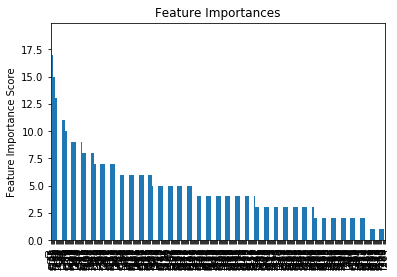

In [8]:
#Generate predictions for the validation and test data
first = True
#i = 0
for base_era, corr_eras in eras_dict.items():
    
    print("\n\tGenerating predictions for %s\n" % base_era)
    if len(corr_eras) == 0:
        print("\t This era does not correlate with any other era\n")
        continue
    
    #this is sort of dummy prediction so using 10 estimators is ok
    model = fit_xgb_model(base_era, 10)
    
    testX = data.era_isin([base_era]).x
    testY = data.era_isin([base_era]).y['kazutsugi']
    dtest_predictions = model.predict(testX)
    dpreSeries = pd.Series(dtest_predictions, index=data.era_isin([base_era]).df.index)
    
    if first == True:
        globalSeries = dpreSeries
        first = False
    else:
        globalSeries = pd.concat([globalSeries, dpreSeries])
        
    print("------------------------------------")

In [9]:
#This dataset contained till era922. For future data this may not be the last era but 
#the predictions can be appended to the 
globalSeries.to_csv("pjosh_erasubset_basic_test_922.csv", header=['probability_kazutsugi'])

### Generate correlation cluster for the live era

In [12]:
live_corrcluster, live_corr = createCorrClusters(2,312, ['eraX'], verbose=1)

Generating clusters for era eraX


In [13]:
#combine the 2 correlation clusters
total_corrcluster = pd.concat([fset_corrcluster, live_corrcluster], axis=0)

In [14]:
train_era_arr = np.unique(data.region_isin(['train', 'validation']).era)
train_era_strs = data.eras_int2str(train_era_arr)

In [19]:
#Generate subset of train eras that are similar to the live era
base_fset =  total_corrcluster.loc[['eraX']].values[0]
for test_era in train_era_strs:
    if base_era == test_era:
        continue
    test_fset = total_corrcluster.loc[[test_era]].values[0]
    score1 = metrics.adjusted_rand_score(base_fset, test_fset)
    score2 = metrics.adjusted_mutual_info_score(base_fset, test_fset, average_method='geometric' )
    if score2 > 0.7:
        print("train_era %s score is %g and %g "% (test_era, score1, score2))

train_era era105 score is 0.482515 and 0.706494 
train_era era125 score is 0.508261 and 0.709798 
train_era era126 score is 0.524759 and 0.702118 
train_era era92 score is 0.507295 and 0.716894 
train_era era93 score is 0.531018 and 0.73598 


#### Now the above eras can be used to train the ML model. We have found the subset of training eras that are most similar to the given live era